## References
http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf

In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
import math

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import tokenize_re, punct
from pygents.plot import plot_dict
from pygents.util import dictcount, dict_compress_with_loss, dictdict_div_dict, dictdict_mul_dictdict

punct = punct + "”“–&•"


In [2]:
test_dataset_file_path = "./data/corpora/English/distortions/sagarikashreevastava/test.csv"

In [3]:
# Dataset: Unclassified distortions (halilbabacan)
# Pre-print: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Paper: https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 


In [4]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


## Basic data check

### Binary Data Set (halilbabacan)

In [5]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)
df


Text  N/A text       Label  \
0         I'm such a failure I never do anything right.       NaN  Distortion   
1          Nobody likes me because I'm not interesting.       NaN  Distortion   
2      I can't try new things because I'll just mess...       NaN  Distortion   
3      My boss didn't say 'good morning' she must be...       NaN  Distortion   
4      My friend didn't invite me to the party I mus...       NaN  Distortion   
...                                                 ...       ...         ...   
3522  Since then whenever my mother is out alone I b...       NaN  Distortion   
3523  My family hate him but they didn’t met him at ...       NaN  Distortion   
3524  However I am not happy at the least only half ...       NaN  Distortion   
3525  Now I am at university my peers around me all ...       NaN  Distortion   
3526  He claims he’s severely depressed and has outb...       NaN  Distortion   

      N/A label  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
3522        NaN  
3523        NaN  
3524        NaN  
3525        NaN  
3526        NaN  

[3527 rows x 4 columns]

defaultdict(<class 'int'>, {'Distortion': 2594, 'No Distortion': 933, ' ': 0})


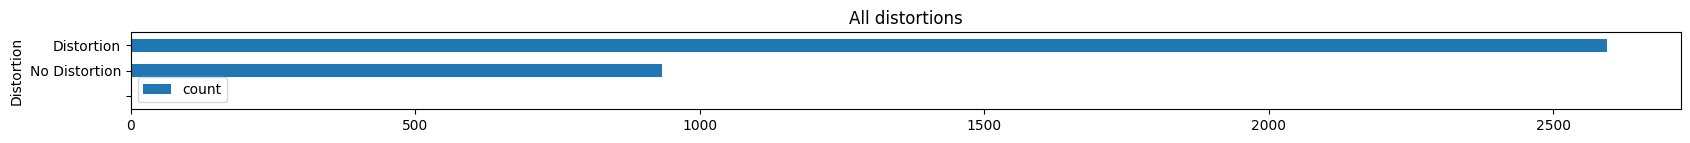

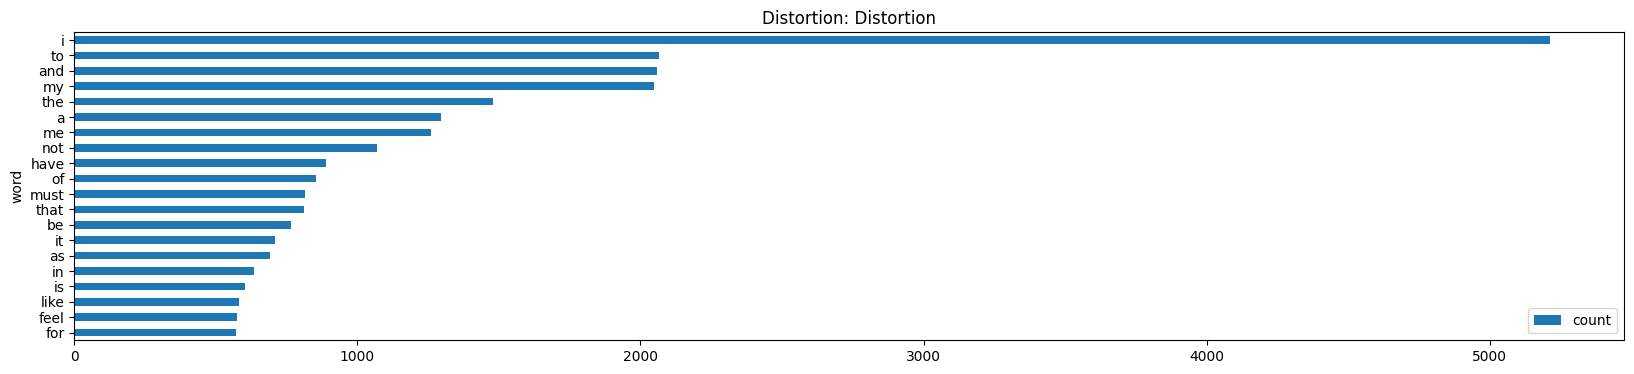

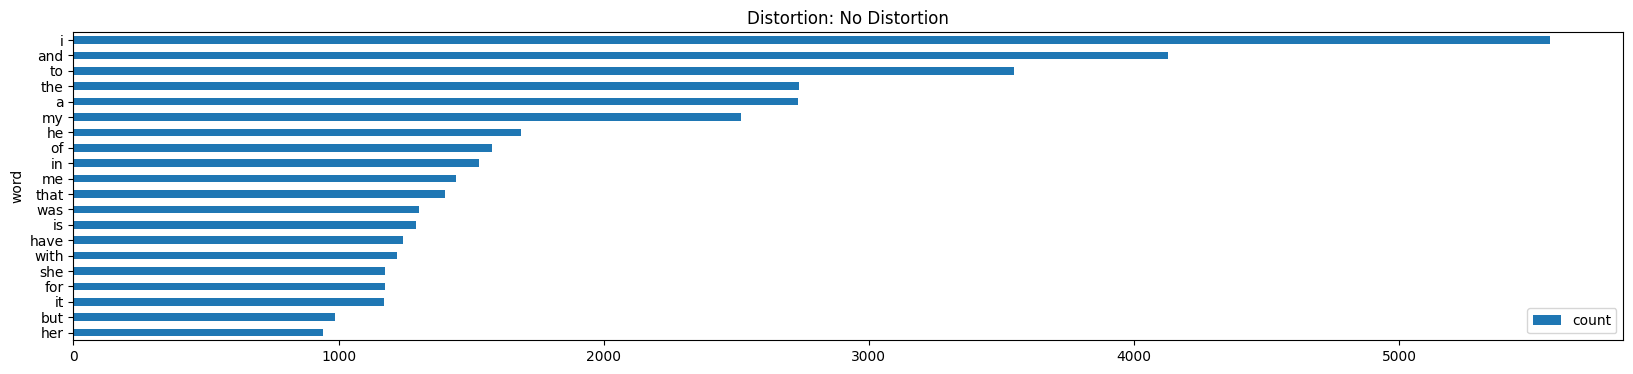

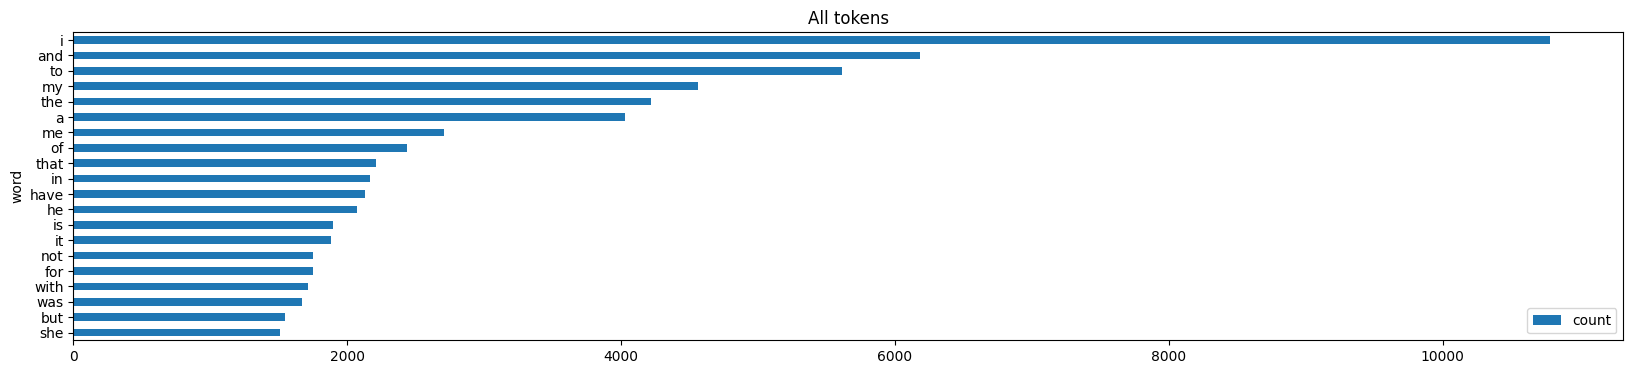

In [6]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
all_distortions[' '] = 0 # stub/hack
print(all_distortions)
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


### Multi-class Data Set (sagarikashreevastava)

In [7]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df


Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

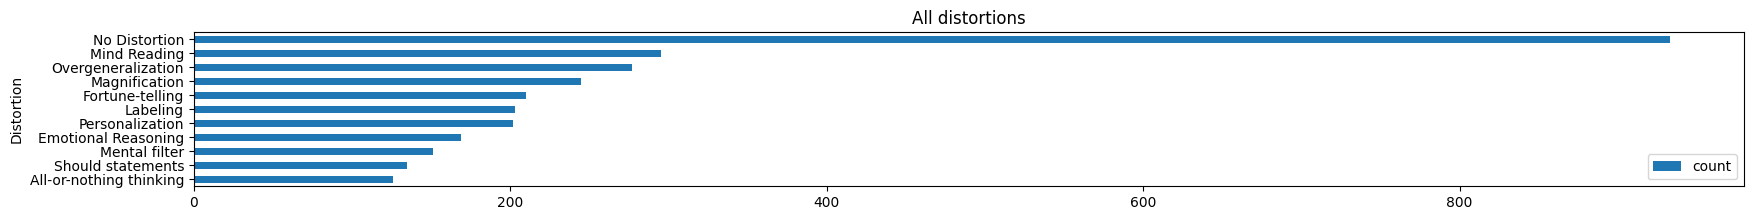

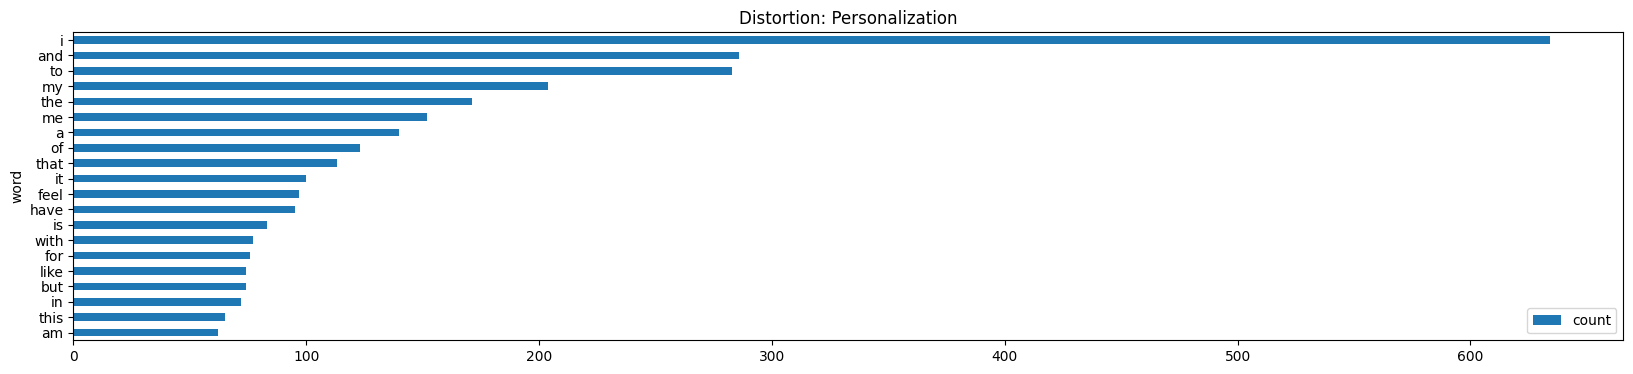

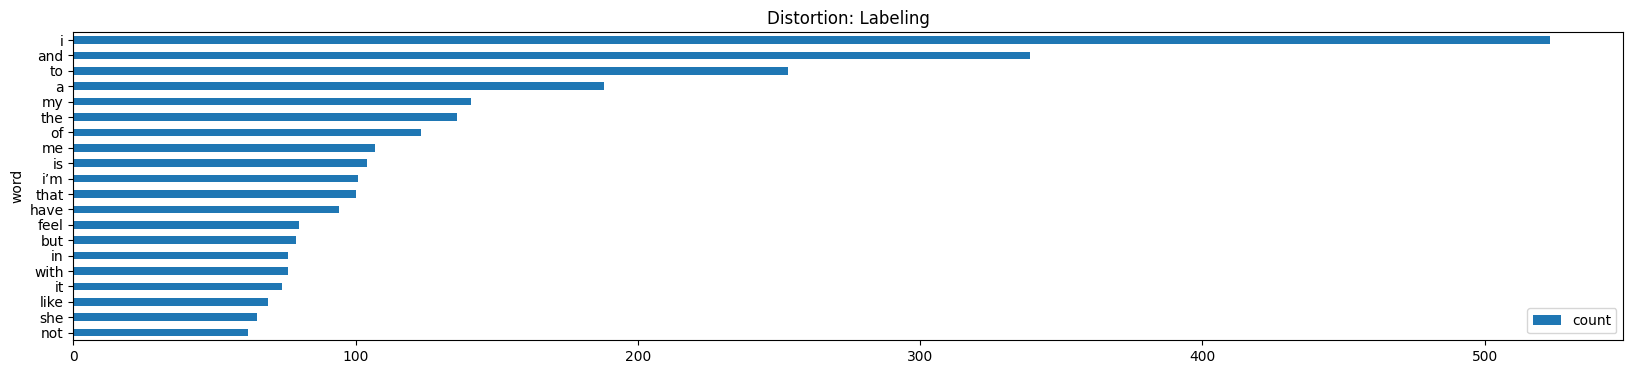

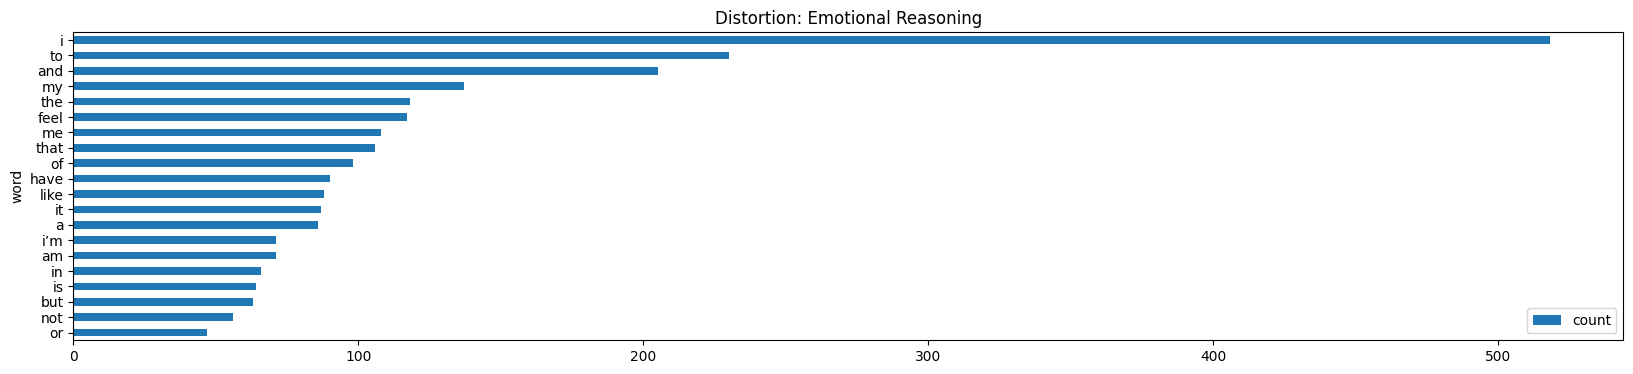

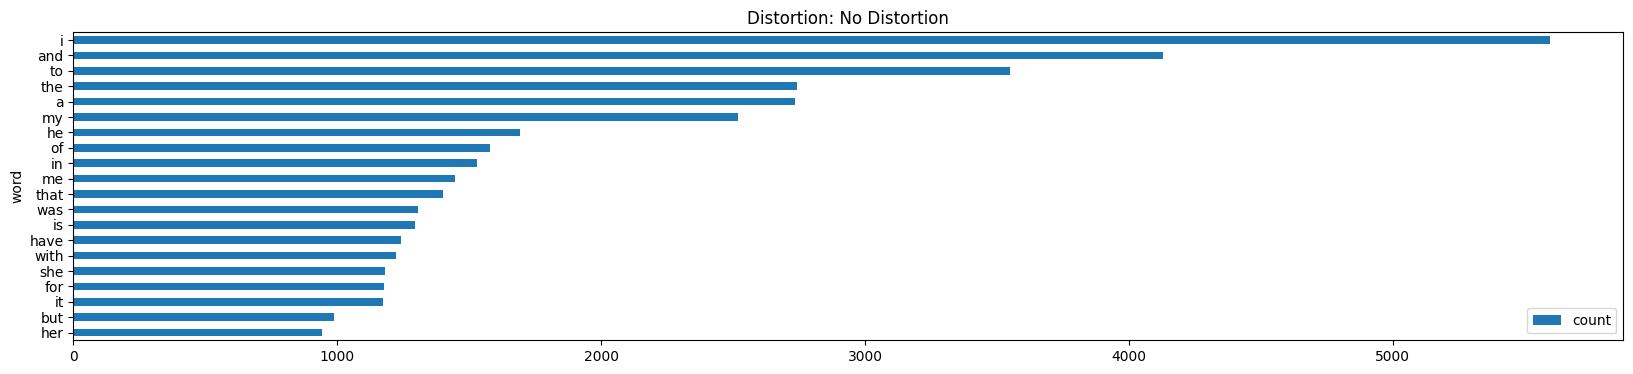

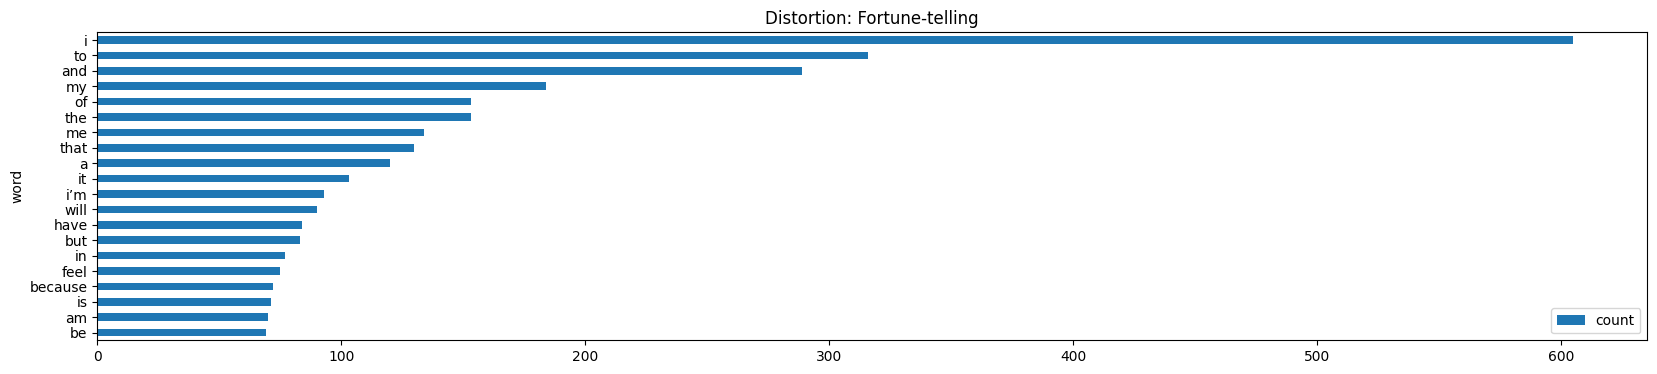

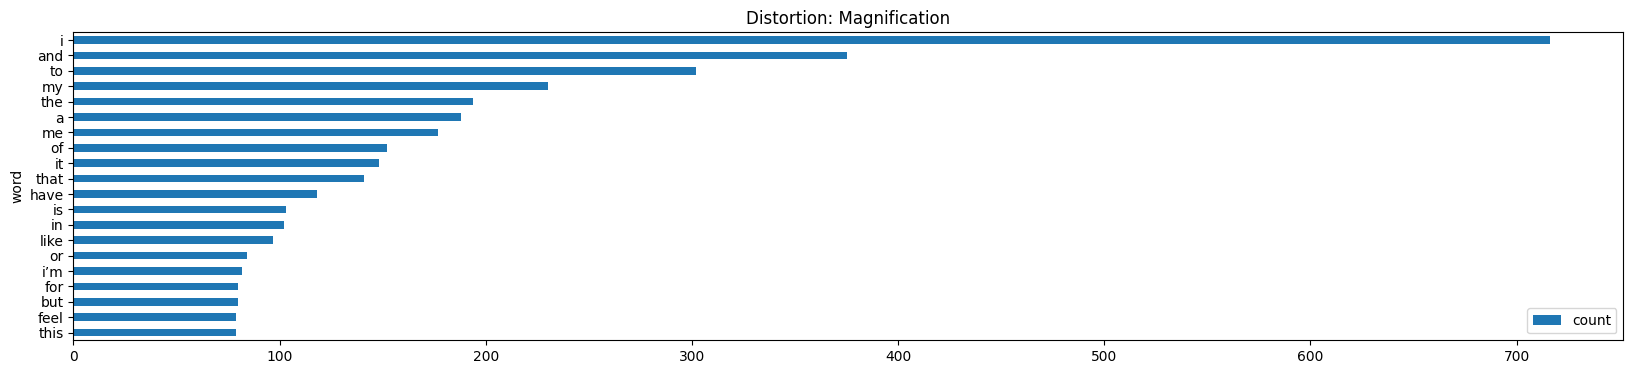

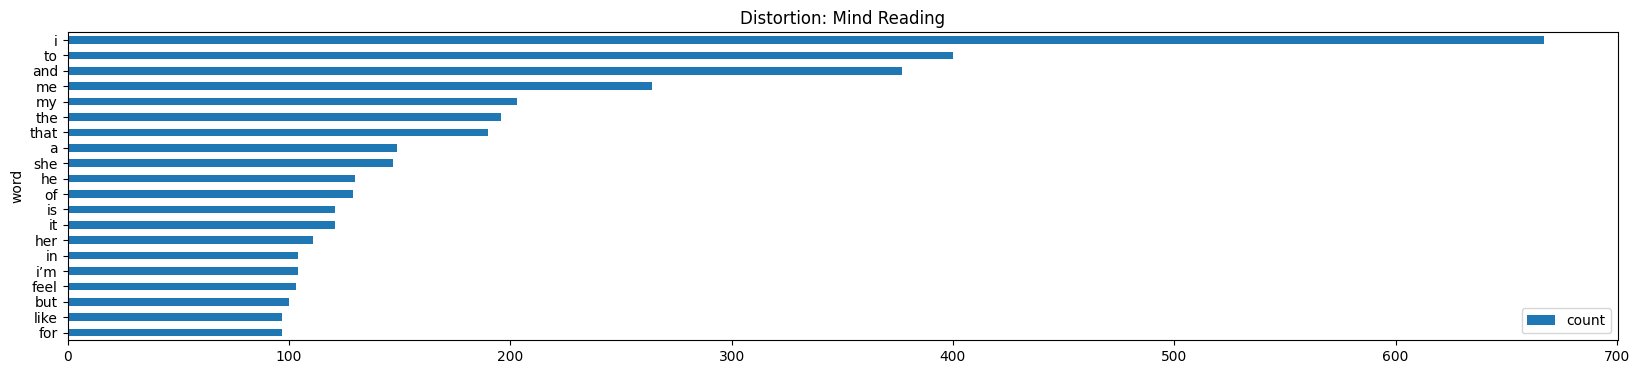

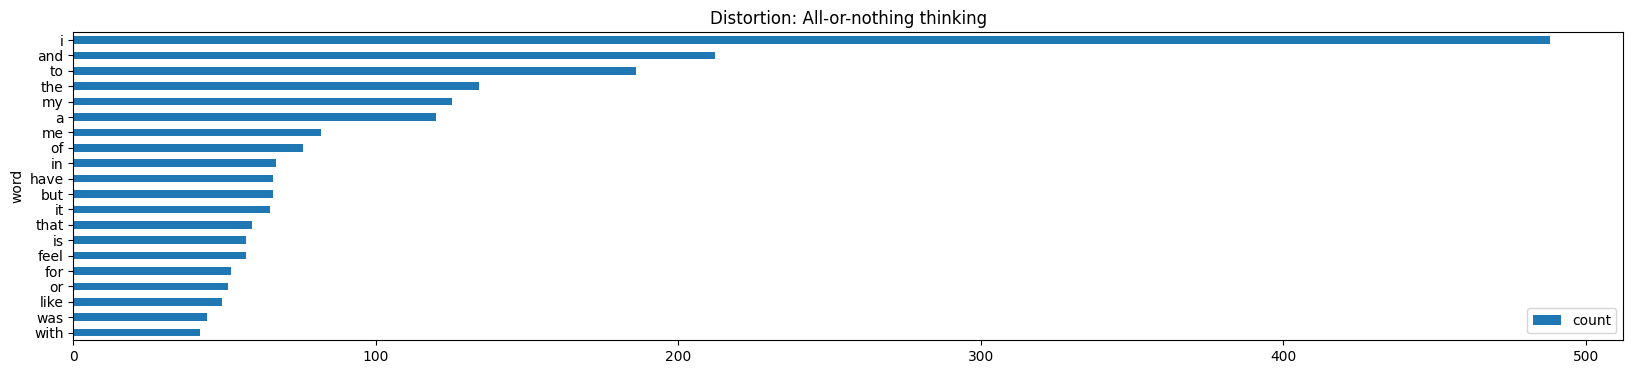

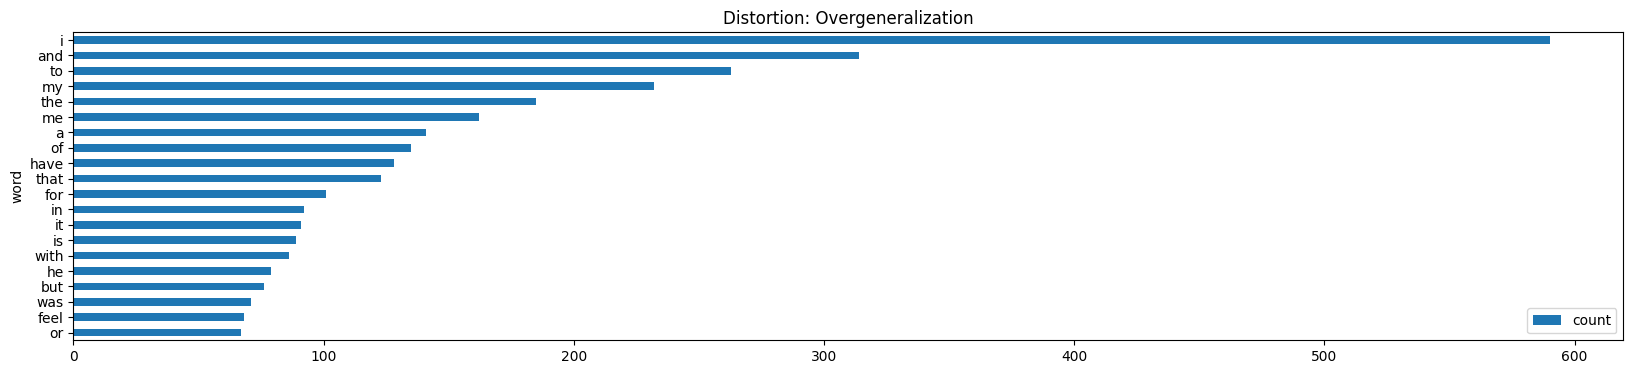

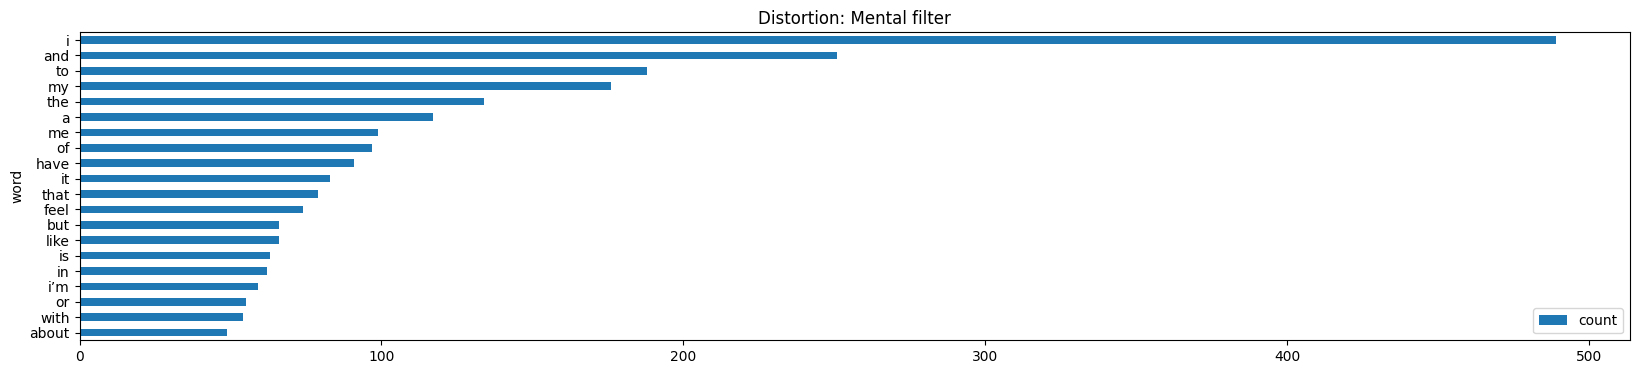

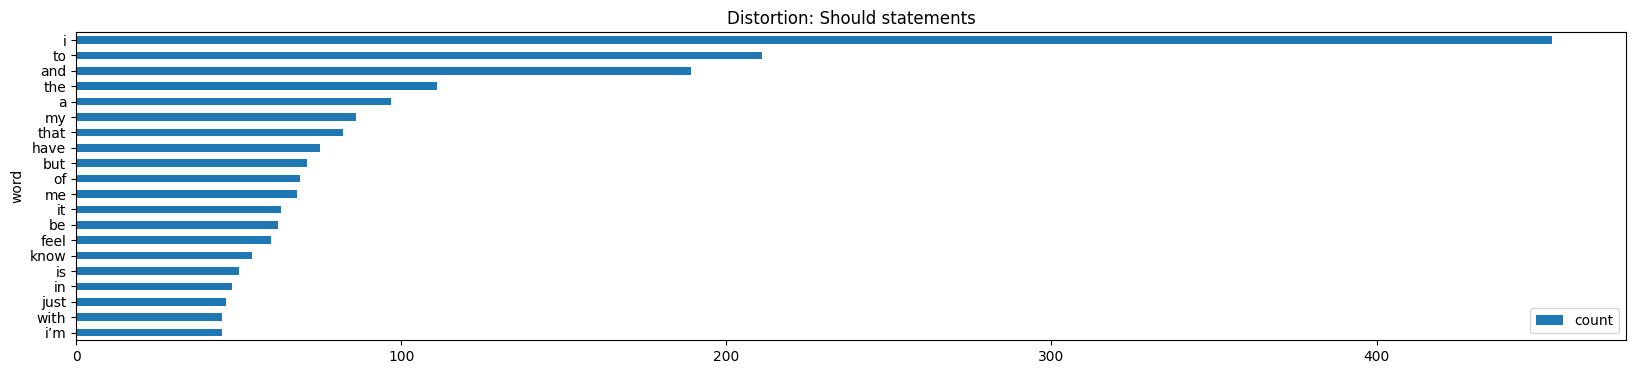

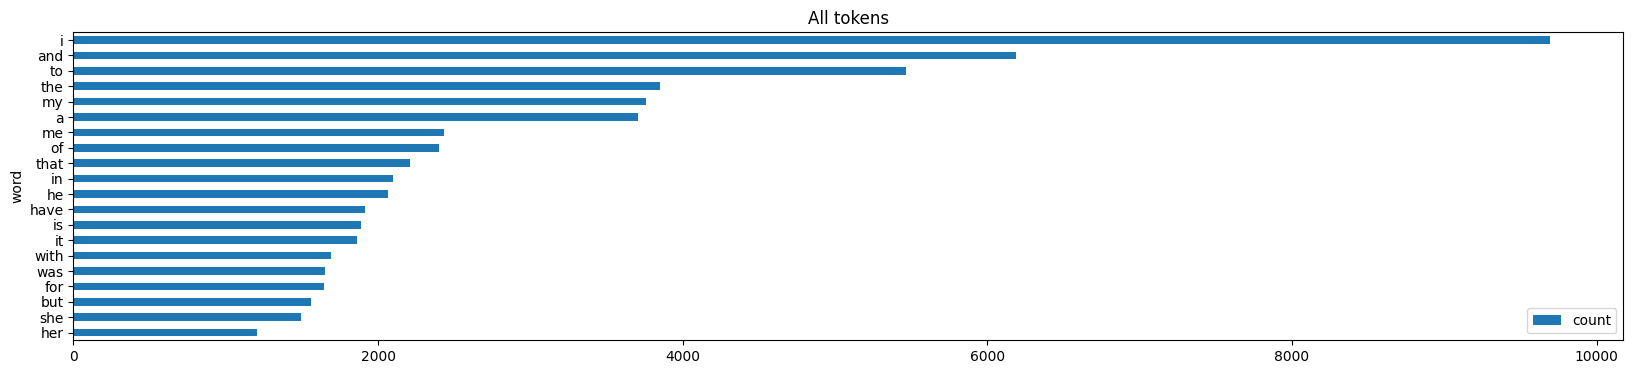

In [8]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


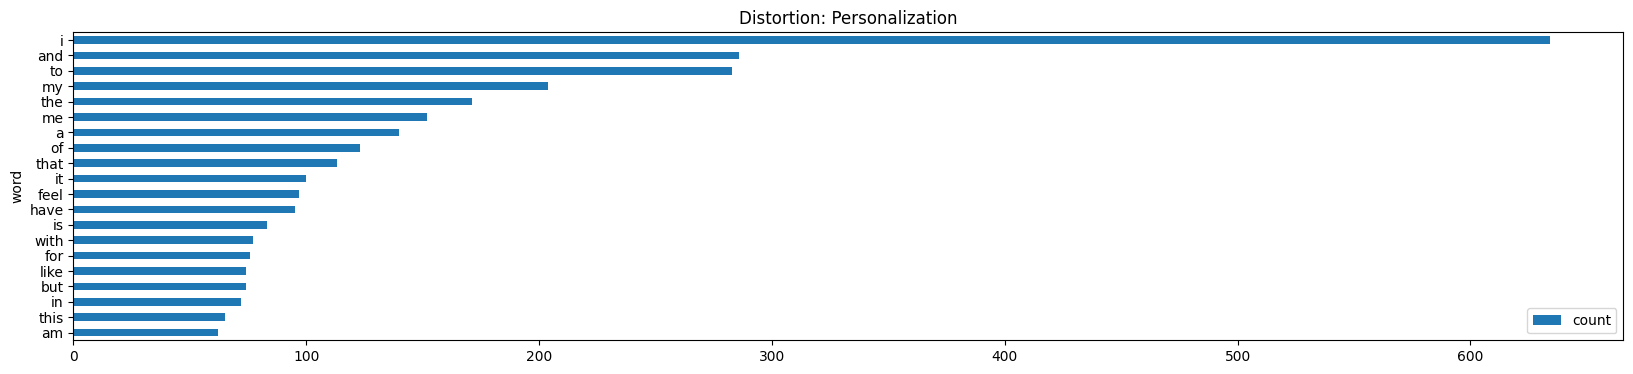

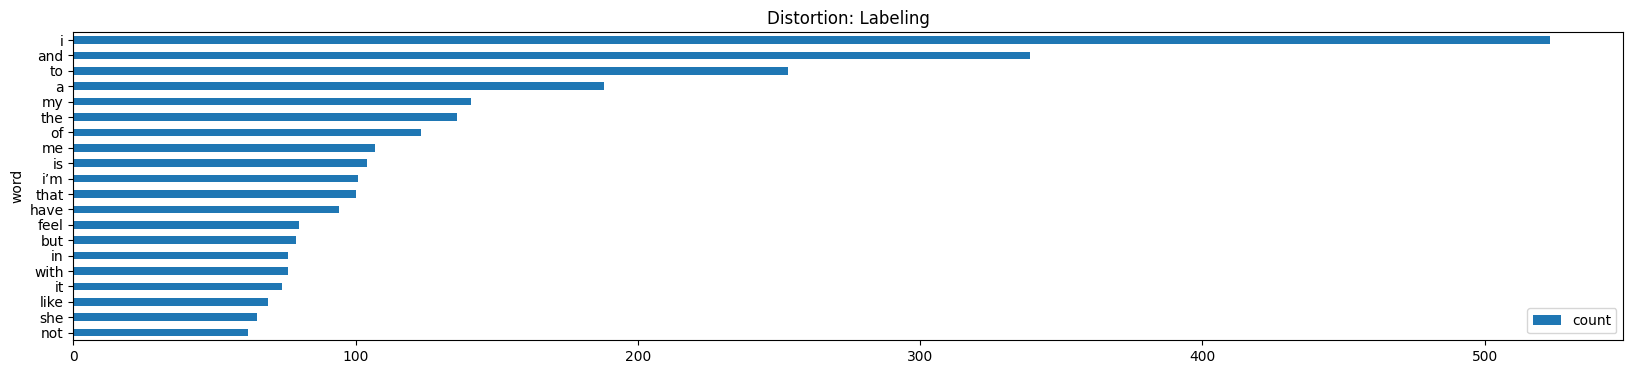

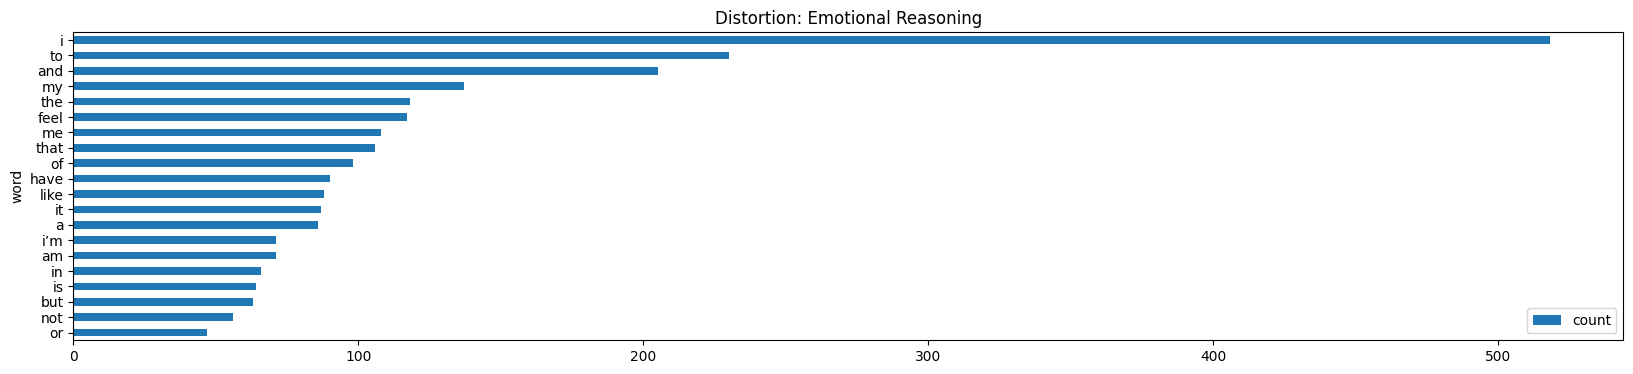

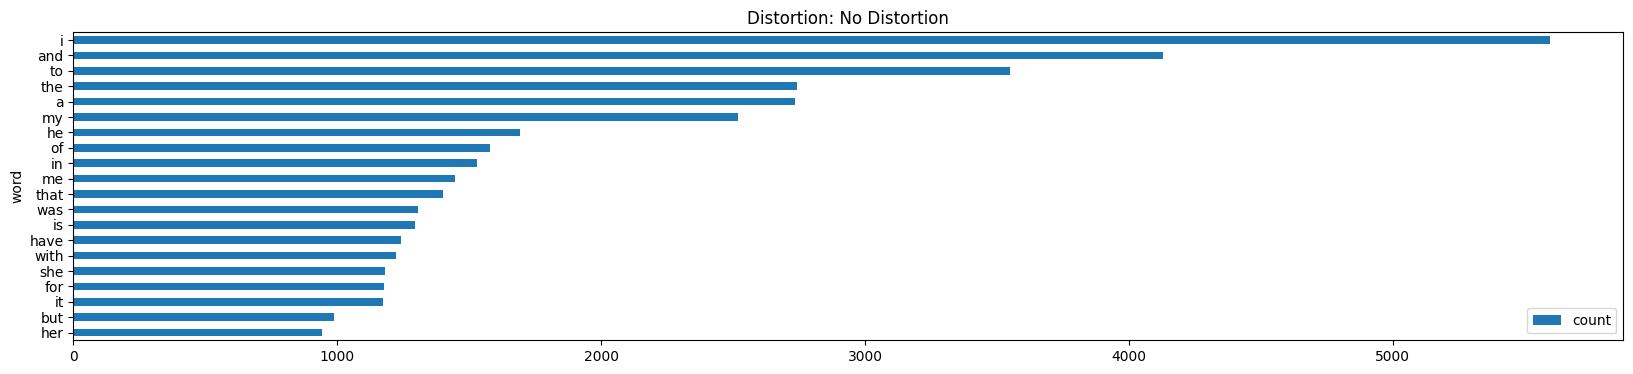

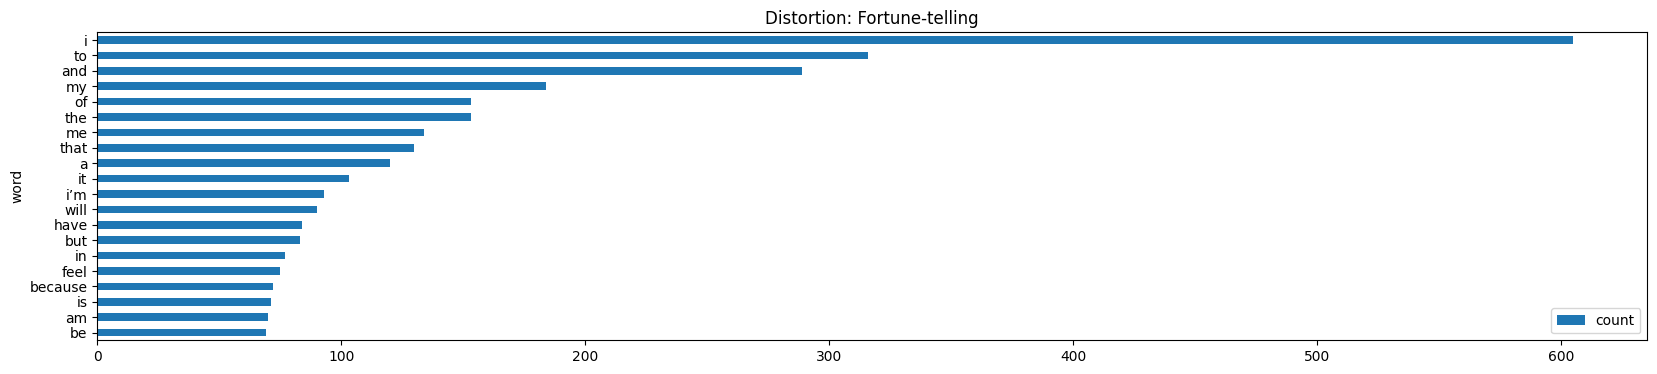

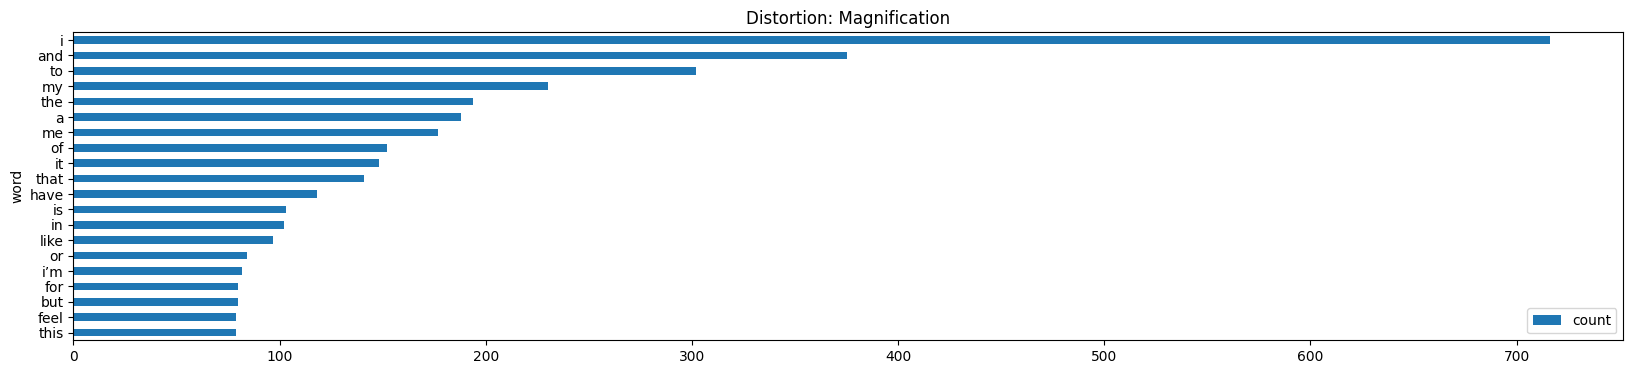

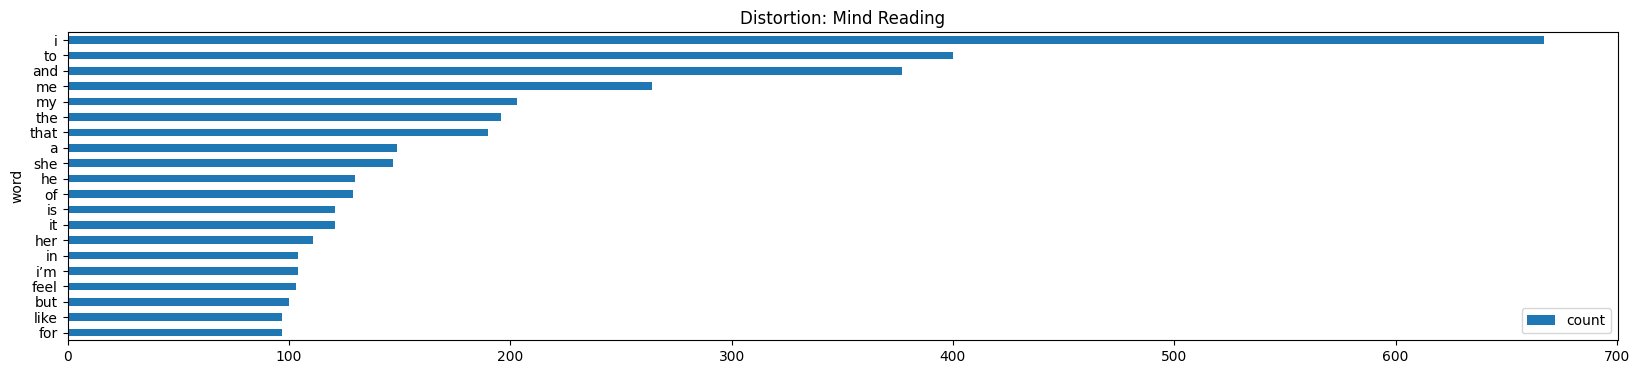

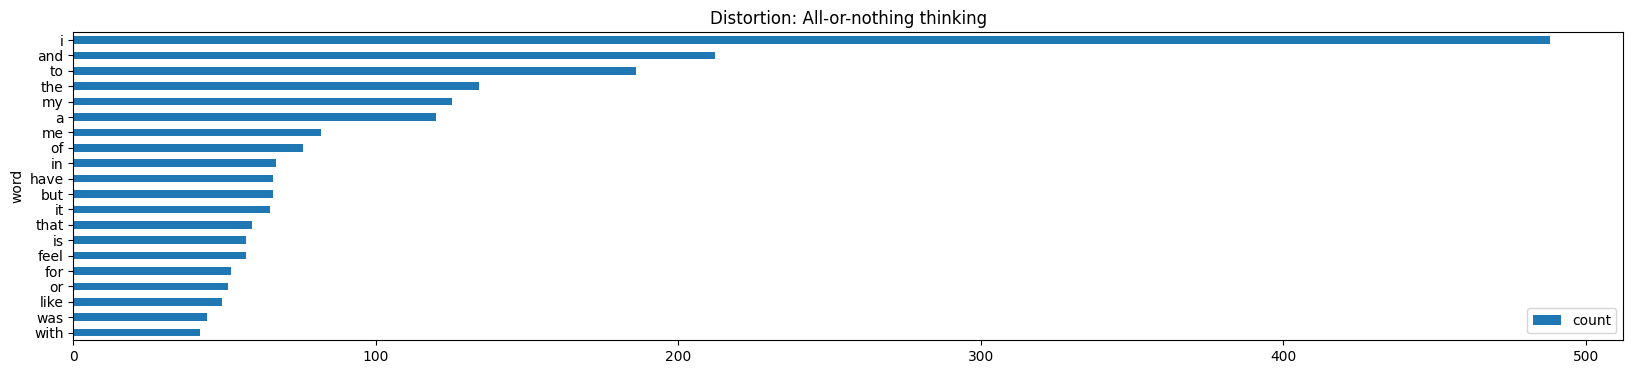

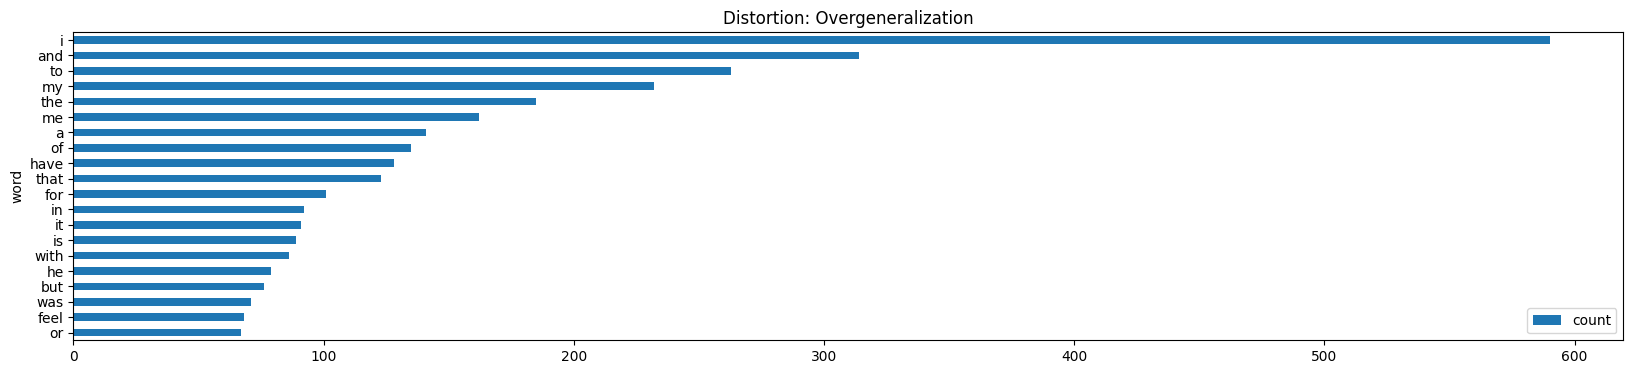

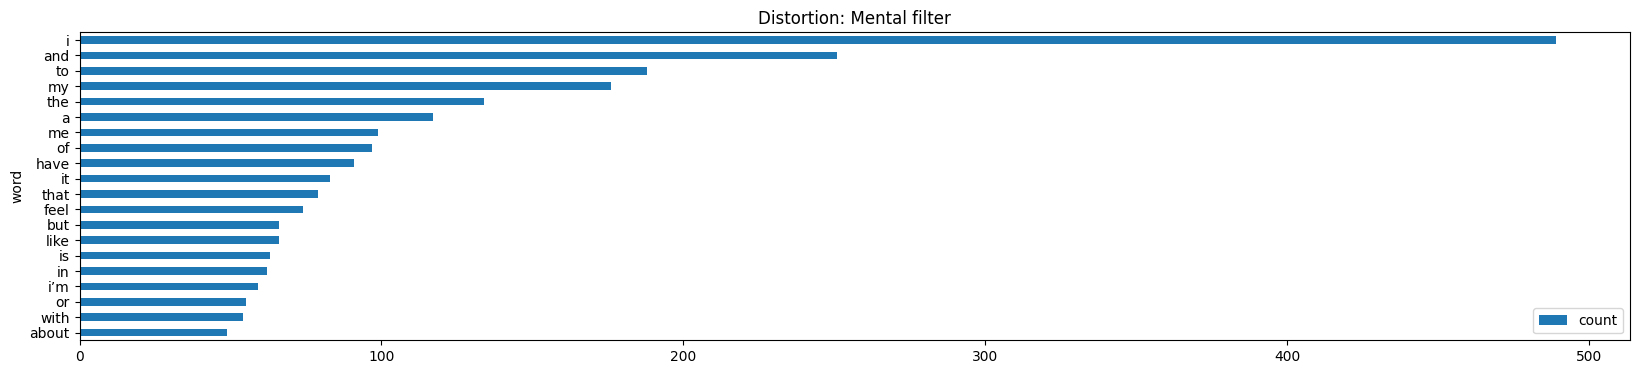

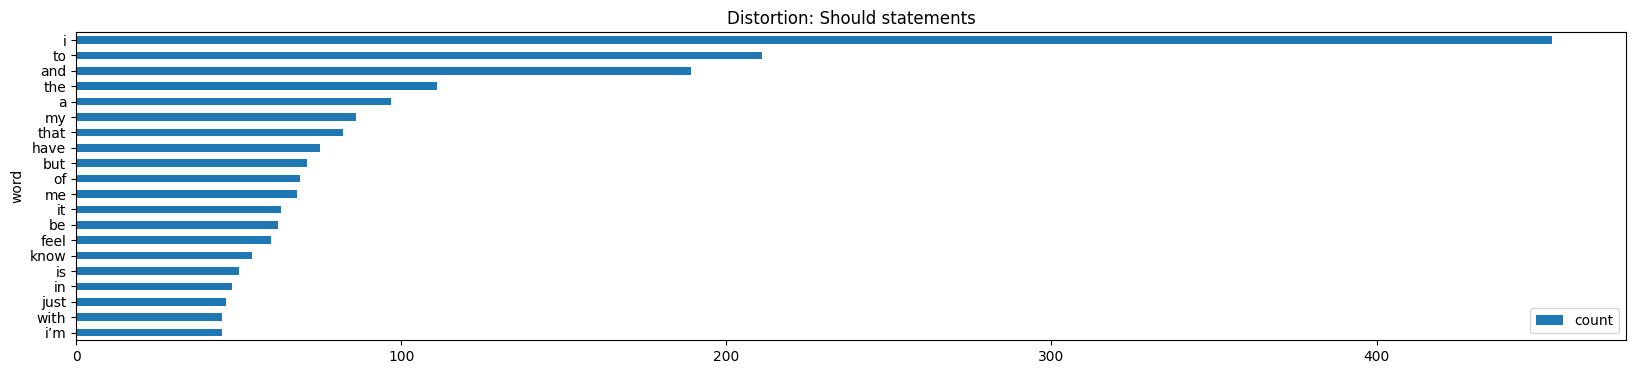

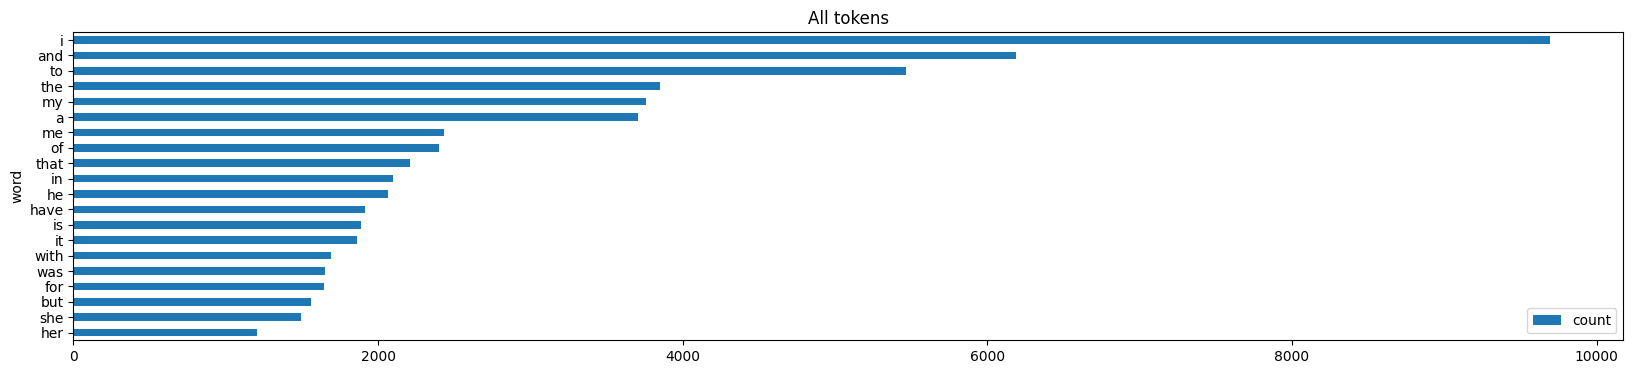

In [9]:
# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

## Define working functions to be moved to the code module

In [10]:
# Analyze the frequency of n-grams for each cognitive distortion

from pygents.aigents_api import build_ngrams

def count_ngrams_basic(df, n_max: int):

    distortions = defaultdict(int)

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    
    uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by Distortion
    uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
    n_gram_distortions = defaultdict(lambda: defaultdict(int)) # Counts of distortiions by N-gram

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present

        dictcount(distortions,primary_distortion)
        if secondary_distortion:
            dictcount(distortions,secondary_distortion)
        
        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, n_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

            uniq_n_grams = set(n_grams)
            for uniq_n_gram in uniq_n_grams:
                dictcount(uniq_n_gram_dicts[primary_distortion], uniq_n_gram)
                dictcount(uniq_all_n_grams, uniq_n_gram)
                dictcount(n_gram_distortions[uniq_n_gram],primary_distortion)
                if secondary_distortion:
                    dictcount(uniq_n_gram_dicts[secondary_distortion], uniq_n_gram)
                    dictcount(n_gram_distortions[uniq_n_gram],secondary_distortion)
                
    # Normalizing distortion-specific counts by total counts
    norm_n_gram_dicts = {}
    for n_gram_dict in n_gram_dicts:
        norm_n_gram_dict = {}
        norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        dic = n_gram_dicts[n_gram_dict]
        for n_gram in dic:
            #print(dic[n_gram])
            #print(all_n_grams[n_gram])
            #break
            if len(n_gram) <= n_max:
                norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / all_n_grams[n_gram]

    # Normalize uniq counts 
    norm_uniq_n_gram_dicts = {}
    for uniq_n_gram_dict in uniq_n_gram_dicts: # iterate over all distortions
        norm_uniq_n_gram_dict = {}
        norm_uniq_n_gram_dicts[uniq_n_gram_dict] = norm_uniq_n_gram_dict
        dic = uniq_n_gram_dicts[uniq_n_gram_dict] # pick uniq count of ngrams per distortion
        nonuniq_dic = n_gram_dicts[uniq_n_gram_dict] # pick non-uniq count of ngrams per distortion - BUG!?
        # Normalize uniq Document counts of N-grams by distortion by Documents count by Distortion
        for n_gram in dic:
            if len(n_gram) <= n_max:
                #norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) * nonuniq_dic[n_gram] / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram]) / all_n_grams[n_gram]
                # divide (uniq count if ngrams by distorion) by (count of texts with given distorion) and (count of ngrams with given distortion)
                norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram])
 
    n_gram_distortions_counts = {}
    for n_gram, dist_dict in n_gram_distortions.items():
        n_gram_distortions_counts[n_gram] = len(dist_dict)

    return distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts


def count_ngrams_plus(df, n_max: int):
    N = len(df)
    distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts = count_ngrams_basic(df, n_max)

    norm = dictdict_div_dict(n_gram_dicts,all_n_grams)
    norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)
    norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)
    norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)
    
    # norm_norm_uniq_norm_norm = norm_norm_uniq_norm[dist][n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]
    norm_norm_uniq_norm_norm = {} # looks like desired magic
    for dist in distortions:
        if not dist in norm_norm_uniq_norm: #hack
            continue
        dic = norm_norm_uniq_norm[dist]
        norm_norm_uniq_norm_norm[dist] = {}
        for n_gram in dic:
            norm_norm_uniq_norm_norm[dist][n_gram] = dic[n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]

    nl_mi = {}
    for dist in uniq_n_gram_dicts:
        dic = uniq_n_gram_dicts[dist]
        nl_mi[dist] = {}
        for n_gram in dic:
            nl_mi[dist][n_gram] = dic[n_gram] * dic[n_gram] / (distortions[dist] * uniq_all_n_grams[n_gram])
    
    fcr = {}
    cfr = {}
    mr = {}
    for dist in uniq_n_gram_dicts:
        dic = uniq_n_gram_dicts[dist]
        fcr[dist] = {}
        cfr[dist] = {}
        mr[dist] = {}
        for n_gram in dic:
            features_by_cat = sum(dic.values()) # features by category
            cats_by_feature = sum(n_gram_distortions[n_gram].values()) # categories by feature
            fcr[dist][n_gram] = dic[n_gram] / cats_by_feature # feature to category relevance - denominated by n of categories by feature
            cfr[dist][n_gram] = dic[n_gram] / features_by_cat # category to feature relevance - denominated by n of features by category
            mr[dist][n_gram] = dic[n_gram] * dic[n_gram] / (features_by_cat * cats_by_feature)
    
    return distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, norm_uniq, norm_norm_uniq, norm_norm_uniq_norm, norm_norm_uniq_norm_norm, \
    fcr, cfr, mr, nl_mi, N


## Definitions
|Python|Formula|Formula meaning|
|---|---|---|
|all_n_grams | $G_g$ | total count of N-gram $g$ in the entire corpus|
|distortions | $D_d$ | count of texts with distortion $d$ per corpus|
||$G_d$|count of N-grams associated with distortion $d$|
|uniq_all_n_grams | $G^u_g$ | total uniq count of N-gram $g$ in the entire corpus (counting every N-gram appearing in particular text only once)|
|n_gram_distortions_counts | $D_g$ | count of distortions by N-gram $g$, based on $DG_{dg}$ |
|n_gram_dicts | $GD_{gd}$ | count of N-gram $g$ associations with distortion $d$ - **frequency** - *DONE*|
|uniq_n_gram_dicts | $GD^u_{gd}$ | count of unique N-gram $g$ associations with distortion $d$ (counting every N-gram appearing in particular text only once) - **uniq frequency** - *TODO?*|
|n_gram_distortions | $DG_{dg}$ | count of distortion $d$ associations with N-gram $g$ (counting every N-gram appearing in particular text only once), $DG_{dg} == GD^u_{gd}$ |
|norm_n_gram_dicts == norm = dictdict_div_dict(n_gram_dicts,all_n_grams)| $\bar{GD}_{gd} = GD_{gd} / G_g$ | **frequency self-normalized** -  counts of N-grams normalized by corpus counts - *DONE*|
|norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)| $\bar{GD}^u_{gd} = GD^u_{gd} / G^u_g$ | **unique frequency self-normalized** - counts of uniq N-grams normalized by uniq corpus counts - *TODO?*|
|norm_uniq_n_gram_dicts| $GD^u_{gd} /(D_d * D_g)$ | **unique frequency normalized by distortions** - unique count of N-gram $g$ associations with distiortion $d$ within the corpus, denominated by count of appearances of the distortion in corpus and count of distortions associated with N-gram - *TODO!*|
|norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)|$\bar{GD}_{gd} * \bar{GD}^u_{gd}$|**frequency sefl-normalized * unique frequency sefl-normalized** - *TODO?*|
|norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)|$\bar{GD}_{gd} * \bar{GD}^u_{gd} / D_g$|**frequency sefl-normalized * unique frequency sefl-normalized / distortions by N-gram** - *TODO?*|
|norm_norm_uniq_norm_norm = norm_norm_uniq_norm * n_gram_distortions / distortions|$\bar{GD}_{gd} * \bar{GD}^u_{gd} * DG_{dg} / (D_g * D_d)$|**magic recipe** - *TODO?*|
|fcr|$GD^u_{gd} / \sum_d{GD^u_{gd}}$|**feature category relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|cfr|$GD^u_{gd} / \sum_g{GD^u_{gd}}$|**category feature relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|mr|${GD^u_{gd}}^2 /(\sum_d{GD^u_{gd}} *  \sum_g{GD^u_{gd}})$|**mutual relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|nl_mi|$ {GD^u_{gd}}^2 / (D_d * G^u_g) )$|**non-logartihmic mutual information** - squared joint distribution of X and Y denominated by product of the marginal distribution of X and Y, according to https://en.wikipedia.org/wiki/Mutual_information - *TODO?*|
|mi|$MI(GD)_{gd}$ = $P(g,d)*log(P(g,d)/(P(g)*P(d)))$ = $(GD^u_{gd}/N)*log((GD^u_{gd}/N)/((D_d/N)*(G^u_g/N)))$ = $(GD^u_{gd}/N)*log(N *GD^u_{gd}/(D_d*G^u_g))$|**mutual information** according to https://en.wikipedia.org/wiki/Mutual_information (if the log base 2 is used, the unit of mutual information is the shannon), *found to be negative!?* - *SKIP?*|
|TF-IDF| $TF-IDF = GD_{gd} / G_d$ | **IF-IDF** -  counts of N-grams normalized by the total number of N-grams associations with distortion $d$ - *DONE*|


## Test on synthetic data

In [11]:
df = pd.read_csv(test_dataset_file_path)
df = df.drop('Id_Number', axis=1) # delete column with id 
    
distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,2)

for d1, d2 in zip(frequency_self_normalized, norm):
    assert( d1 == d2)
    for ng in frequency_self_normalized[d1]:
        assert( frequency_self_normalized[d1][ng] == norm[d2][ng] )

for d in unique_frequency:
    for ng in unique_frequency[d]:
        assert(unique_frequency[d][ng] == n_gram_distortions[ng][d] )


In [12]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

In [13]:
sum(unique_frequency['Fortune-telling'].values())

23

In [14]:
sum(n_gram_distortions[('will','fail')].values())

5

In [15]:
unique_frequency['Fortune-telling'][('will', 'fail')]

3

In [16]:
unique_frequency['Fortune-telling'][('will', 'fail')] \
* unique_frequency['Fortune-telling'][('will', 'fail')] \
/ sum(unique_frequency['Fortune-telling'].values()) \
/ sum(n_gram_distortions[('will','fail')].values())

0.0782608695652174

In [17]:
mr['Fortune-telling'][('will', 'fail')]

0.0782608695652174

In [18]:
fcr['Fortune-telling'][('will', 'fail')]

0.6

In [19]:
cfr['Fortune-telling'][('will', 'fail')]

0.13043478260869565

In [20]:
nl_mi['Fortune-telling'][('will', 'fail')]

1.0

In [21]:
nl_mi['No Distortion'][('will', )]

0.16

In [22]:
def plot_metric(dictdict,name,head=20):
    for distortion, metric in dictdict.items():
        if distortion == 'No Distortion':
            continue
        plot_dict(metric, labels="N-gram",values="metric", title=f"{name} for Distortion: {distortion}", head=head, fontsize = 20 )


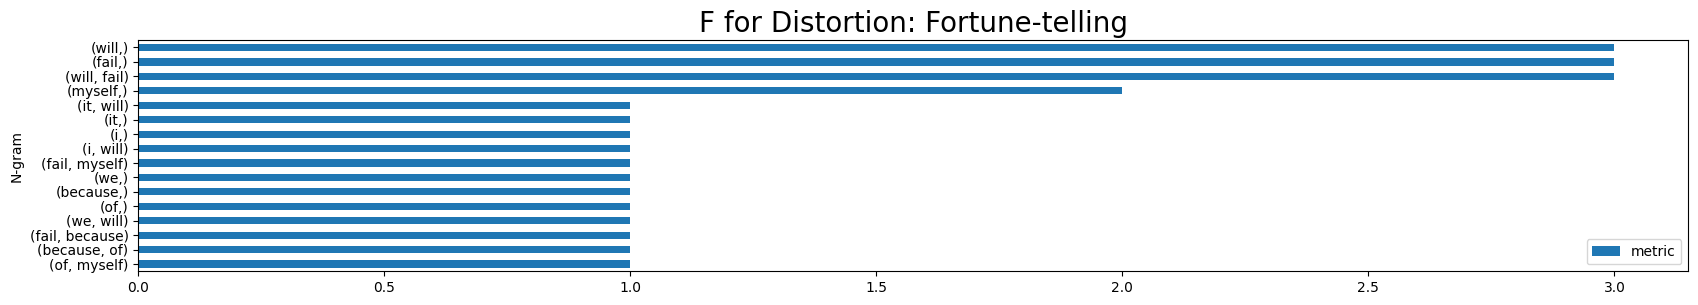

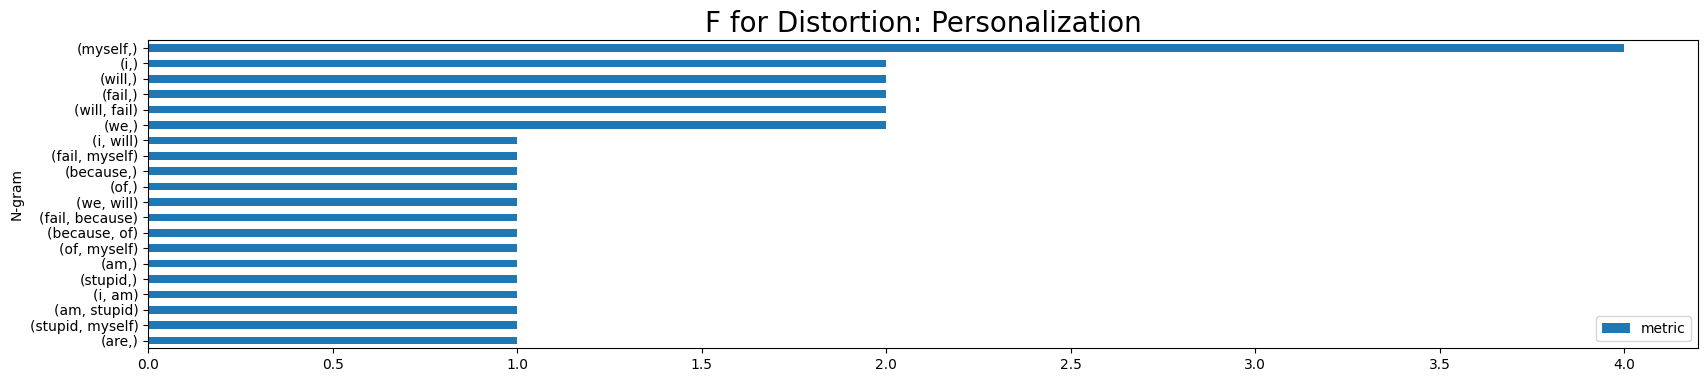

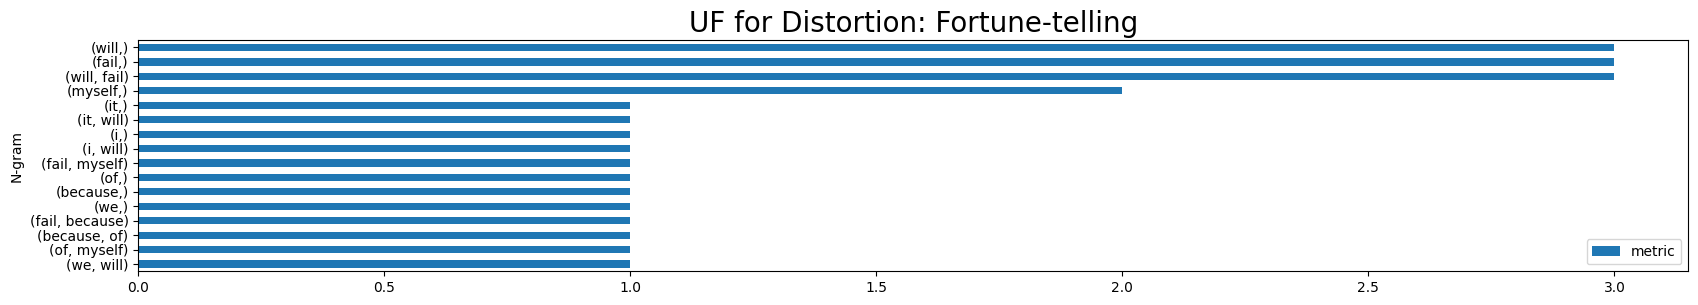

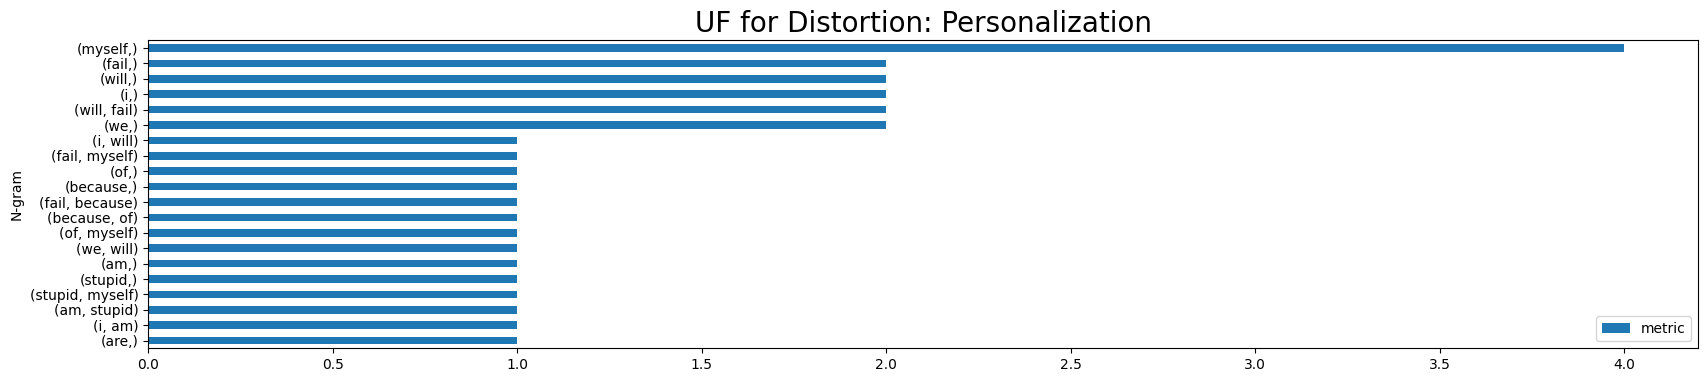

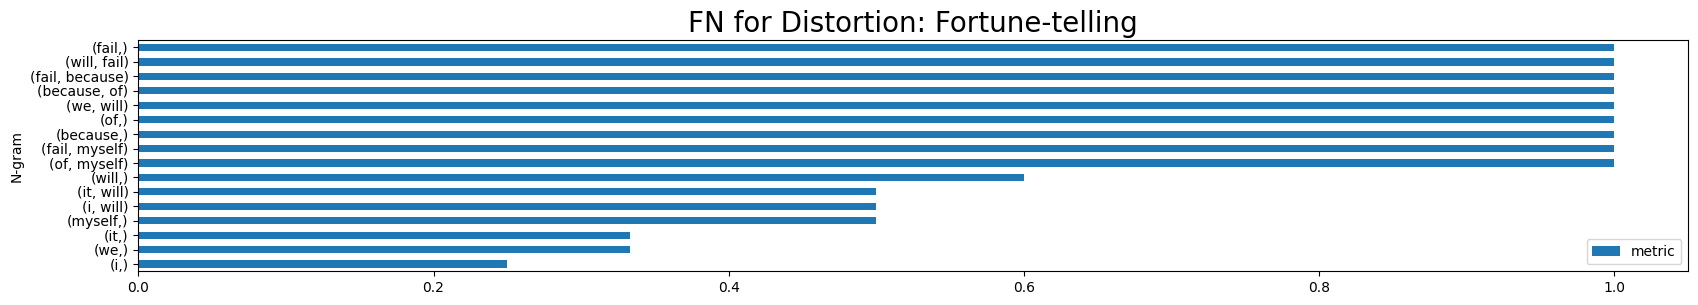

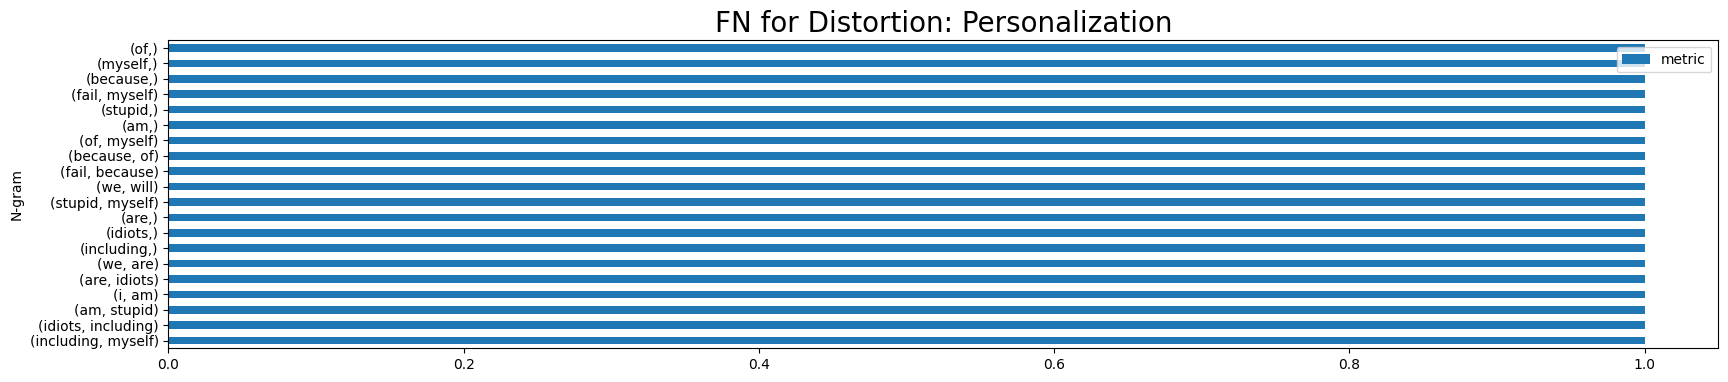

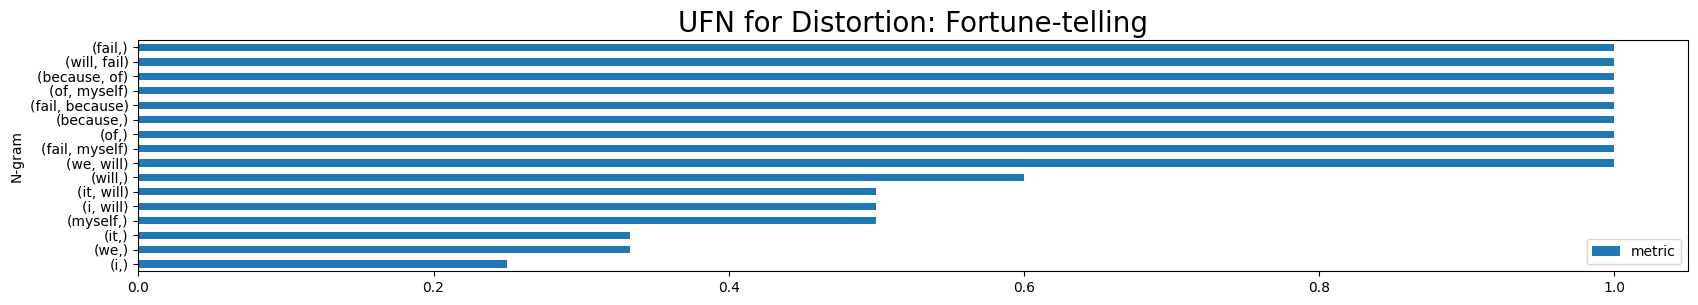

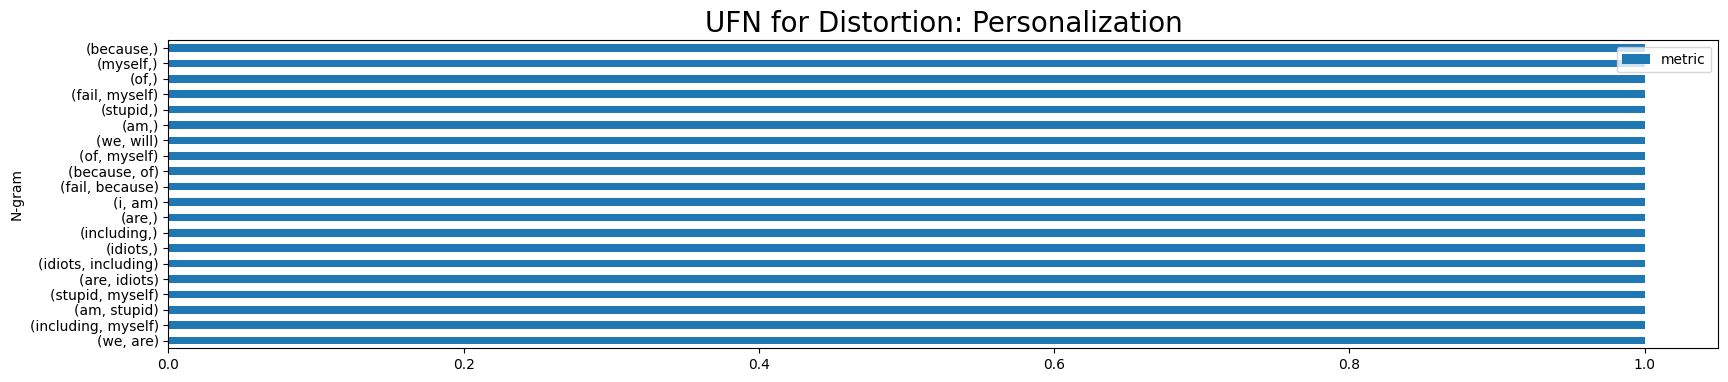

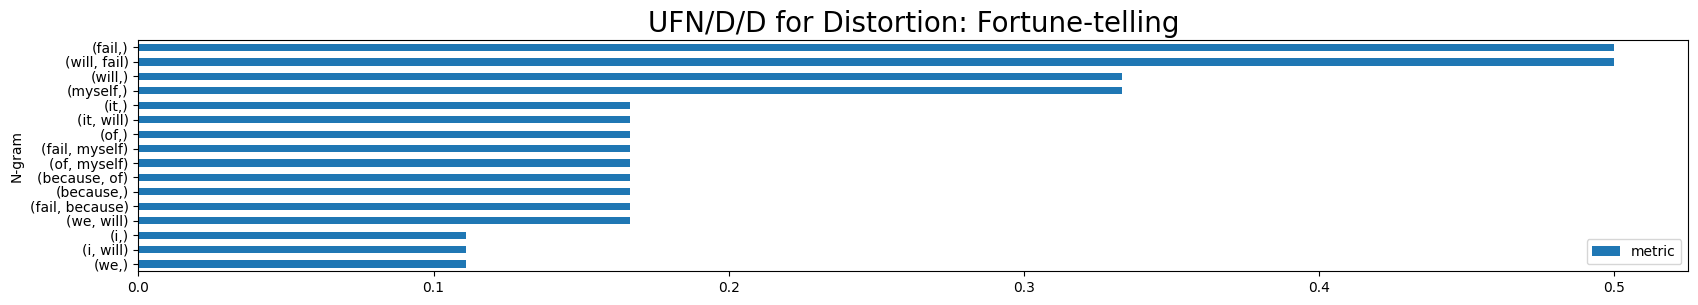

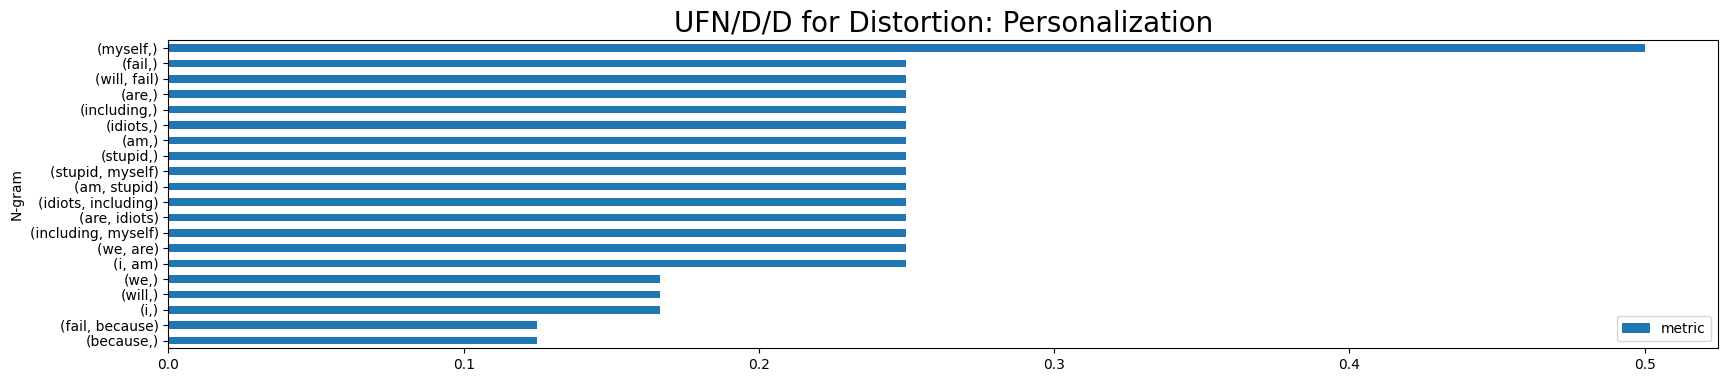

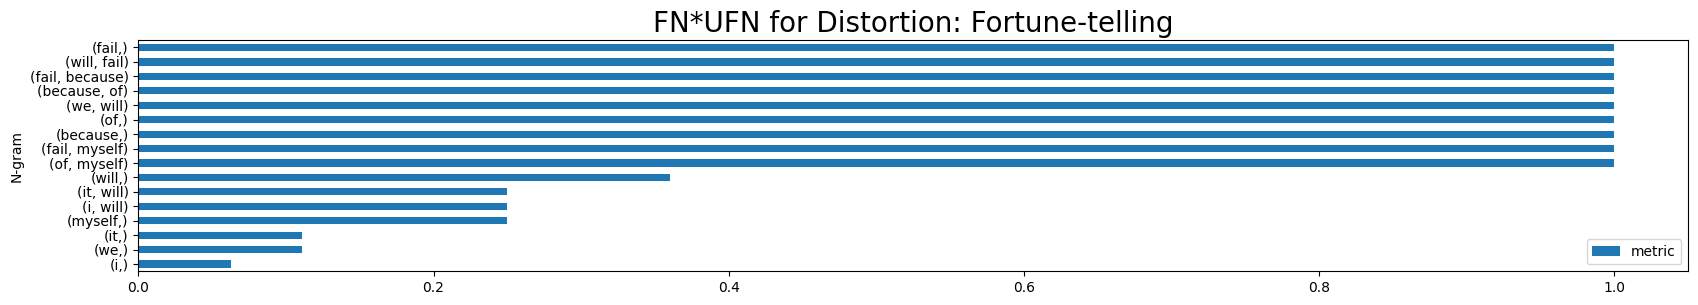

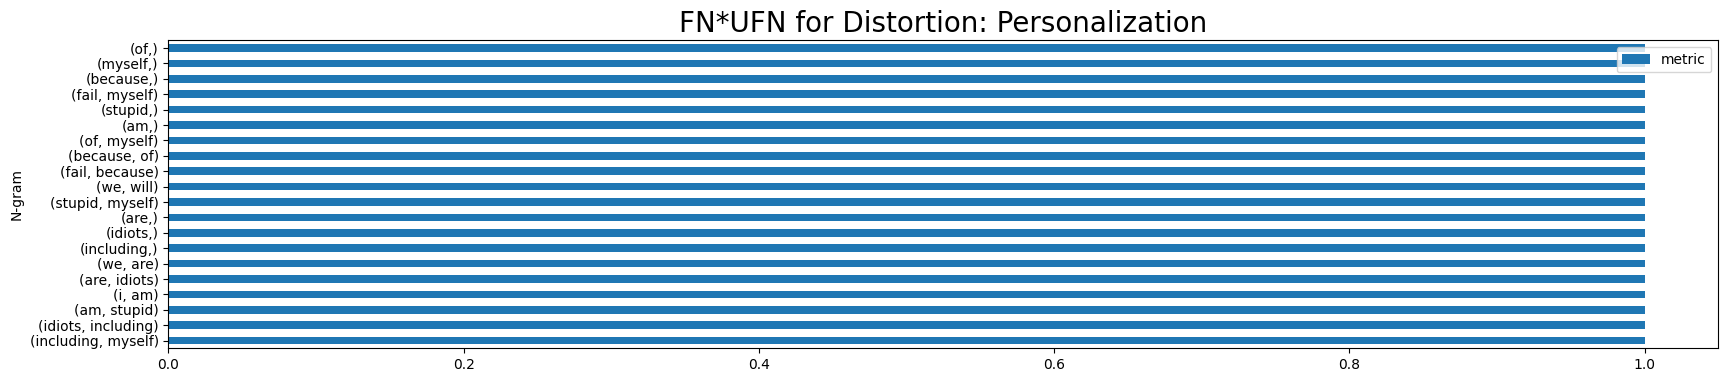

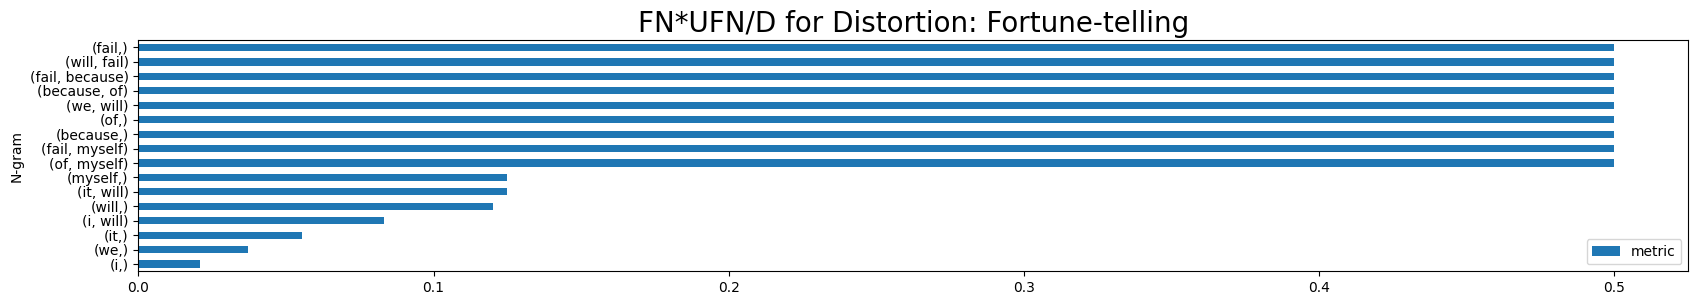

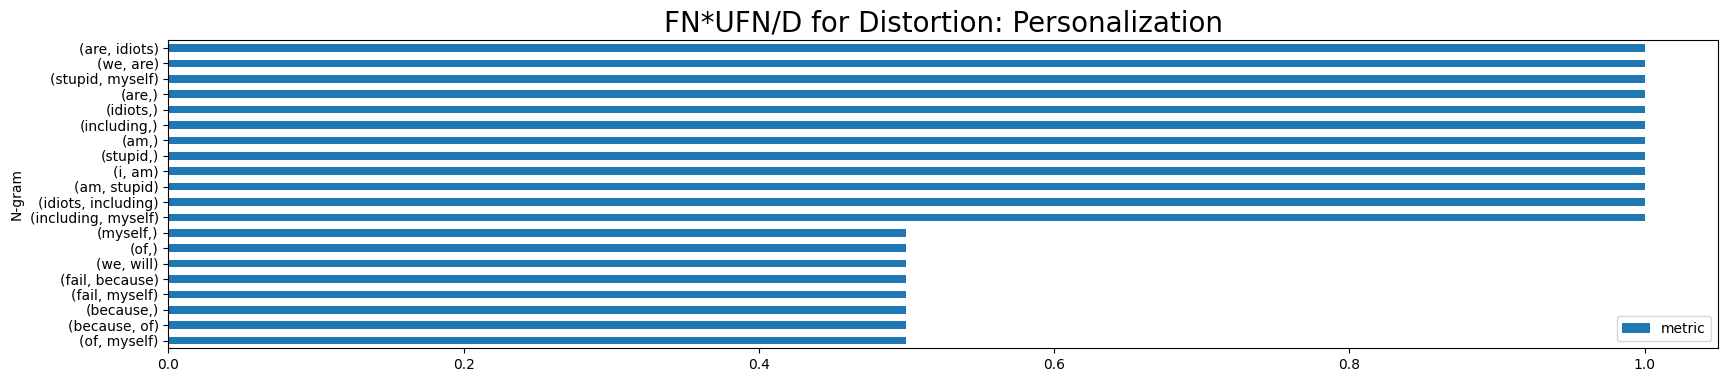

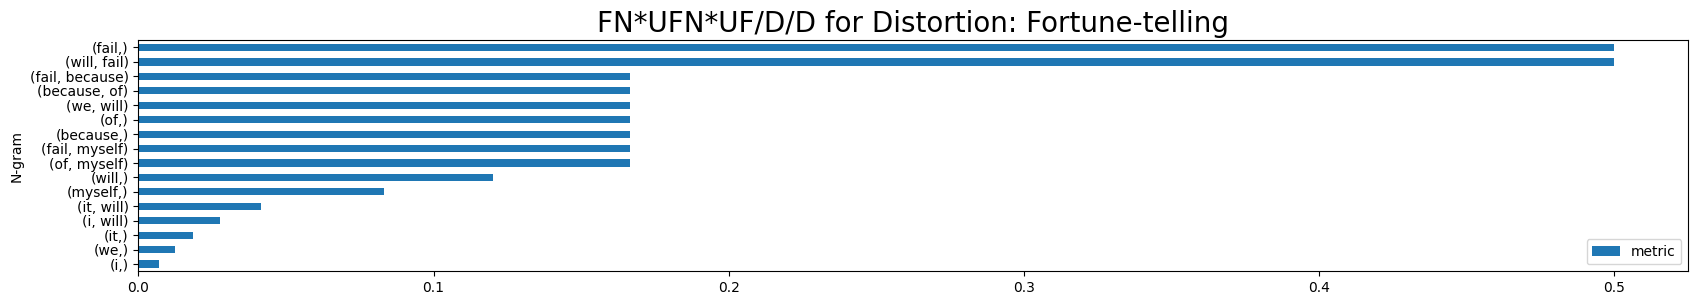

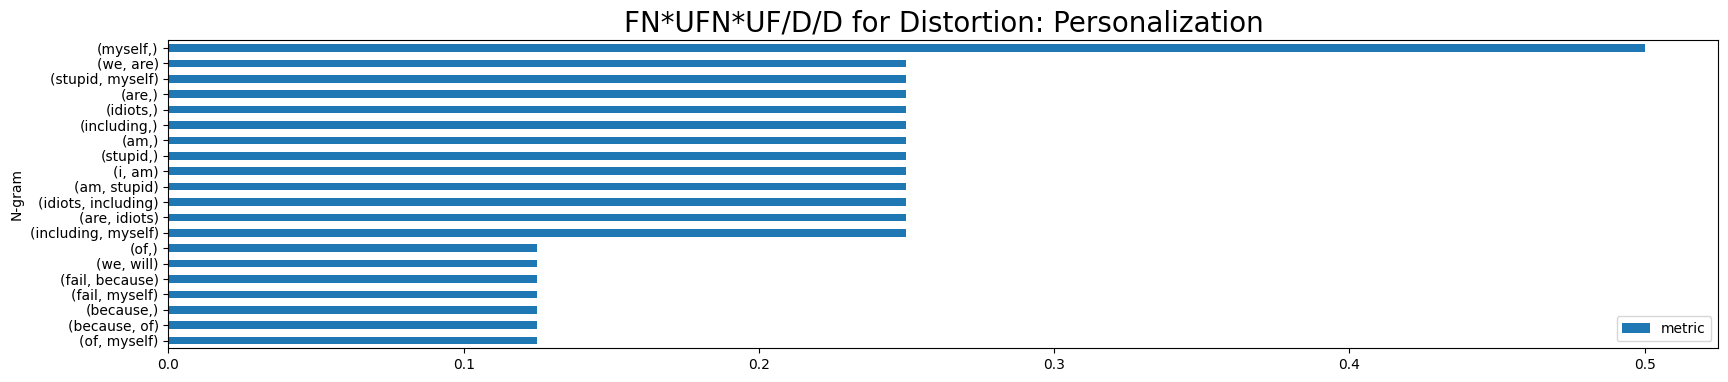

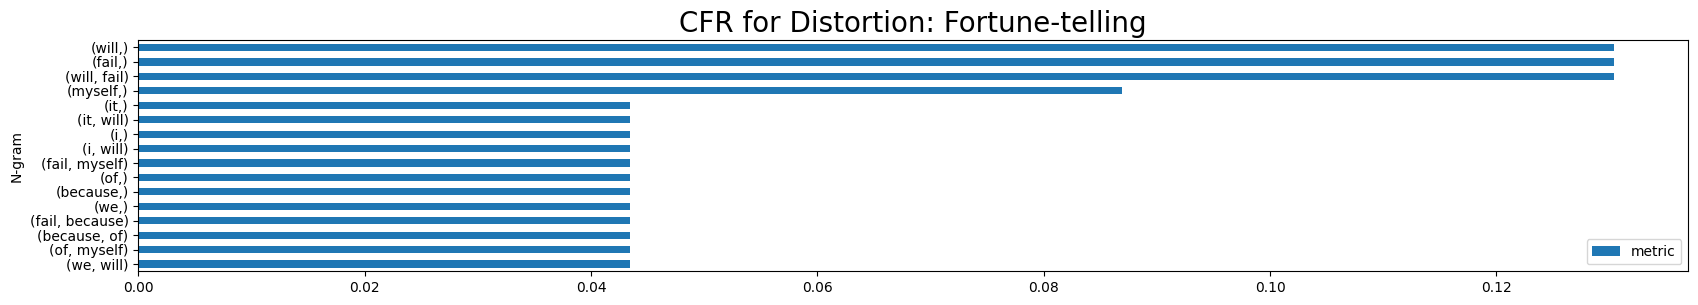

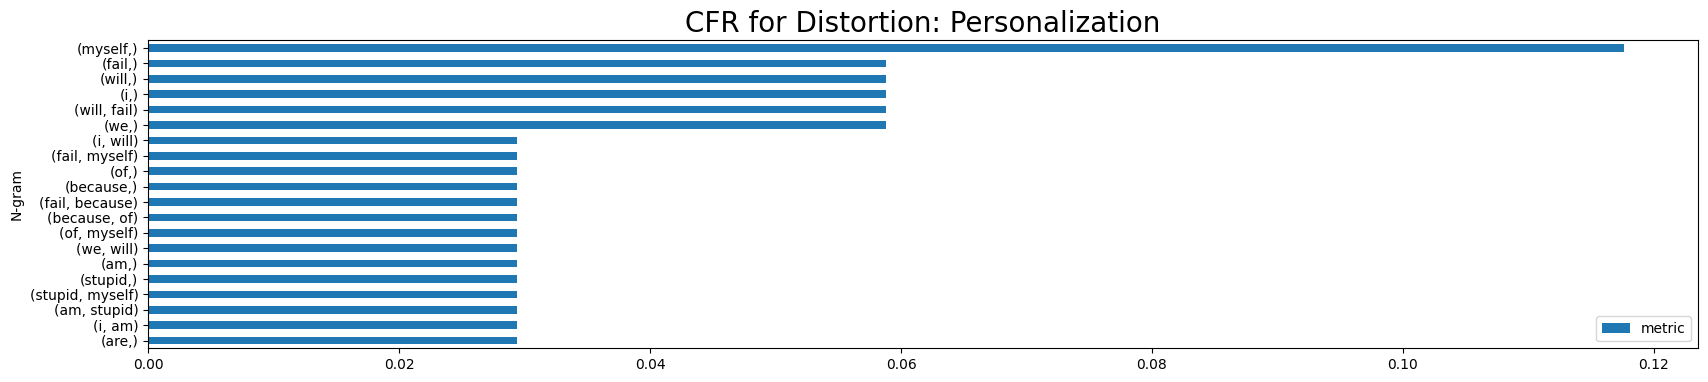

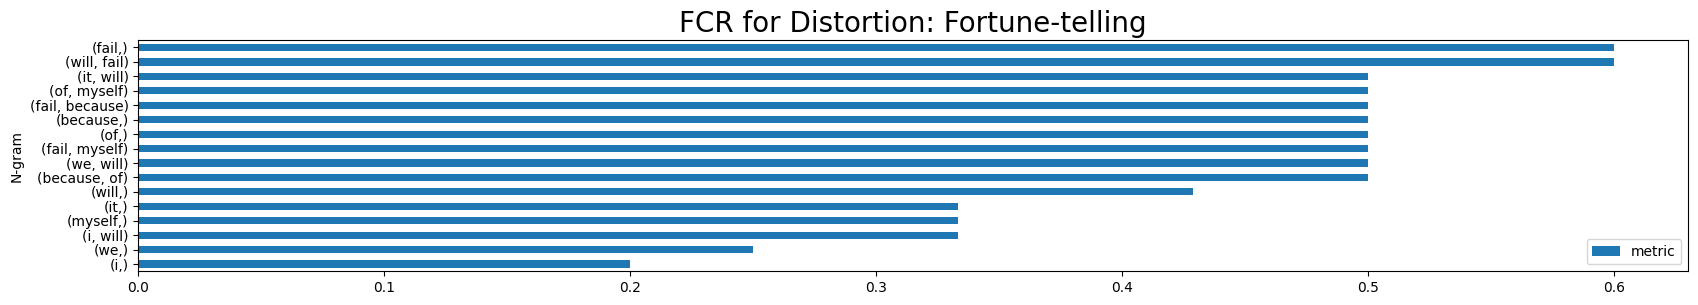

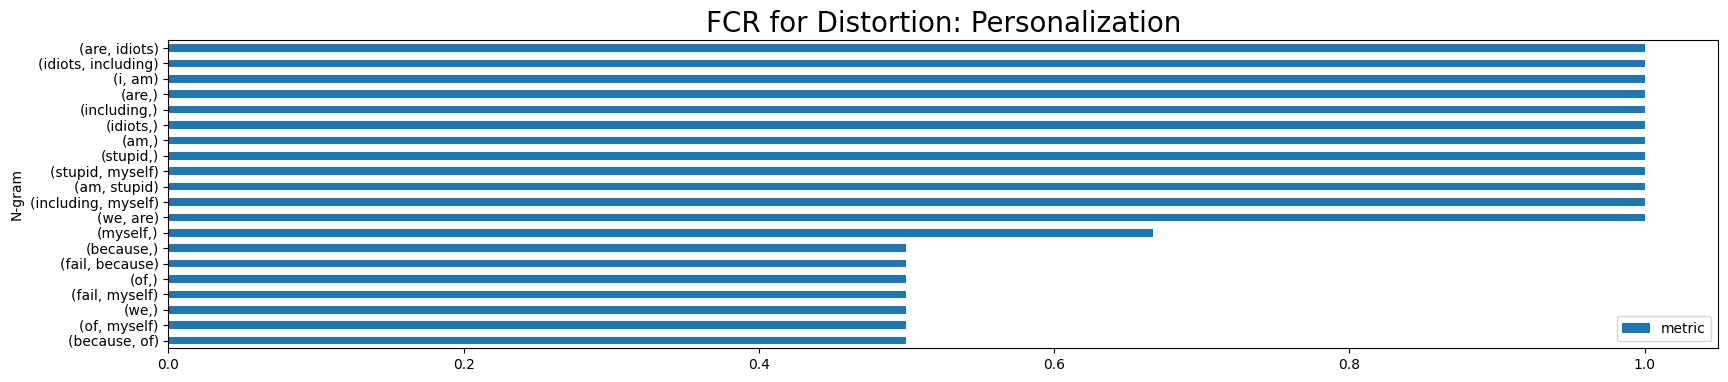

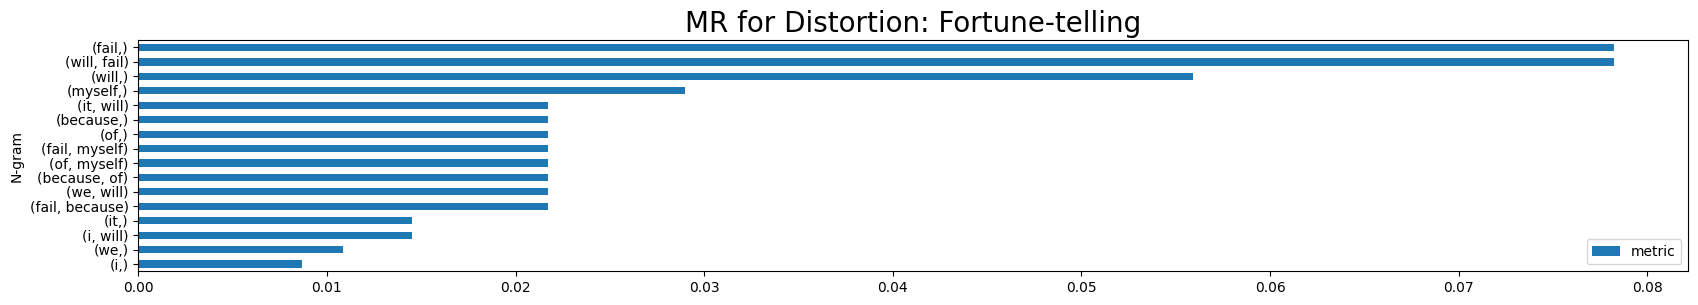

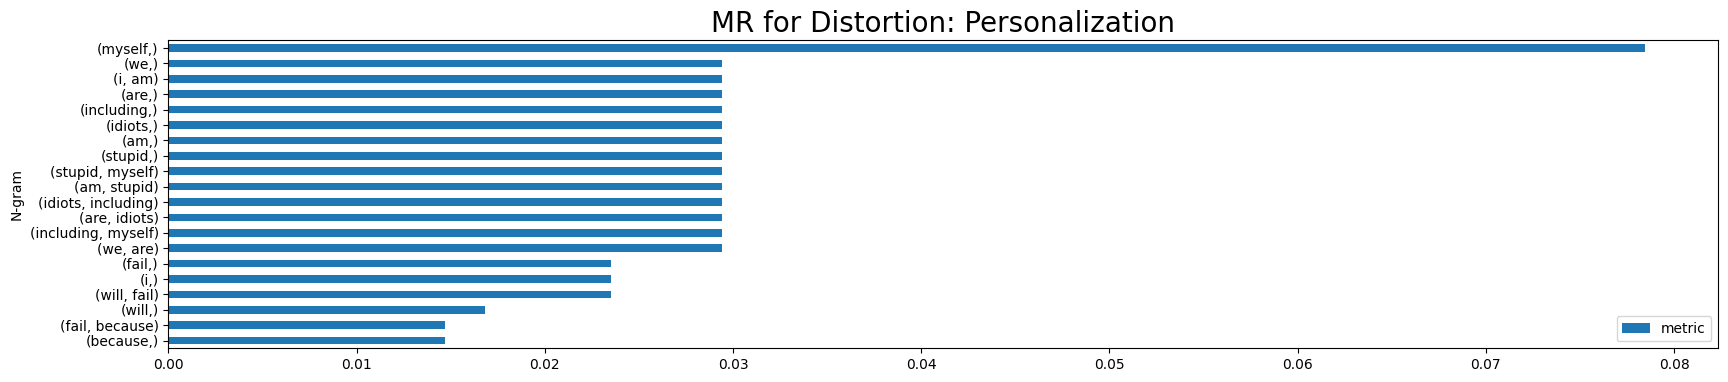

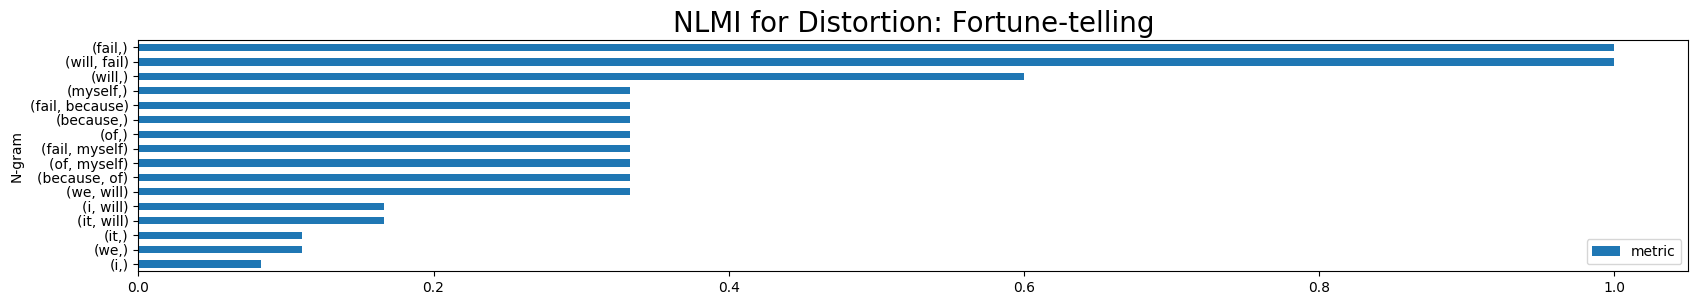

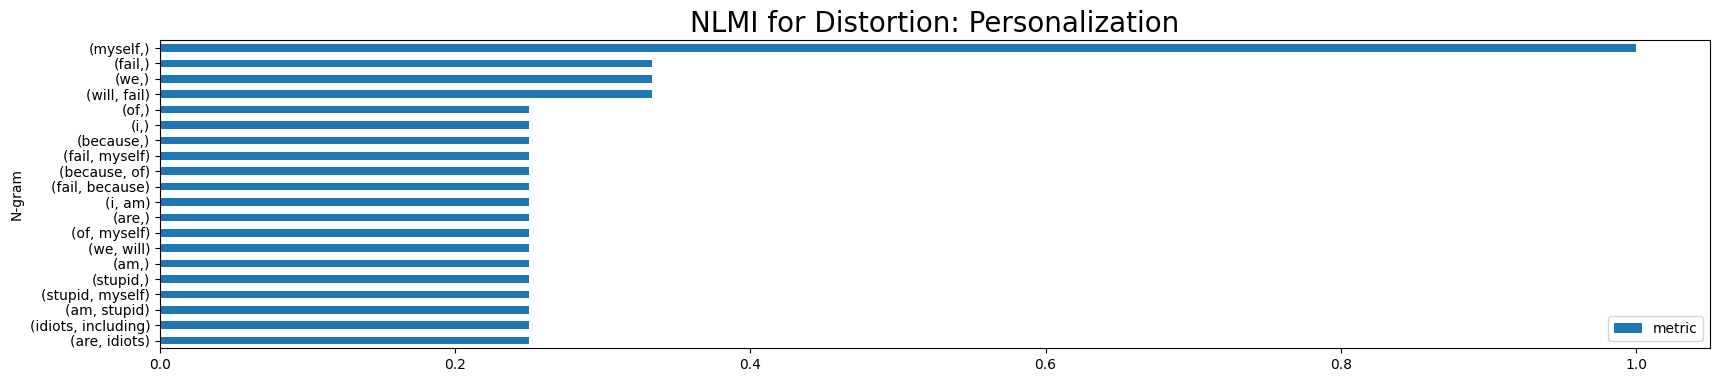

In [23]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1])

## Test on Binary Data

In [24]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)

distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,3)

for d1, d2 in zip(frequency_self_normalized, norm):
    assert( d1 == d2)
    for ng in frequency_self_normalized[d1]:
        assert( frequency_self_normalized[d1][ng] == norm[d2][ng] )

for d in unique_frequency:
    for ng in unique_frequency[d]:
        assert(unique_frequency[d][ng] == n_gram_distortions[ng][d] )


In [25]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

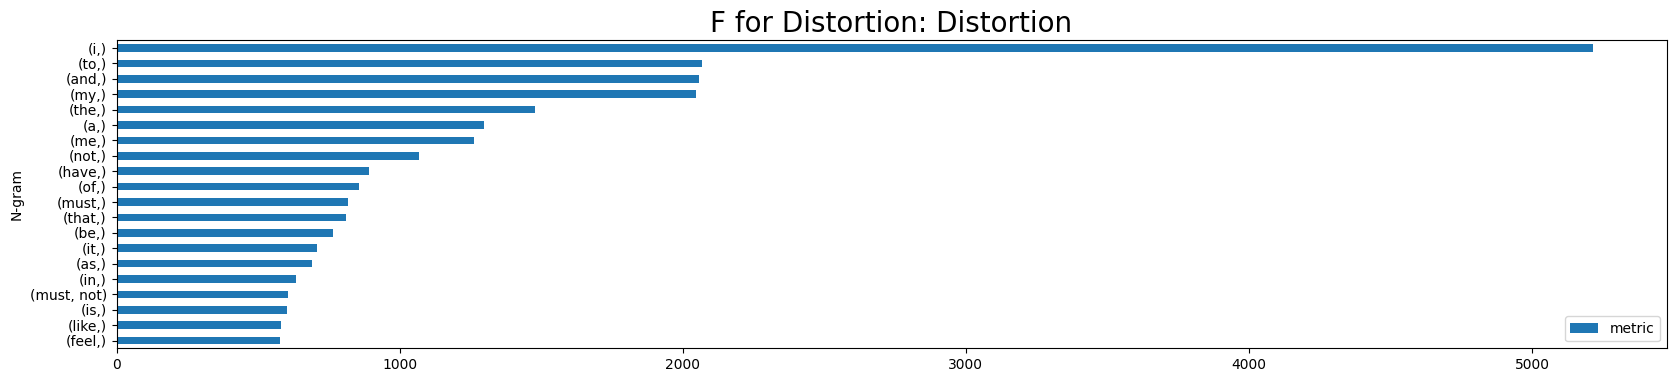

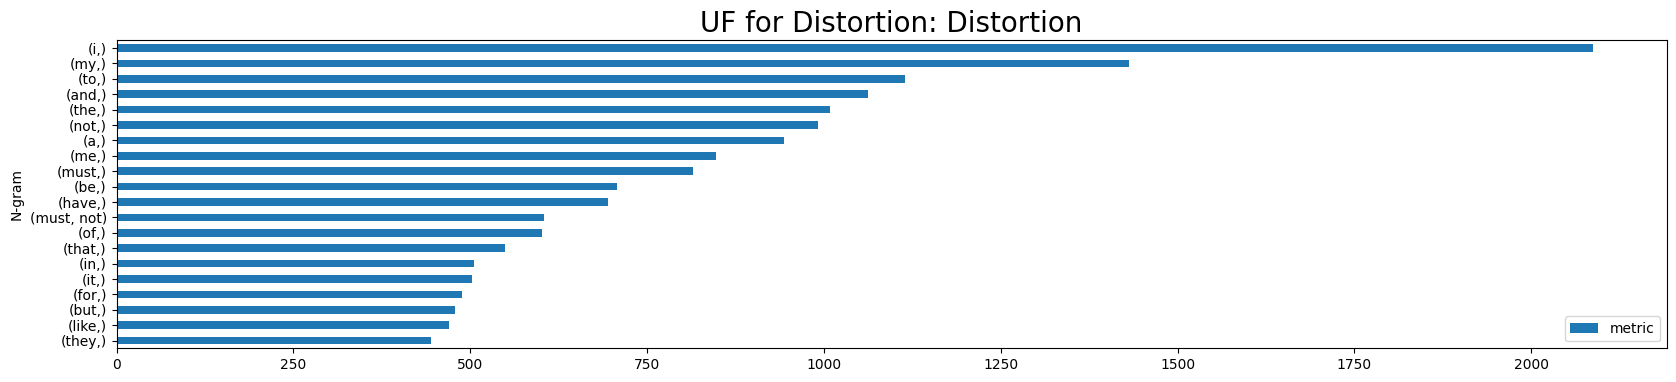

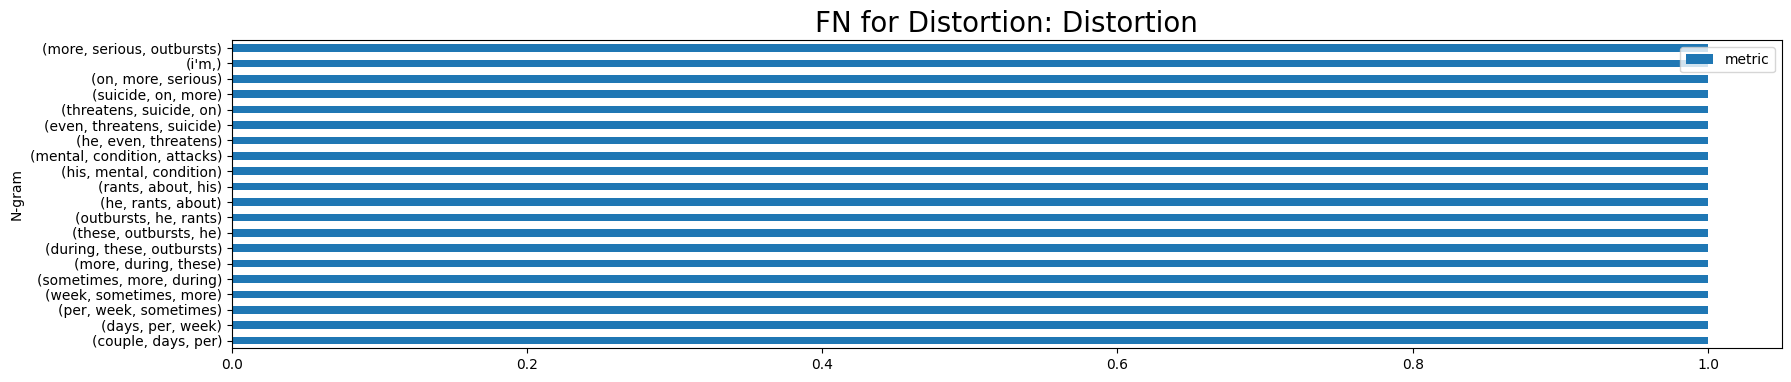

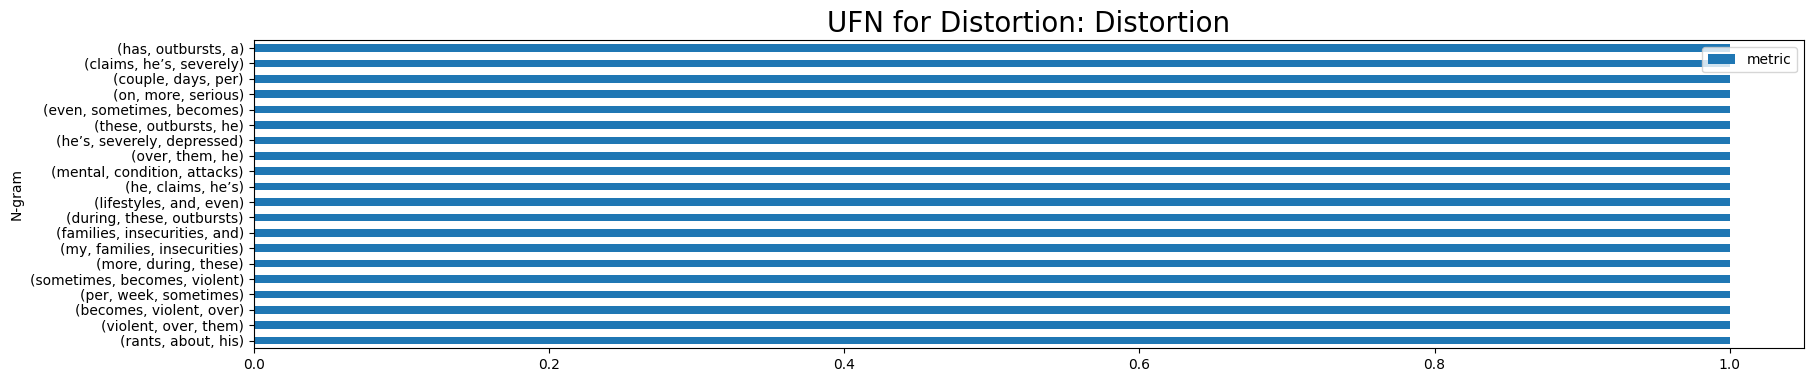

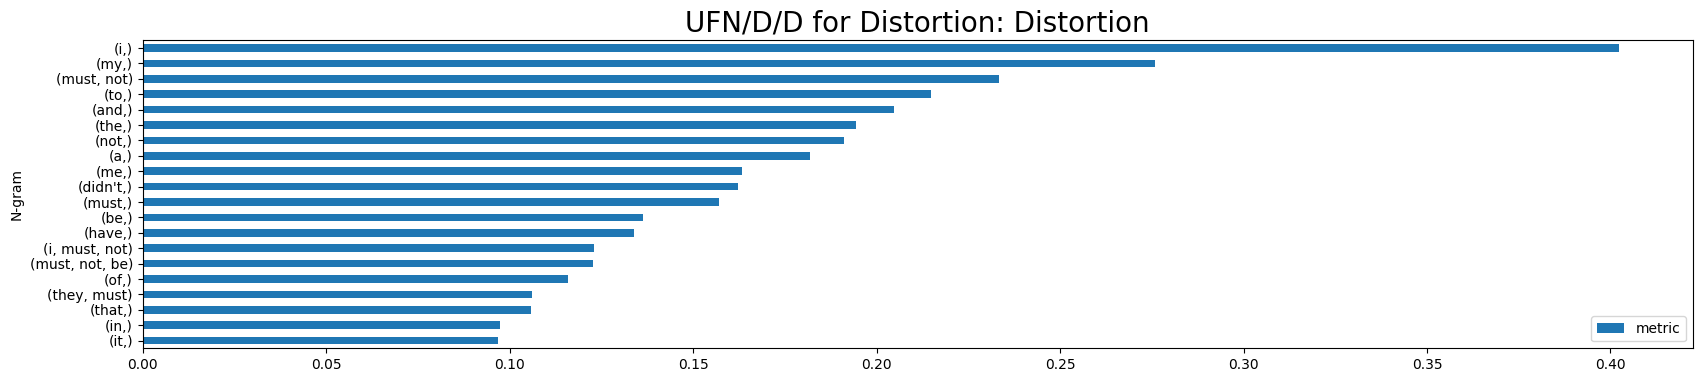

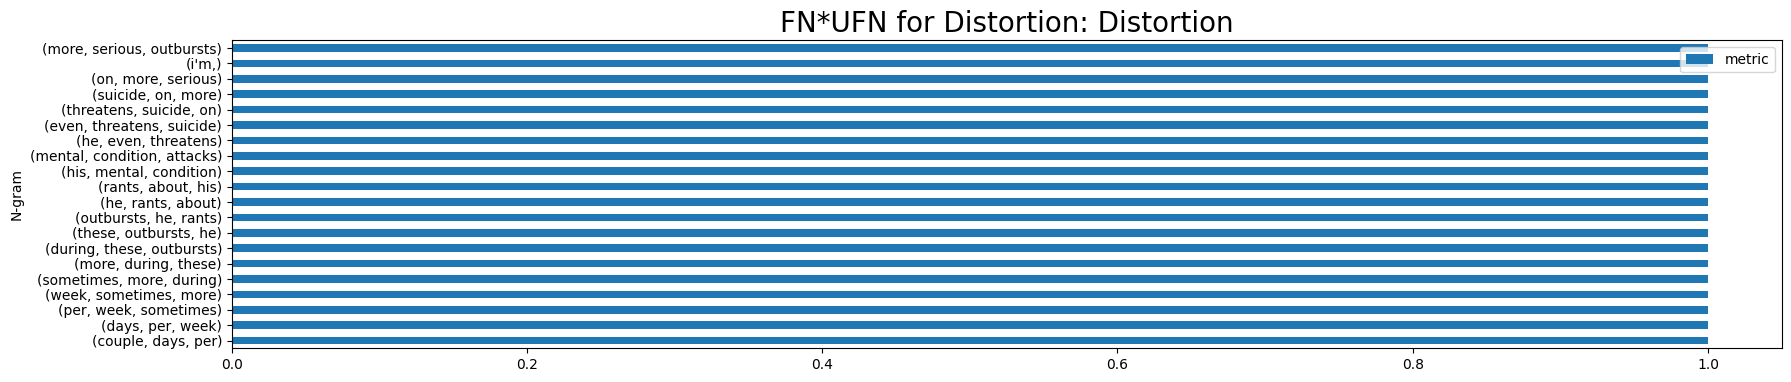

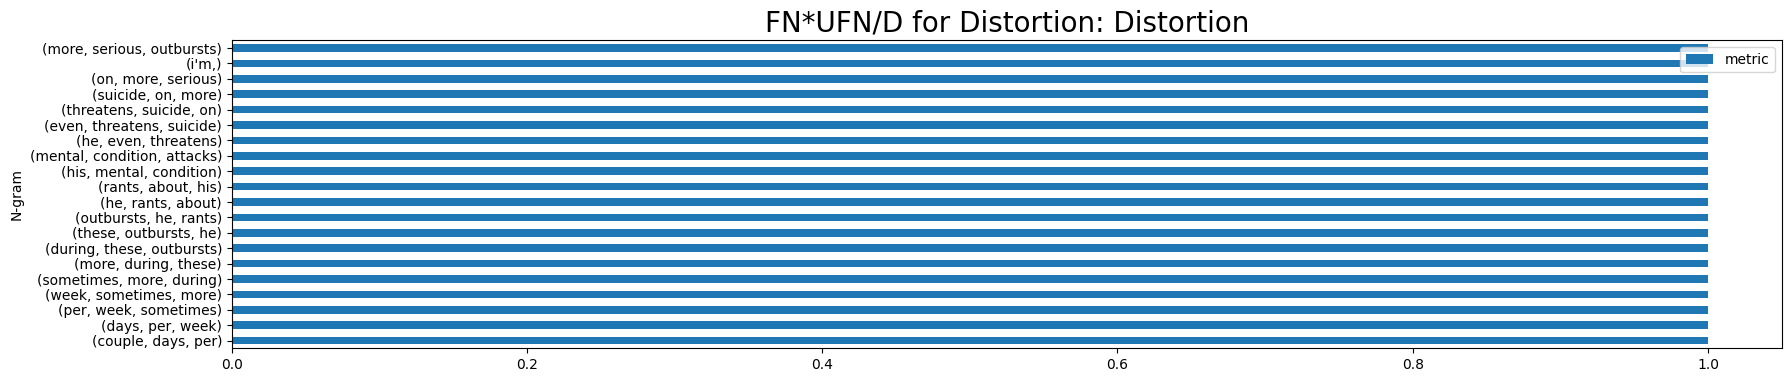

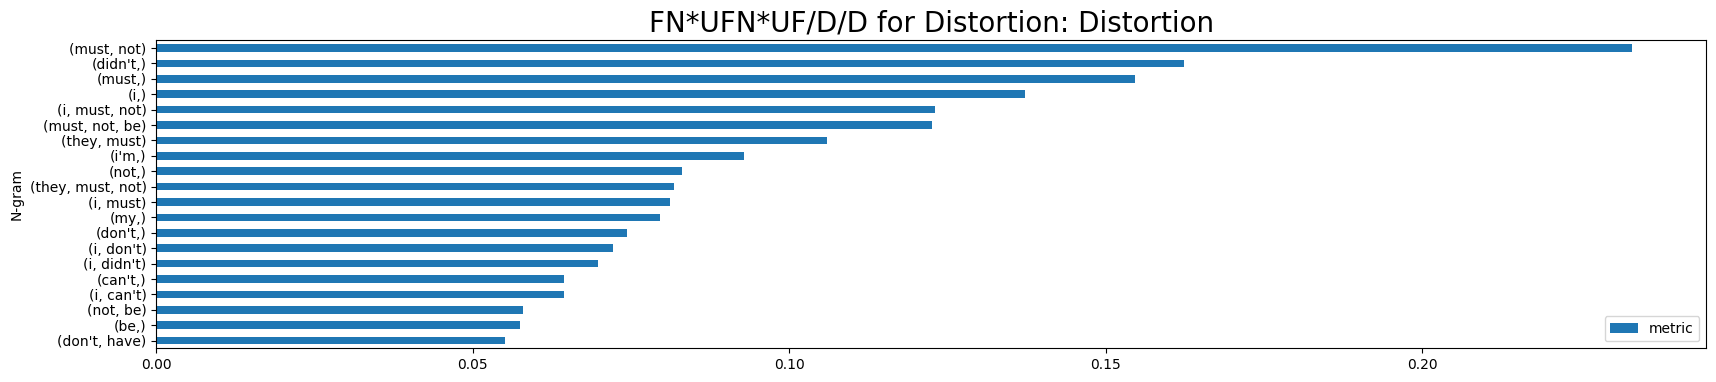

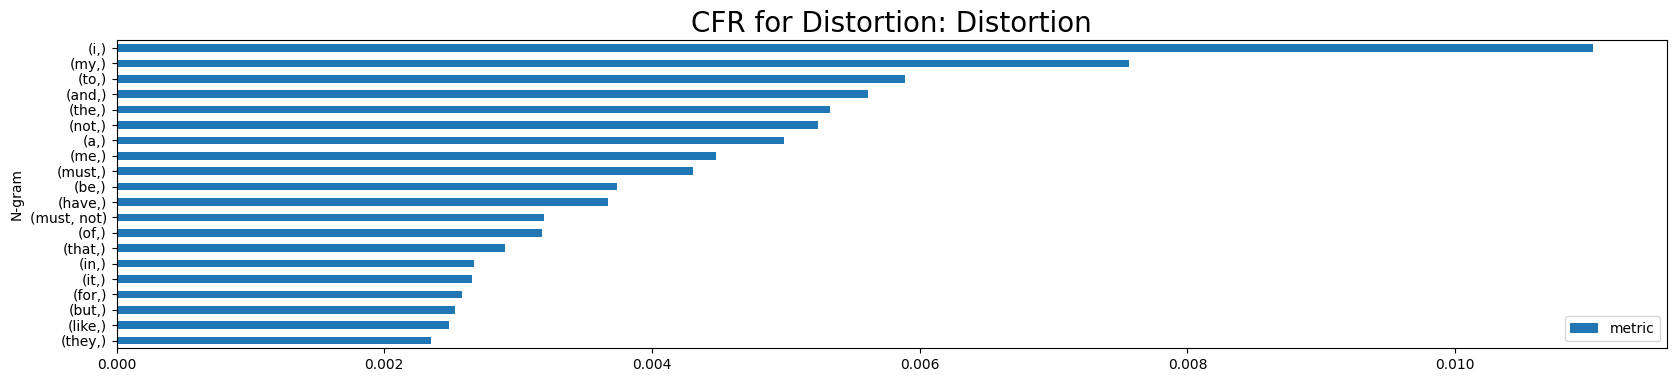

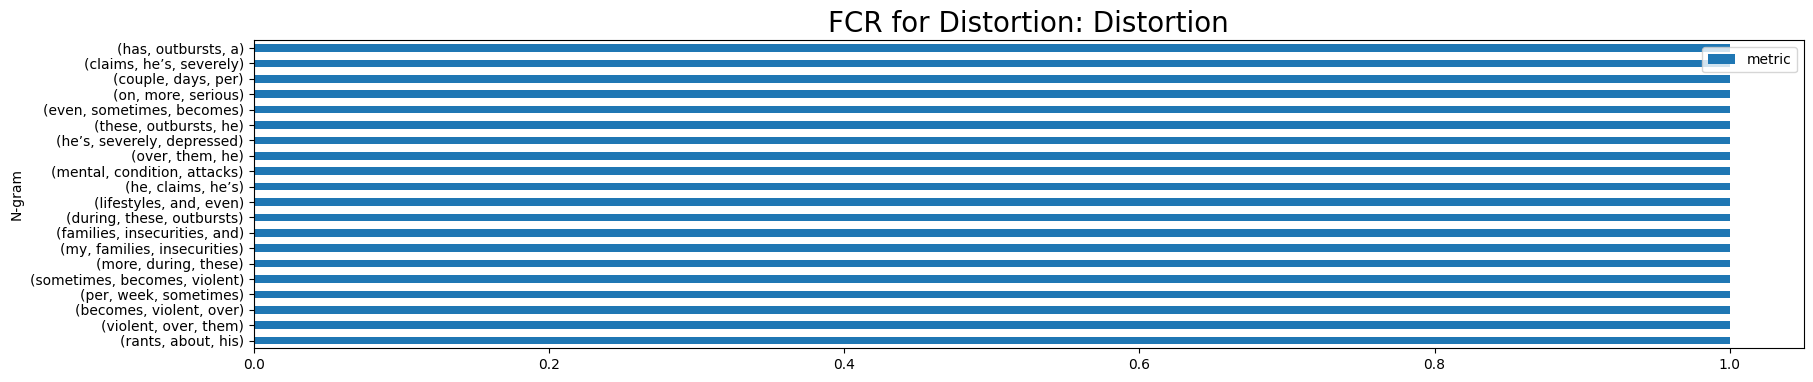

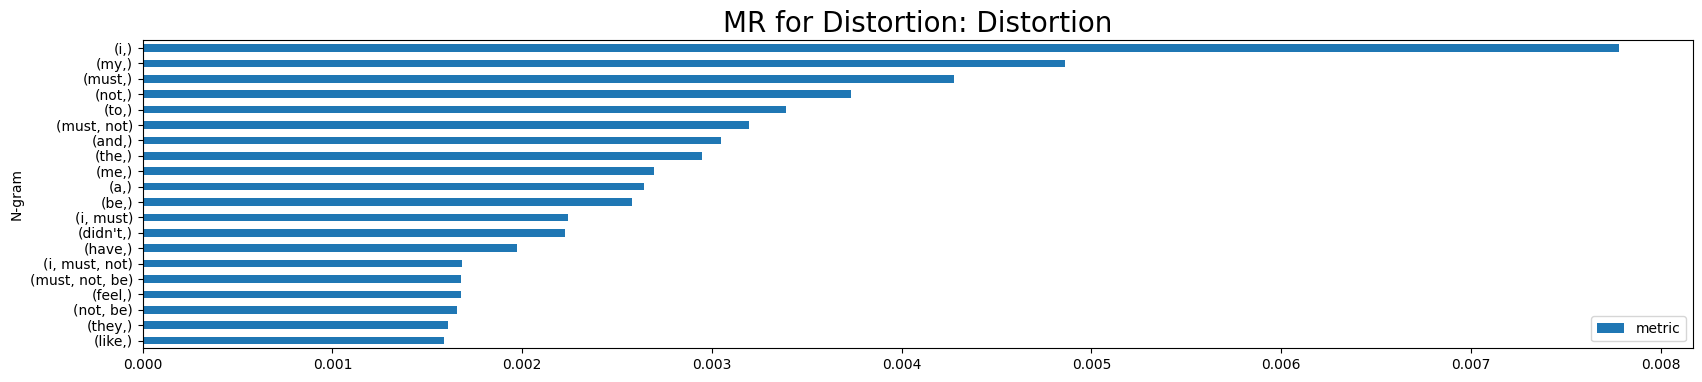

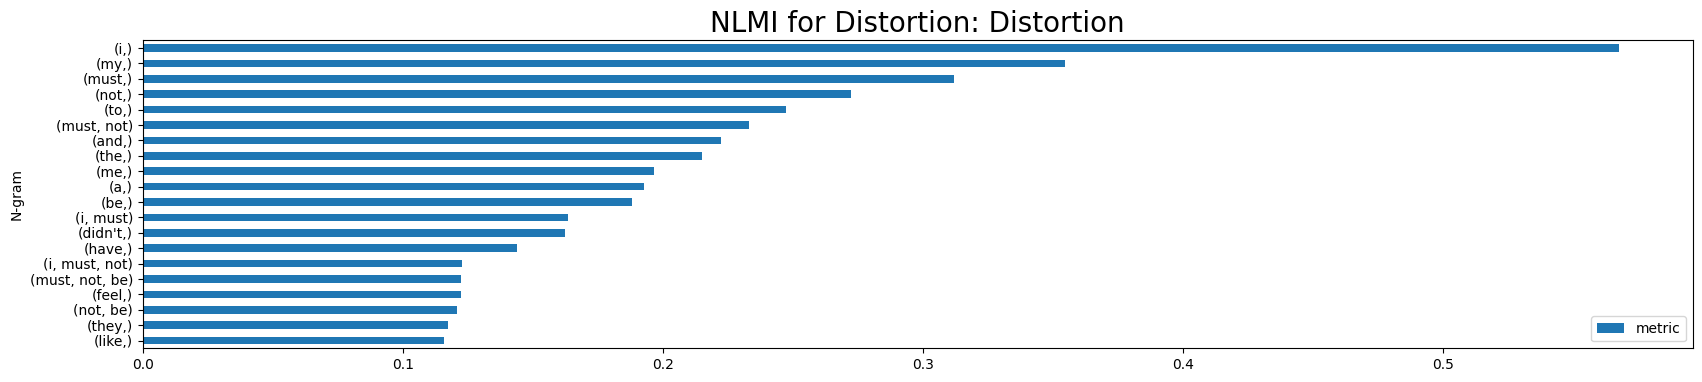

In [26]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1],head = 20)

## Test on Multi-Class Data 

In [27]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df

distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, norm_uniq, norm_norm_uniq, norm_norm_uniq_norm, norm_norm_uniq_norm_norm, \
fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,3)

In [31]:
df

Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

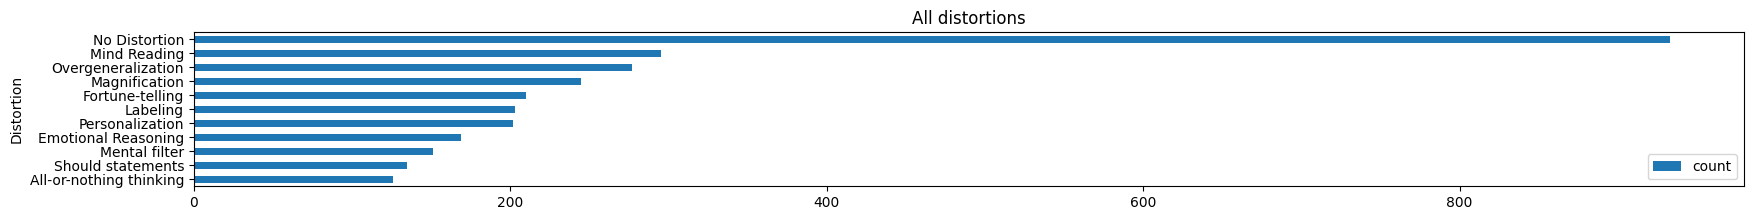

In [28]:
# Display graphs for all distortions
plot_dict(
            distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
        )


In [29]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

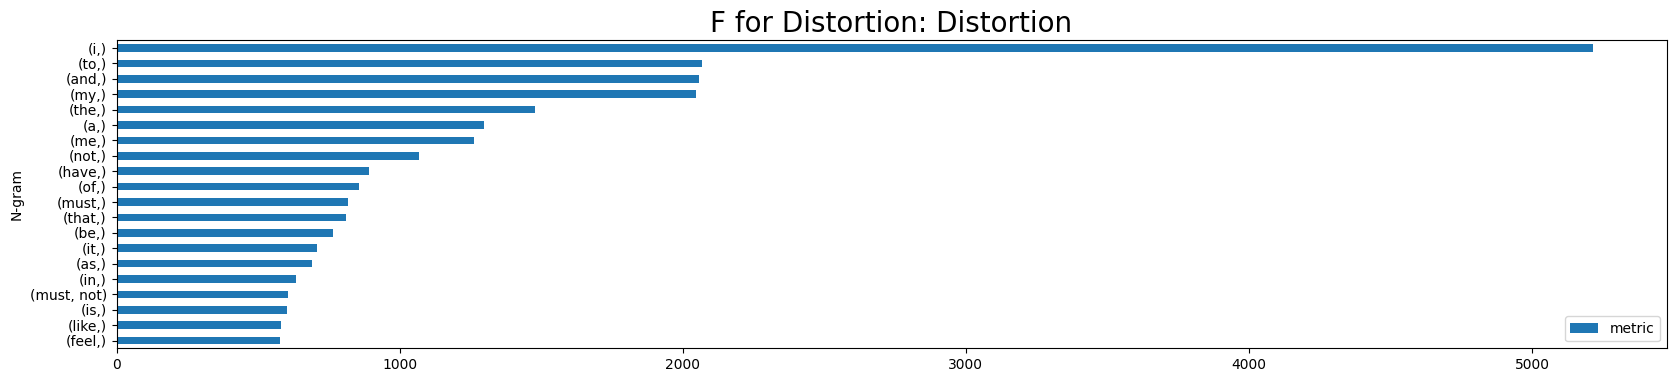

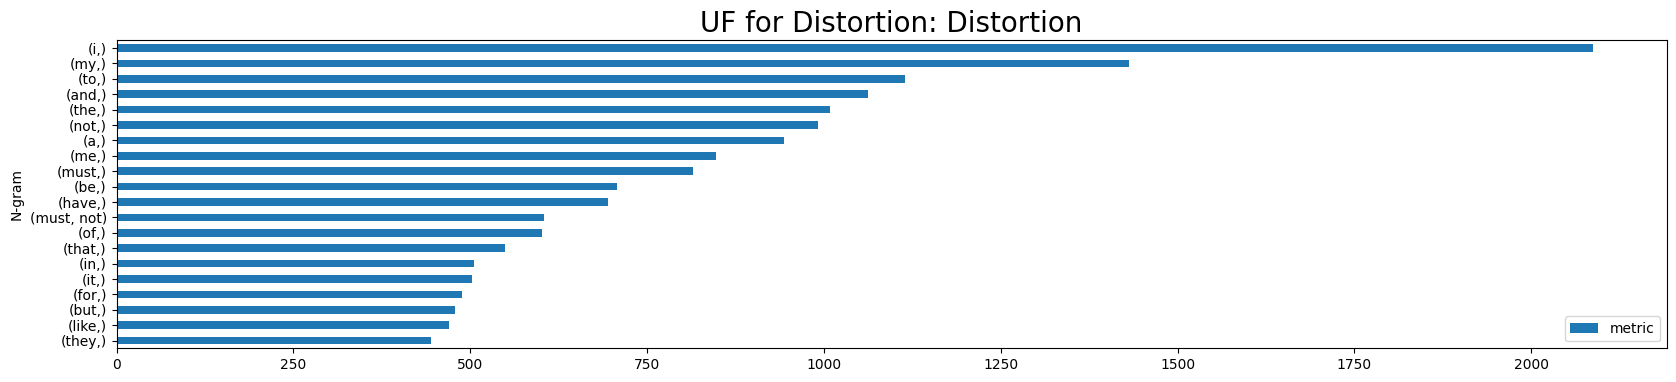

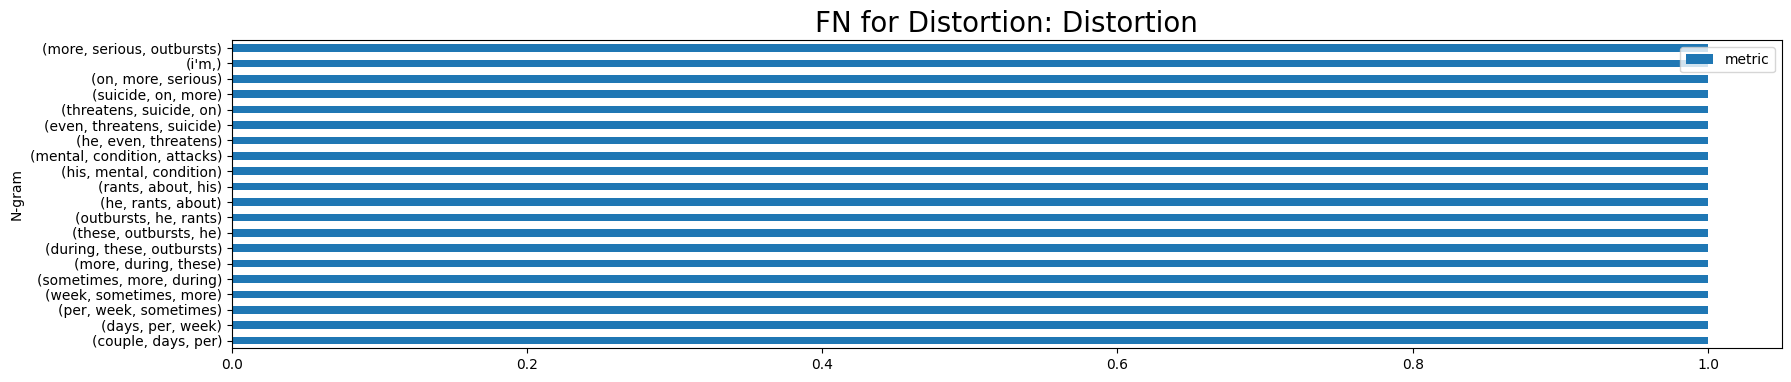

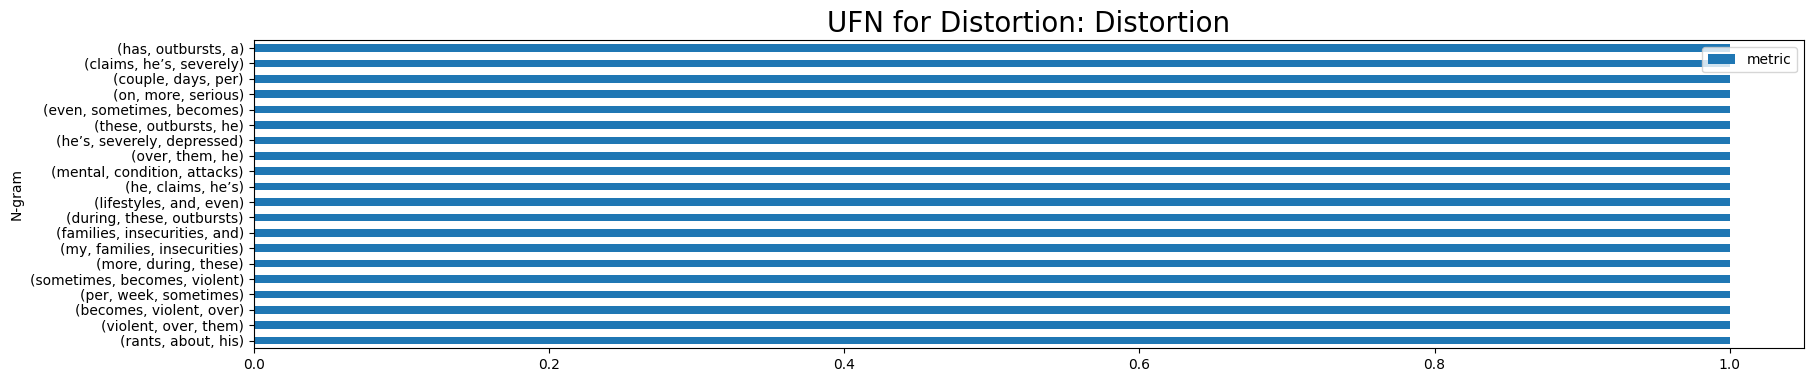

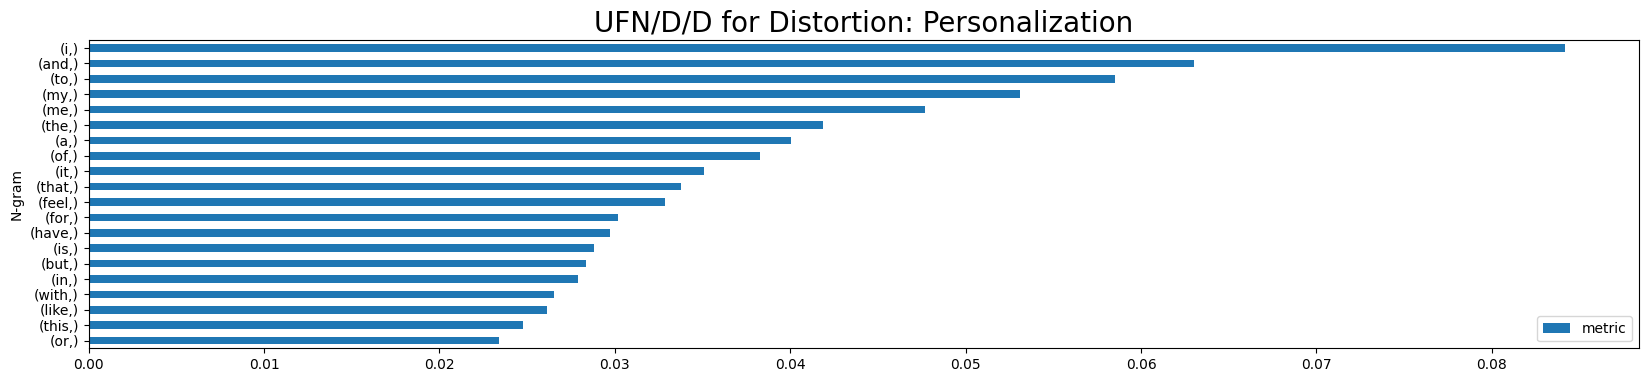

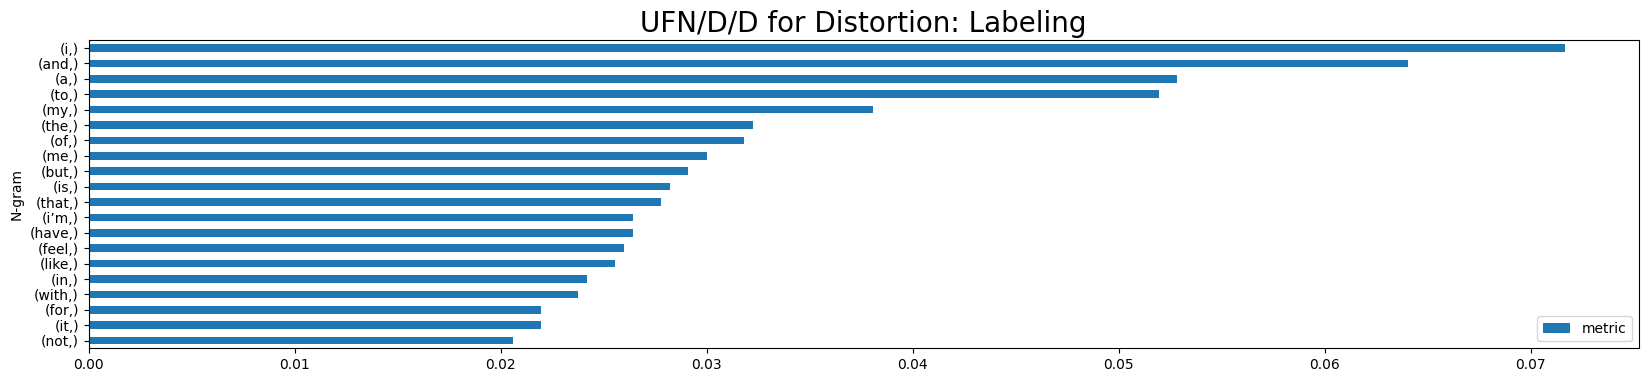

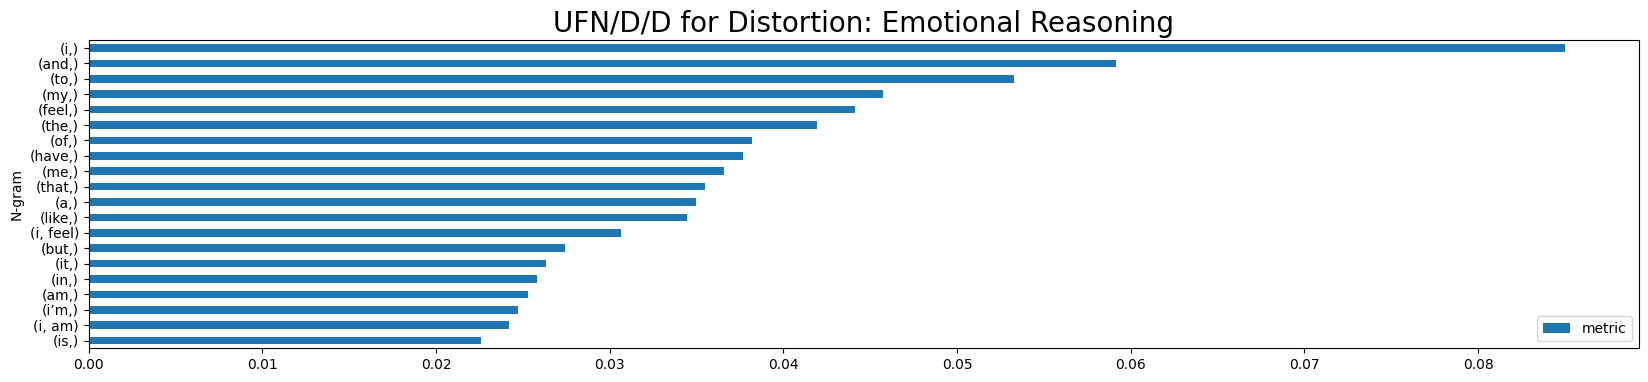

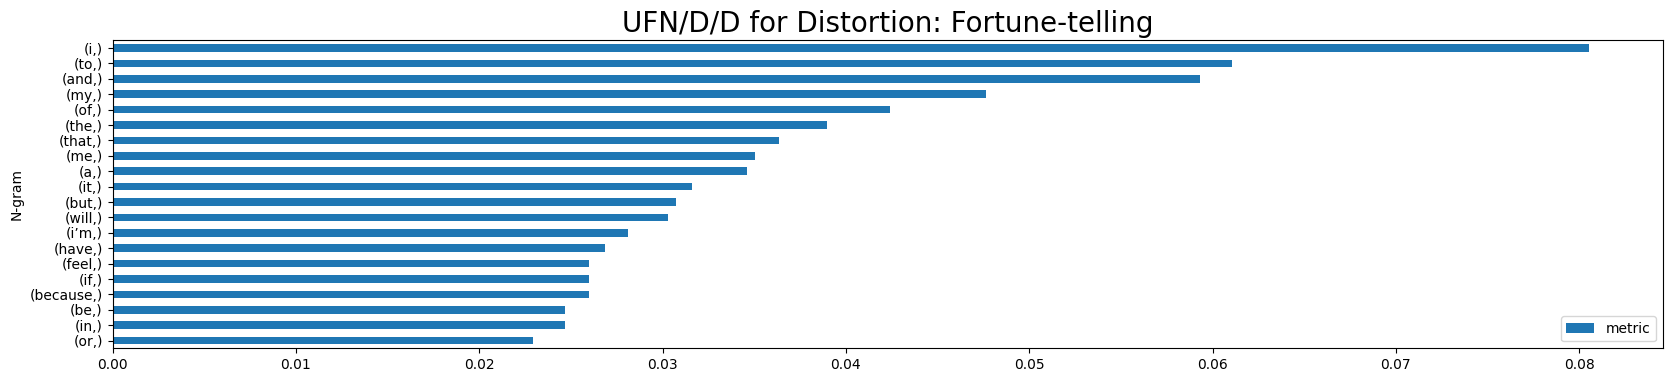

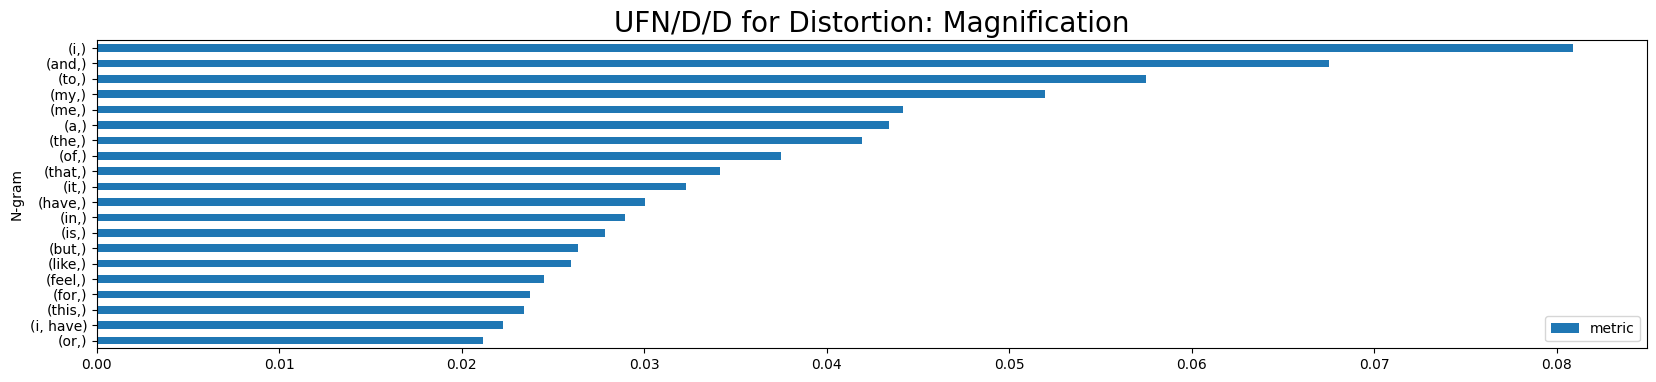

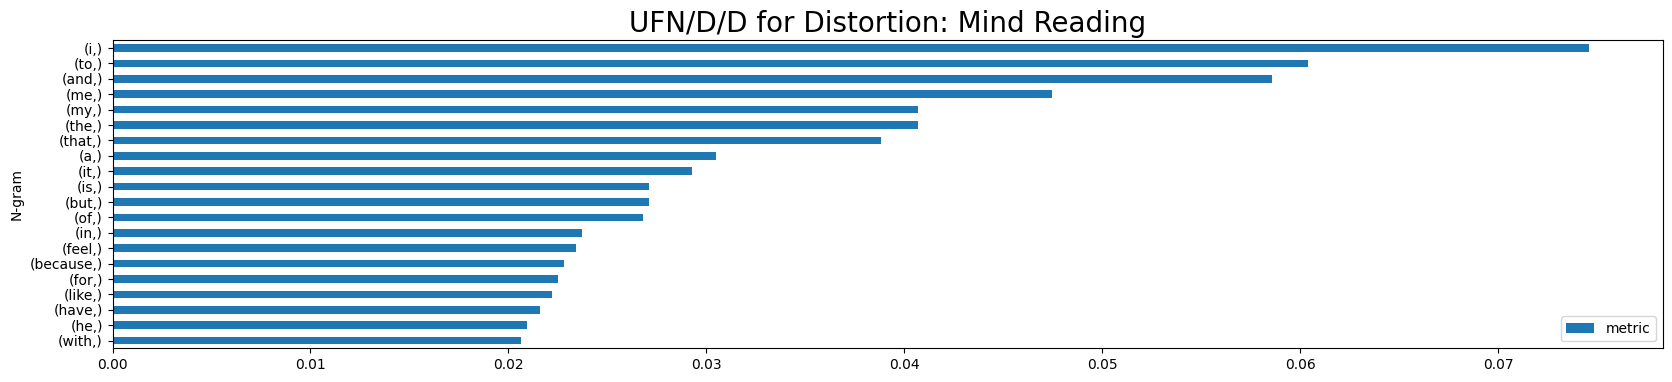

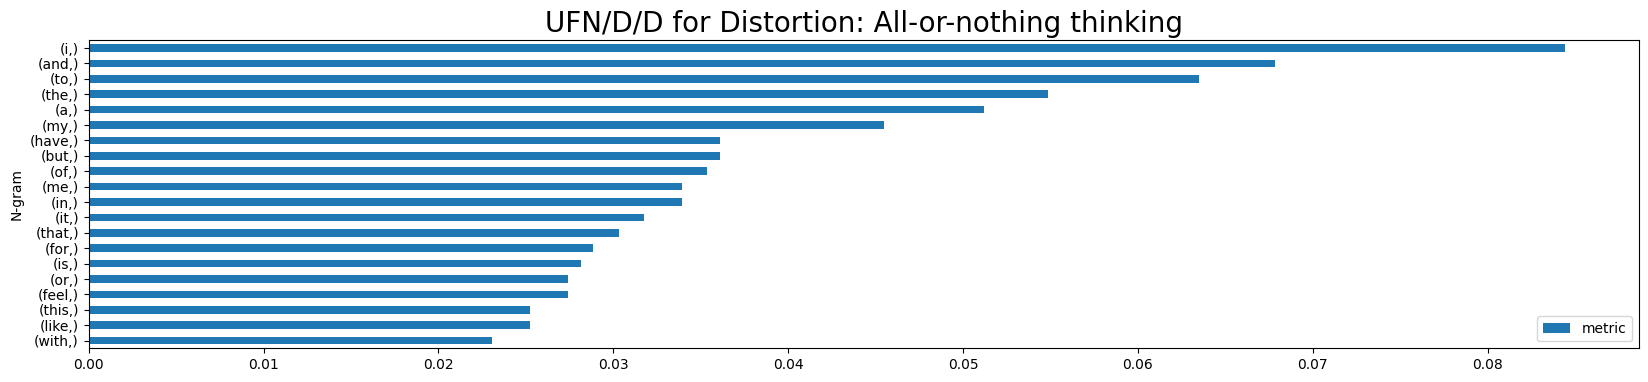

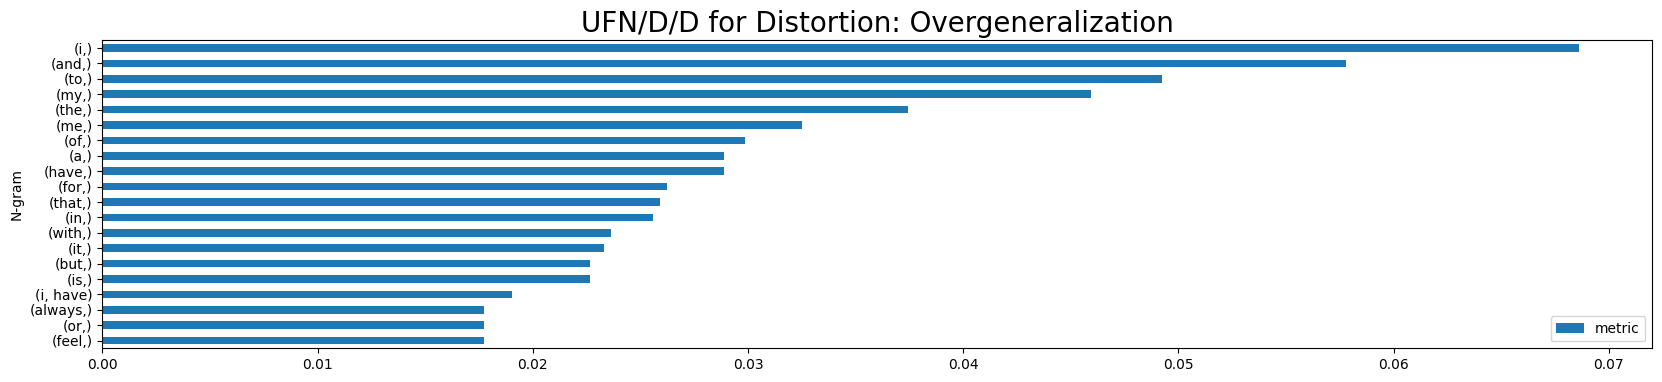

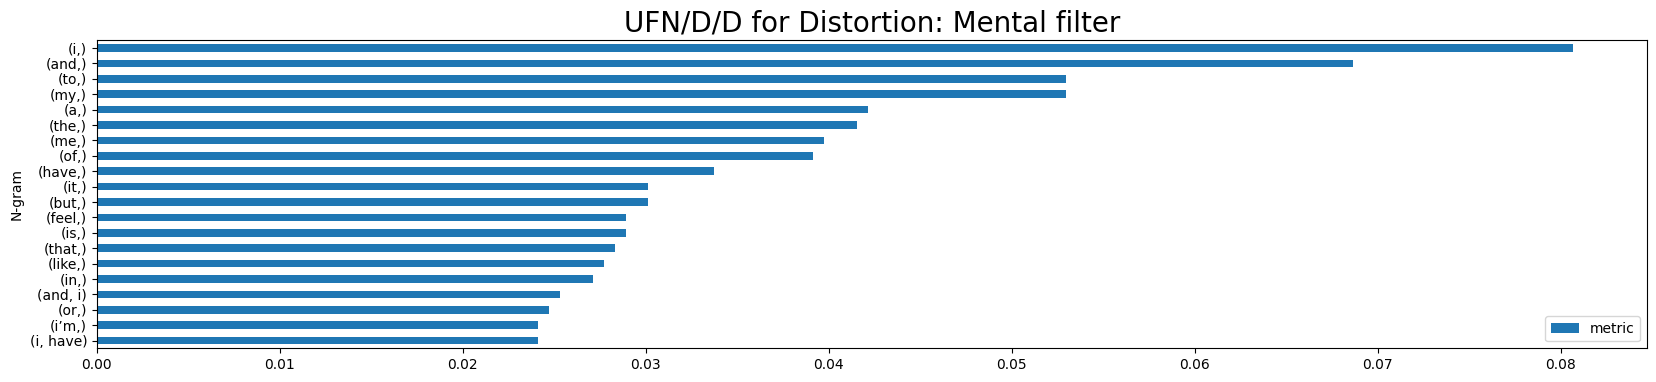

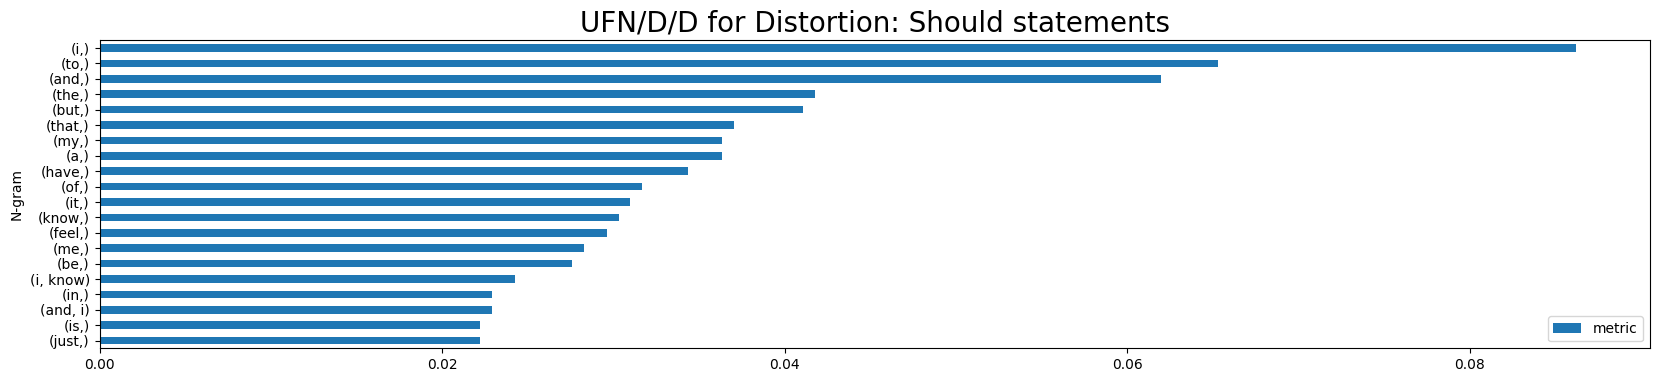

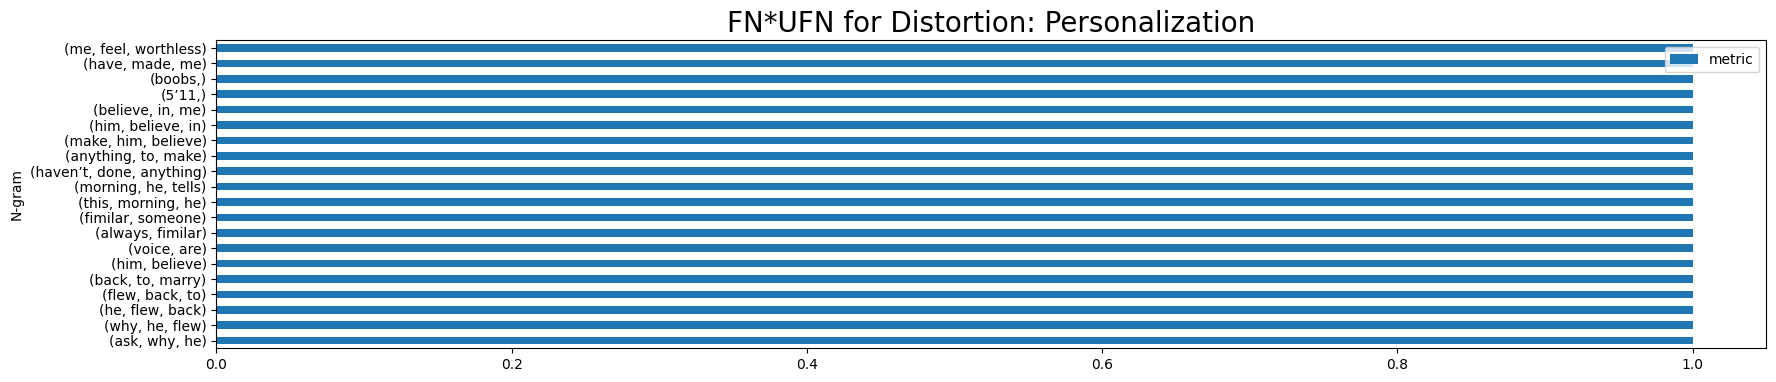

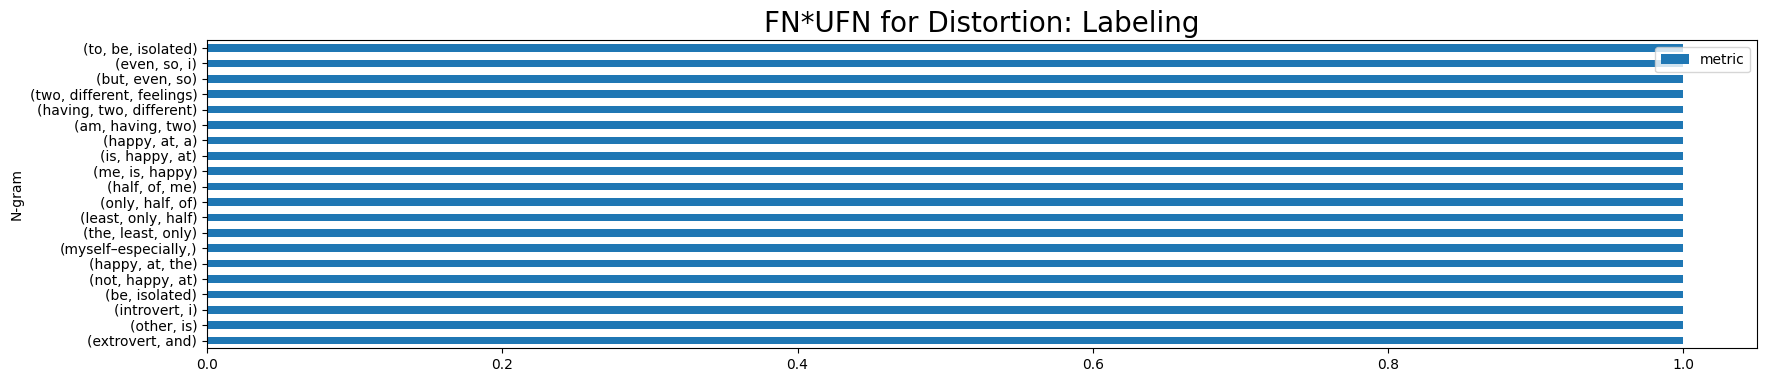

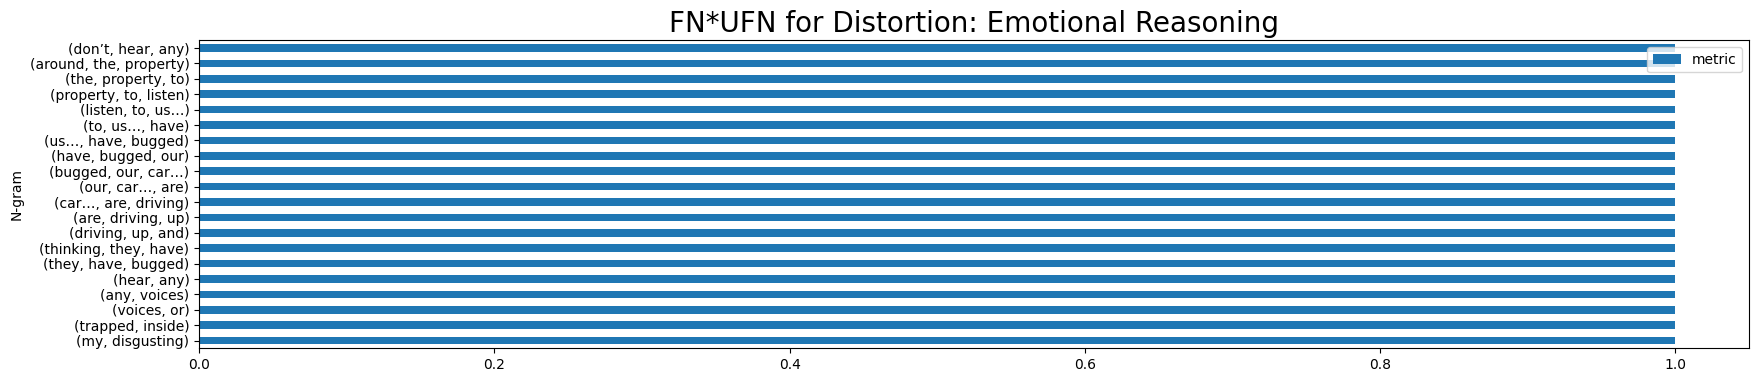

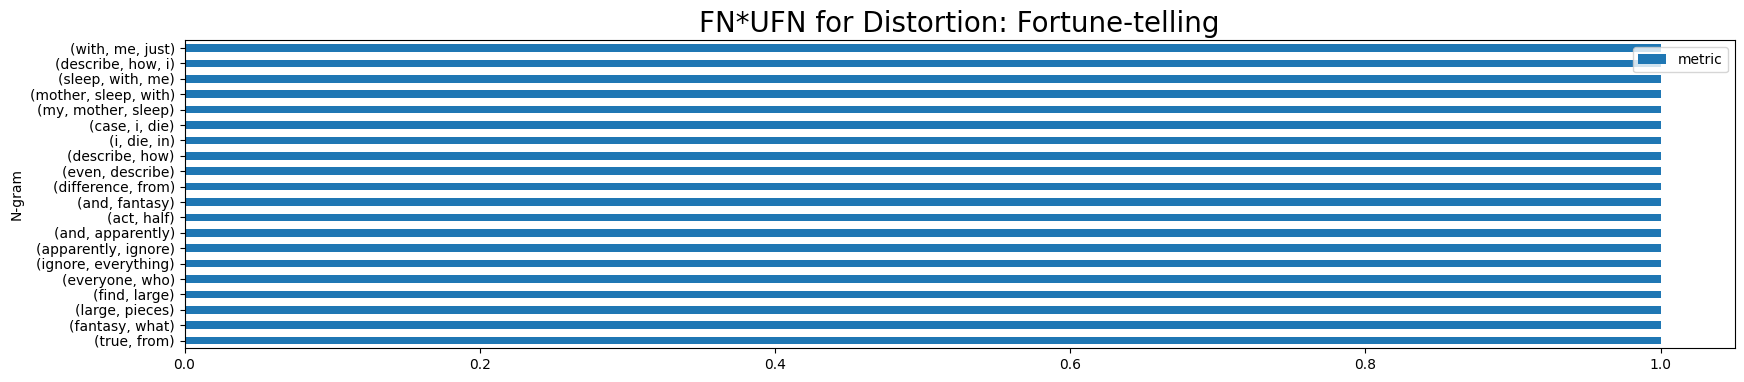

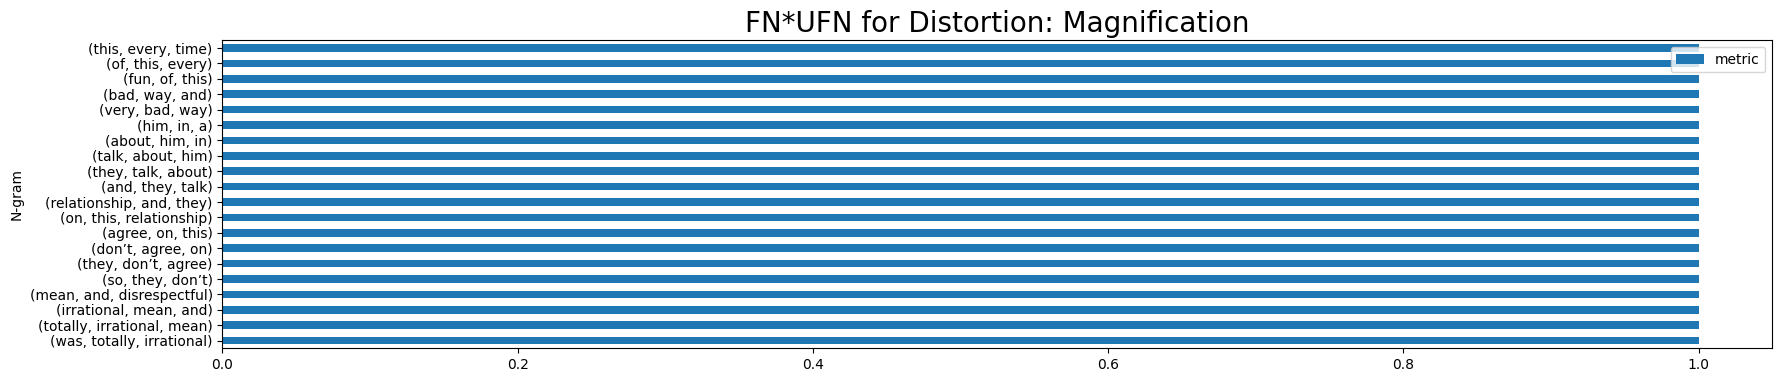

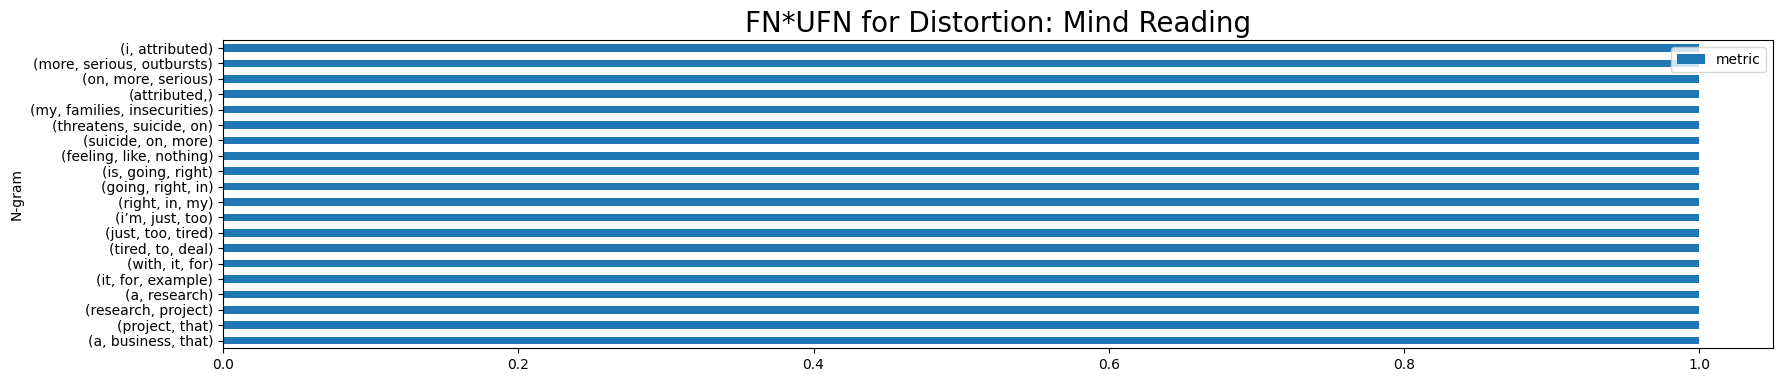

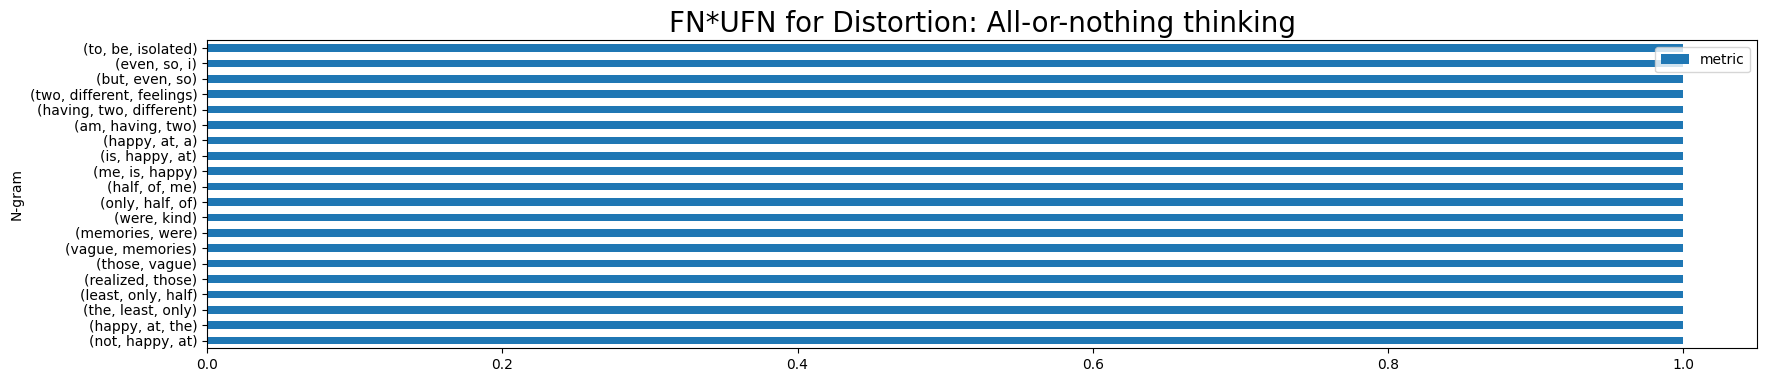

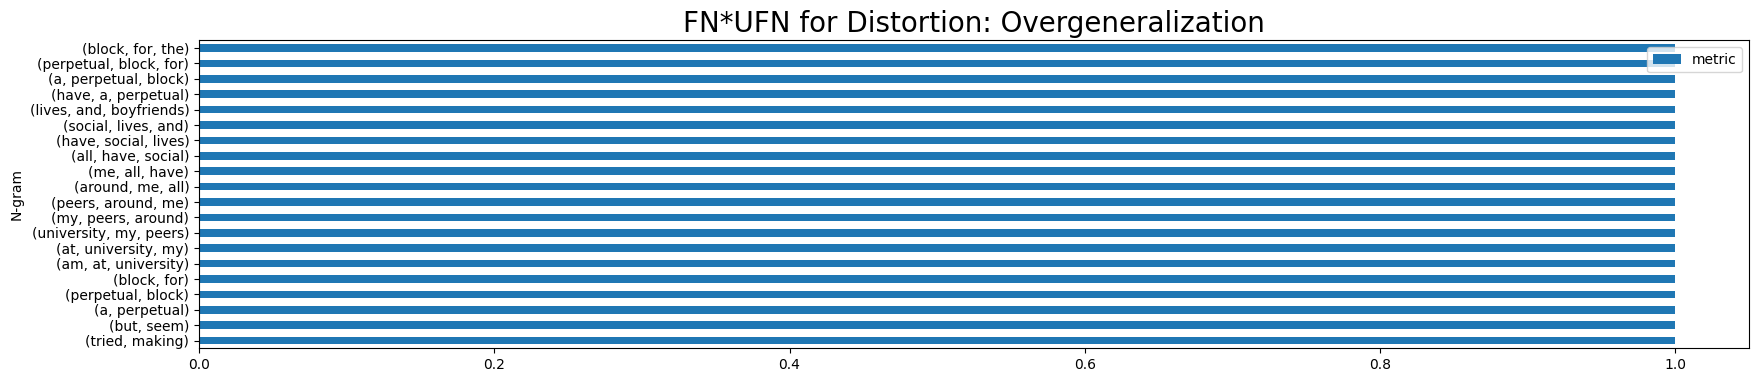

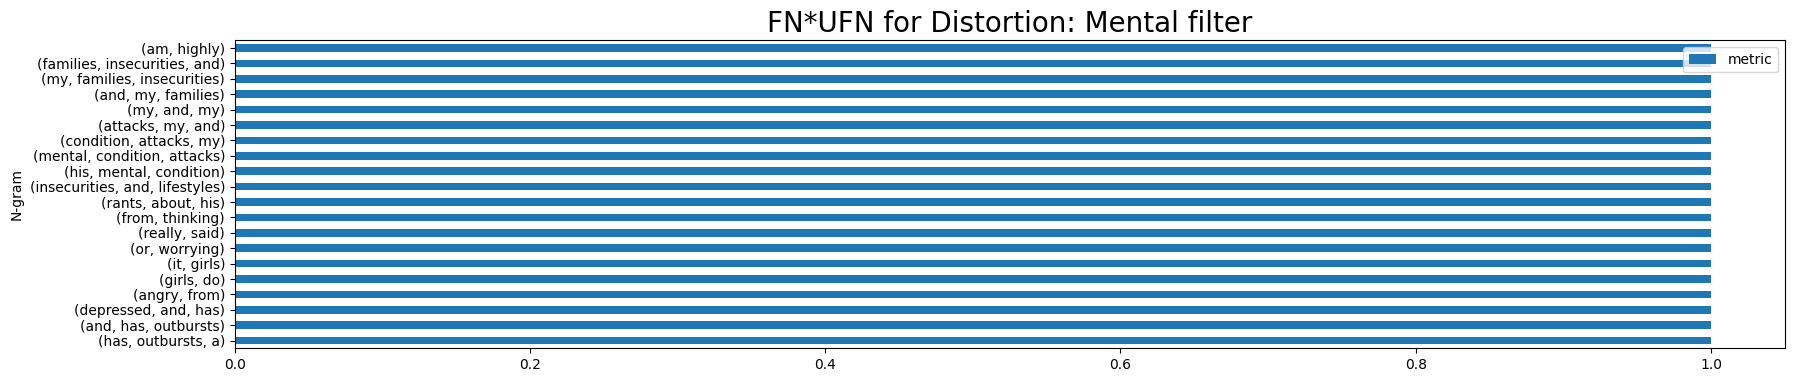

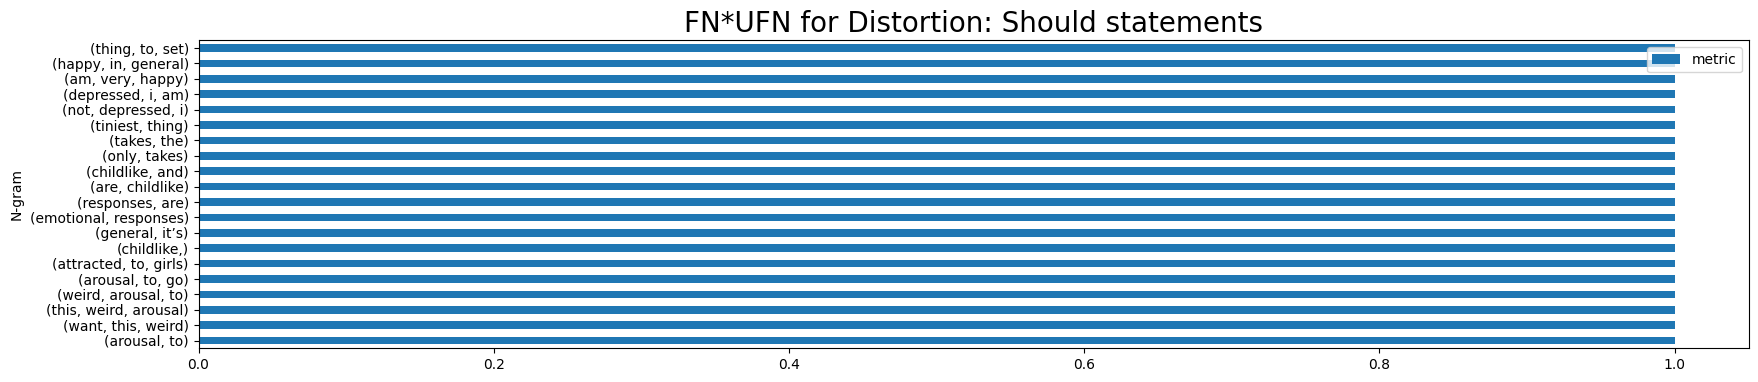

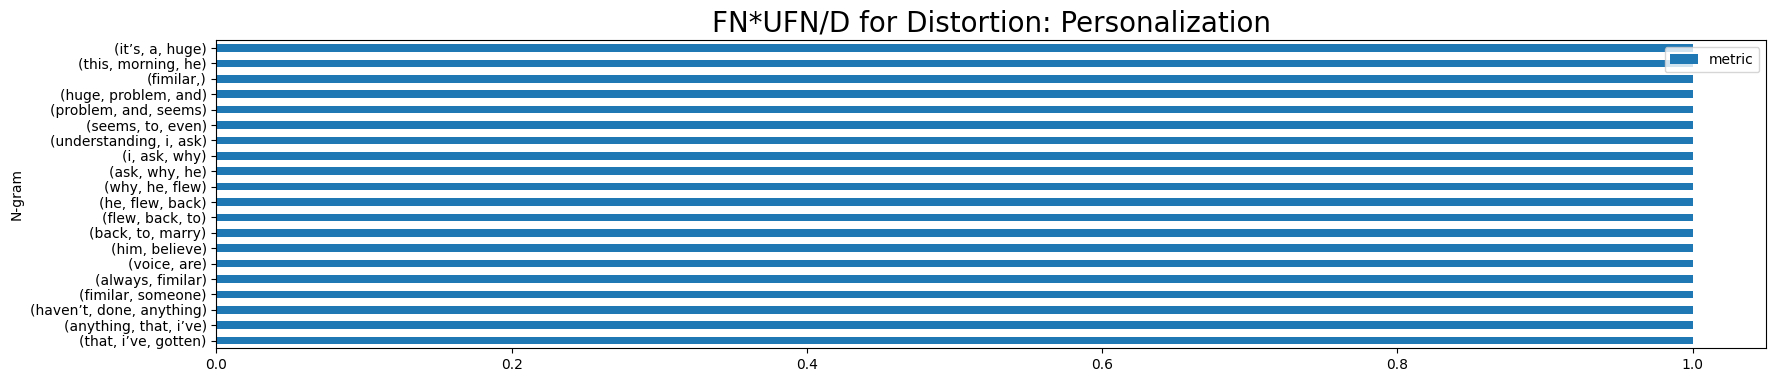

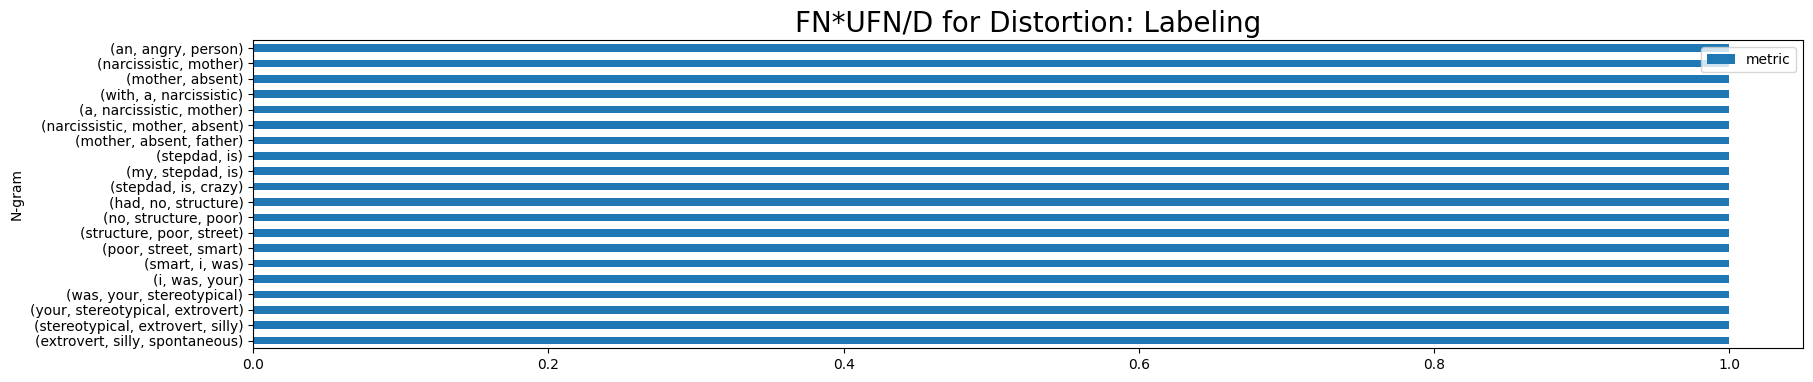

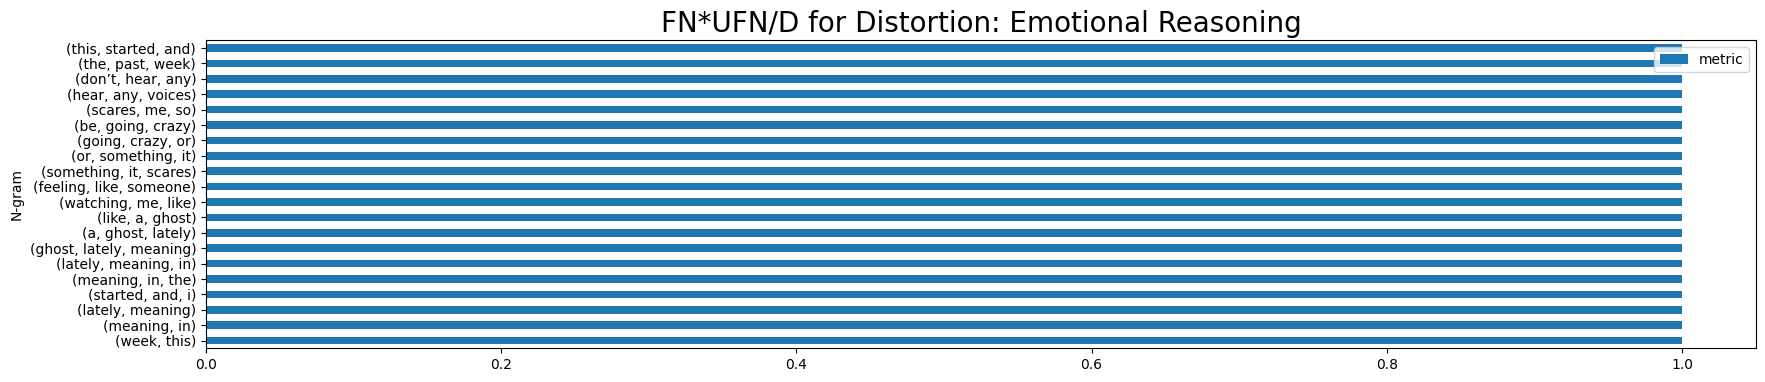

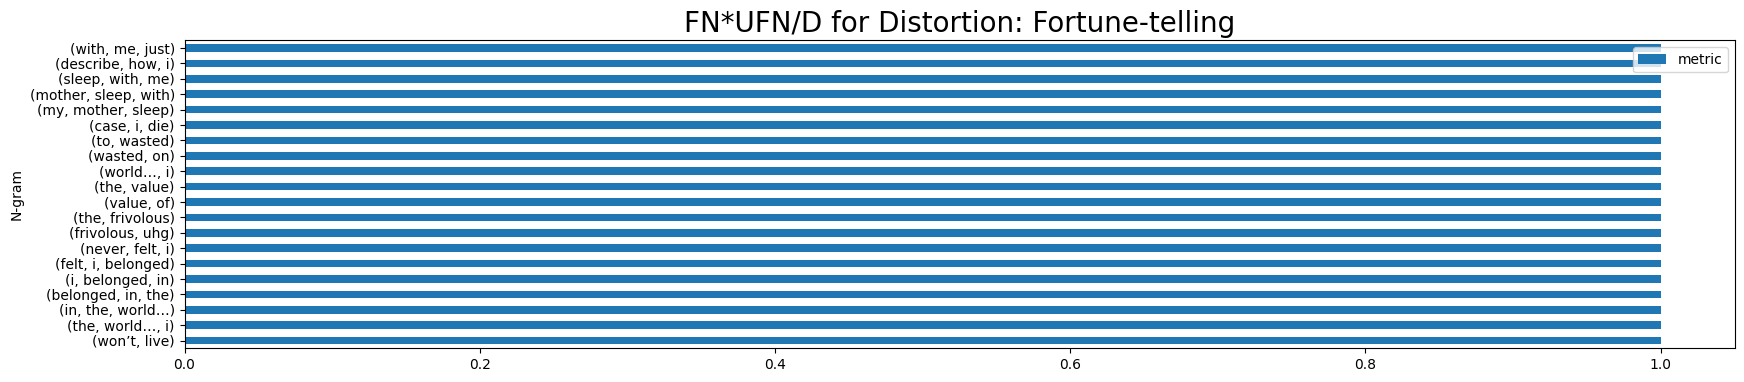

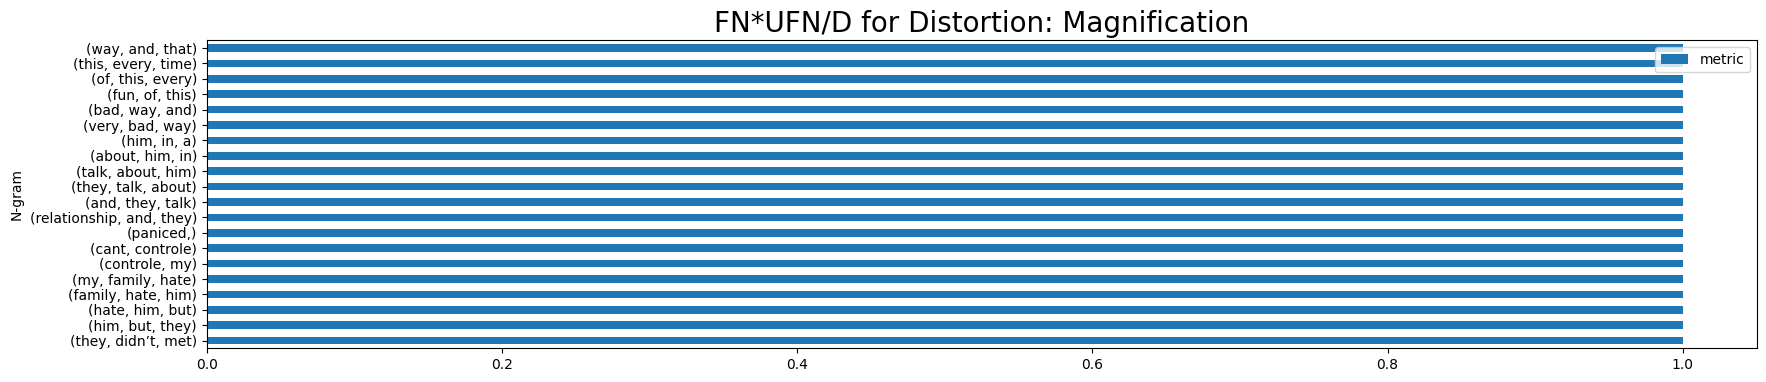

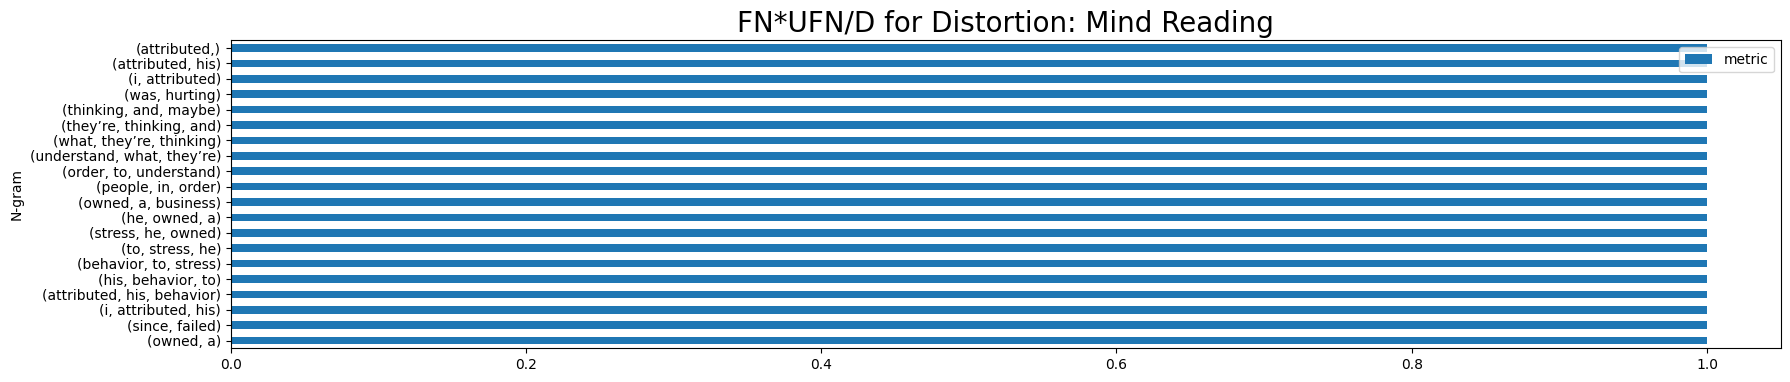

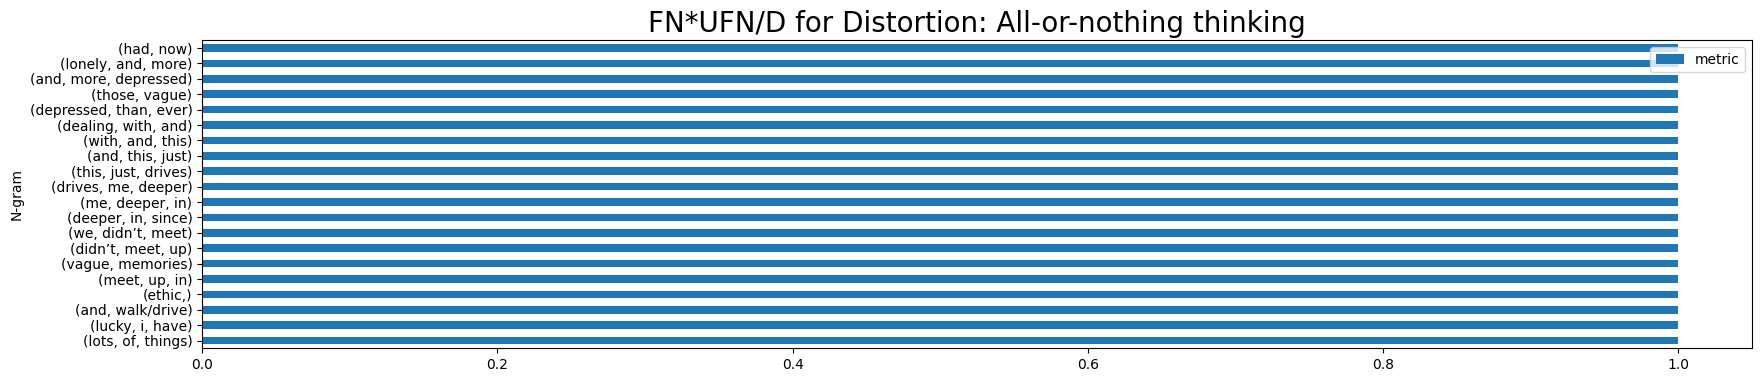

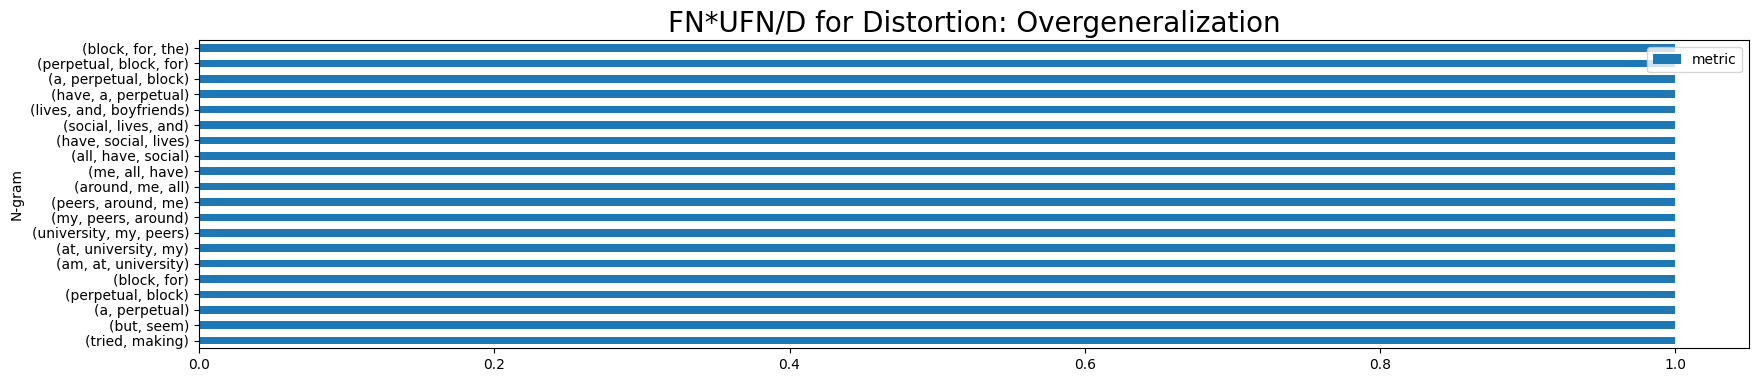

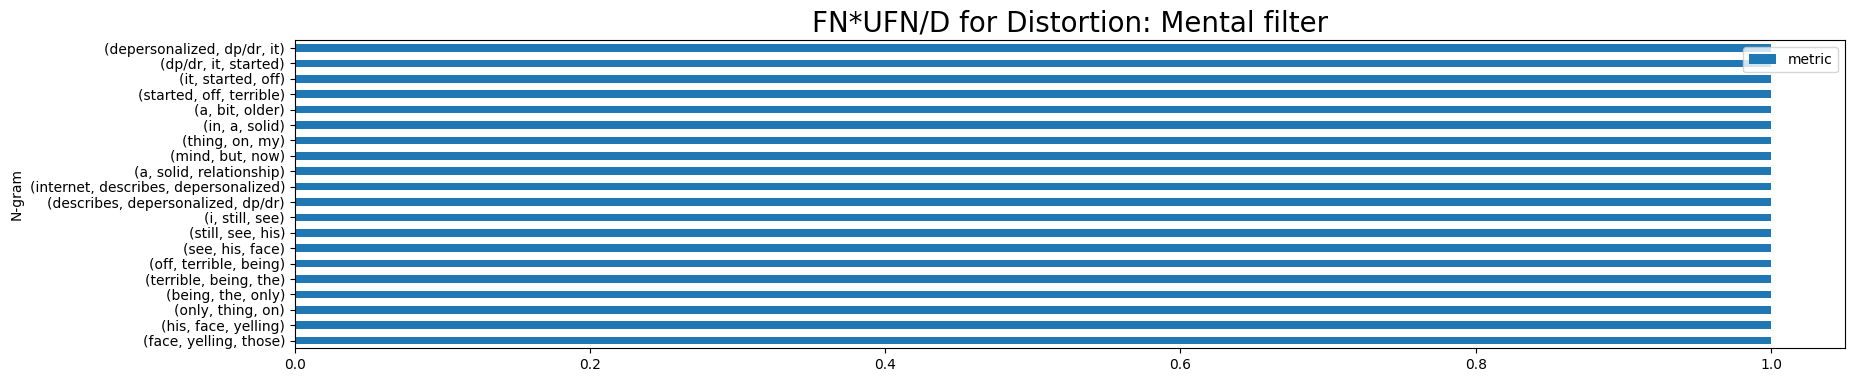

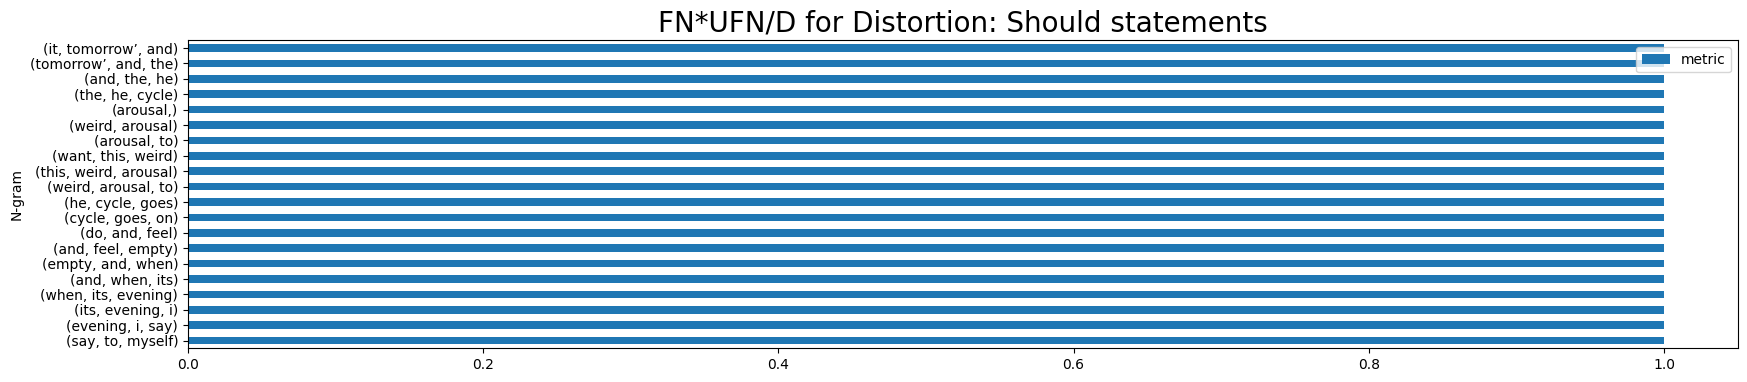

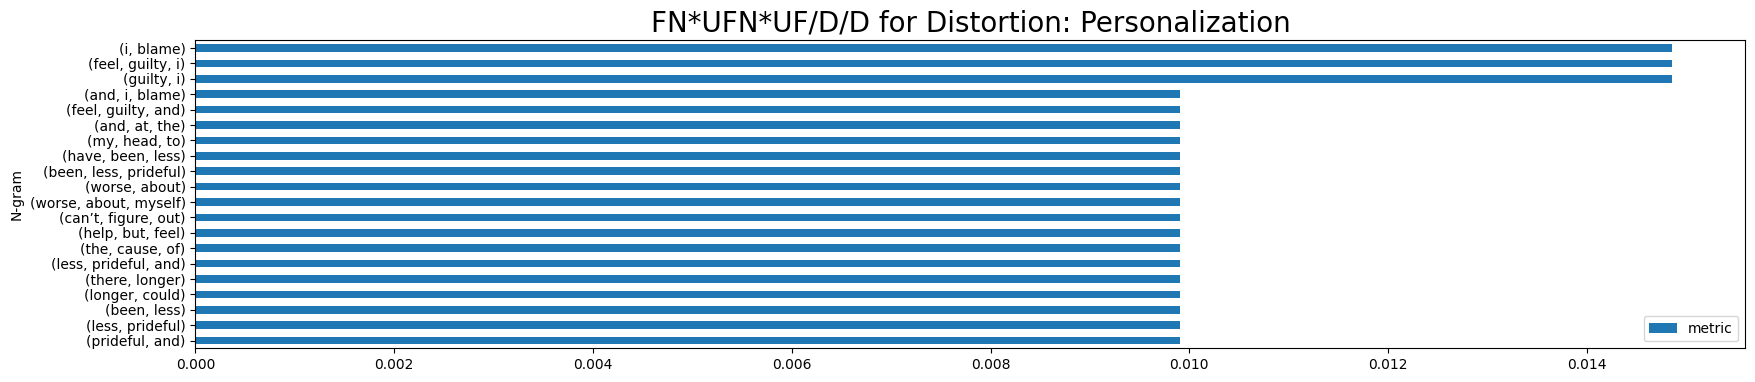

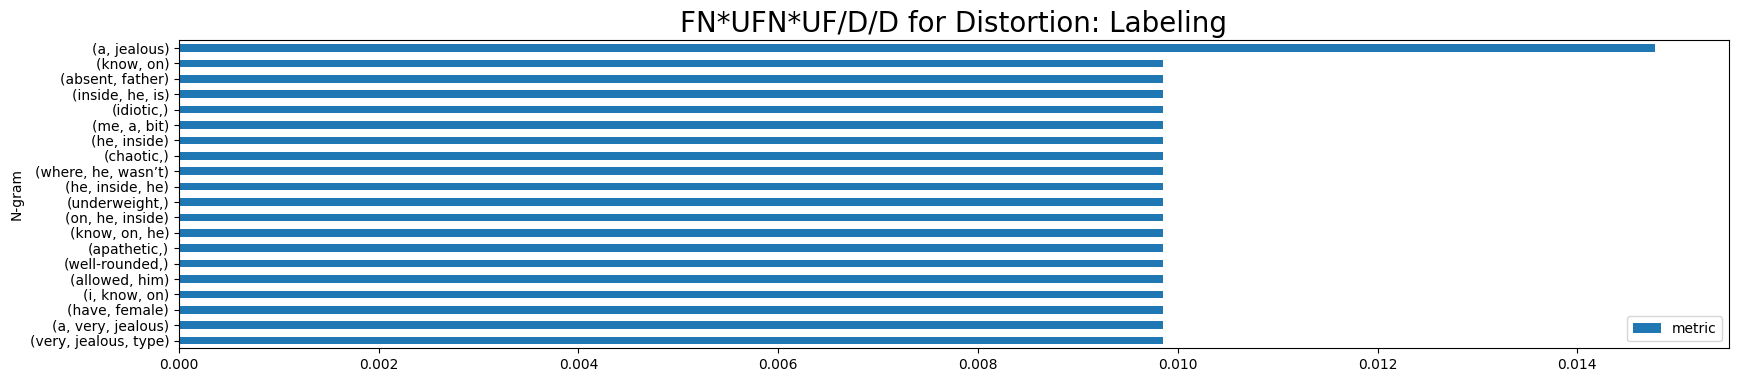

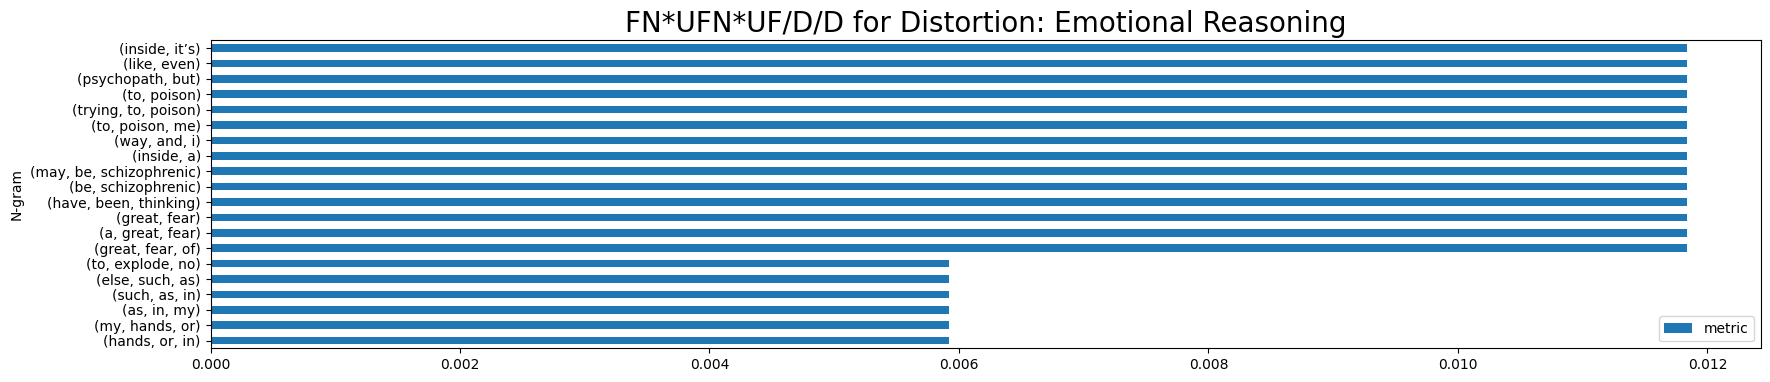

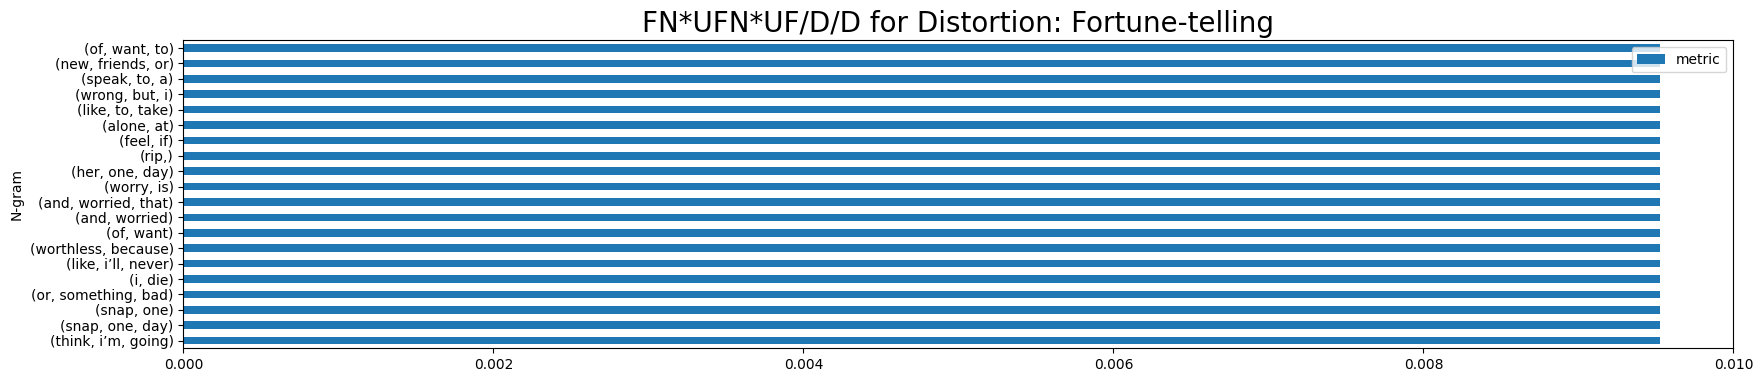

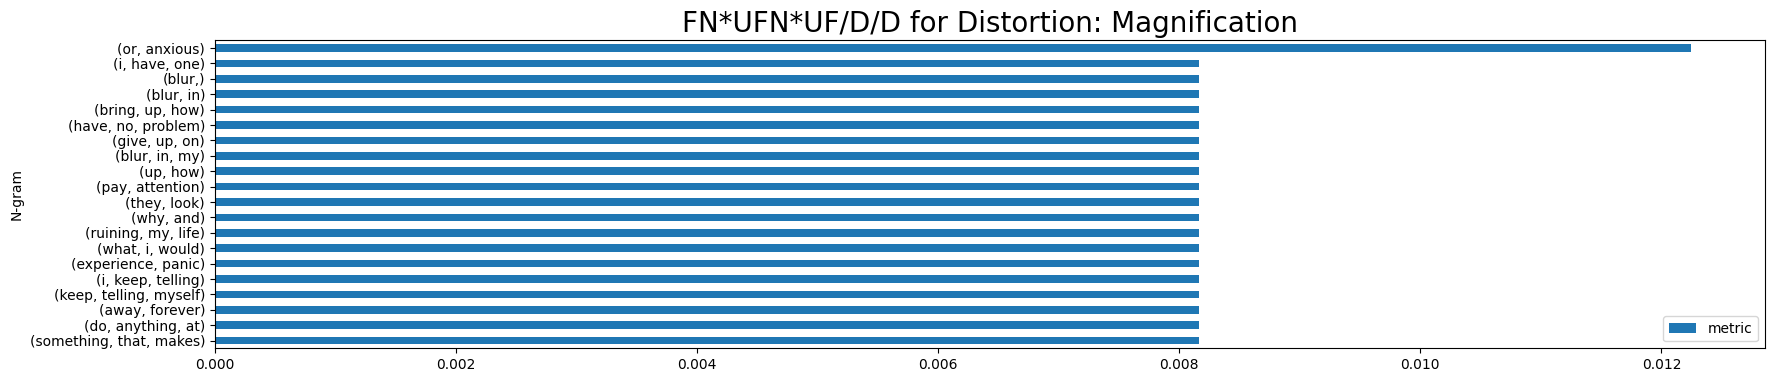

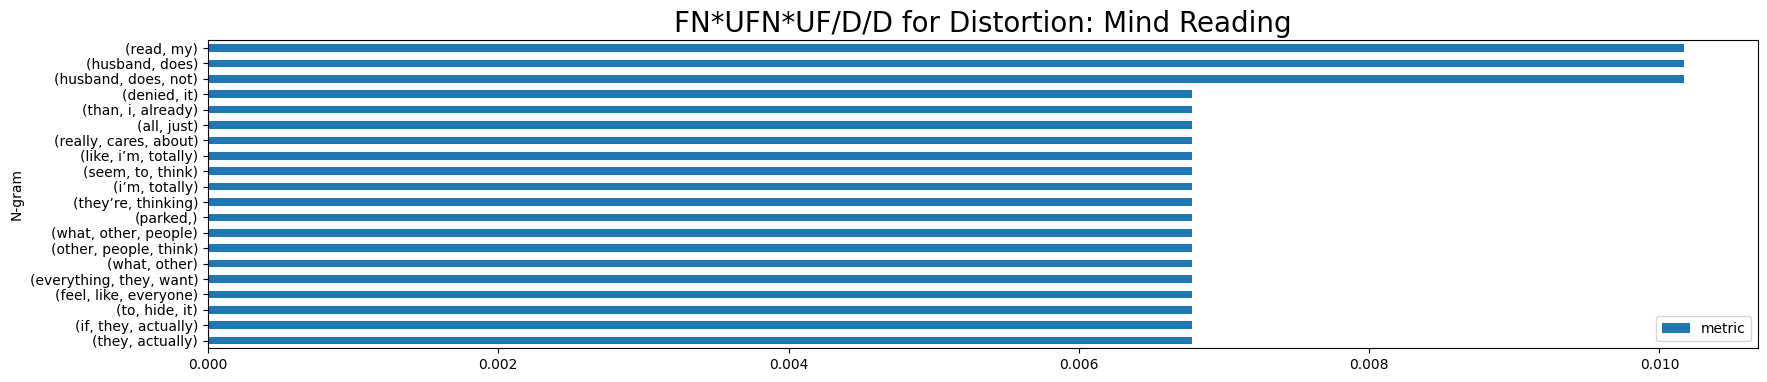

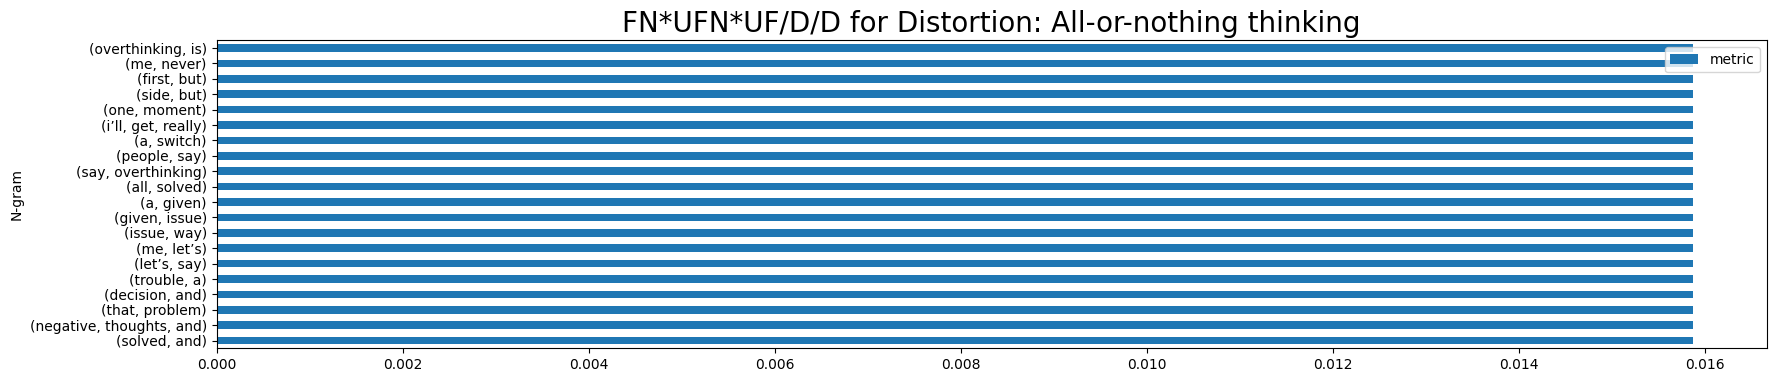

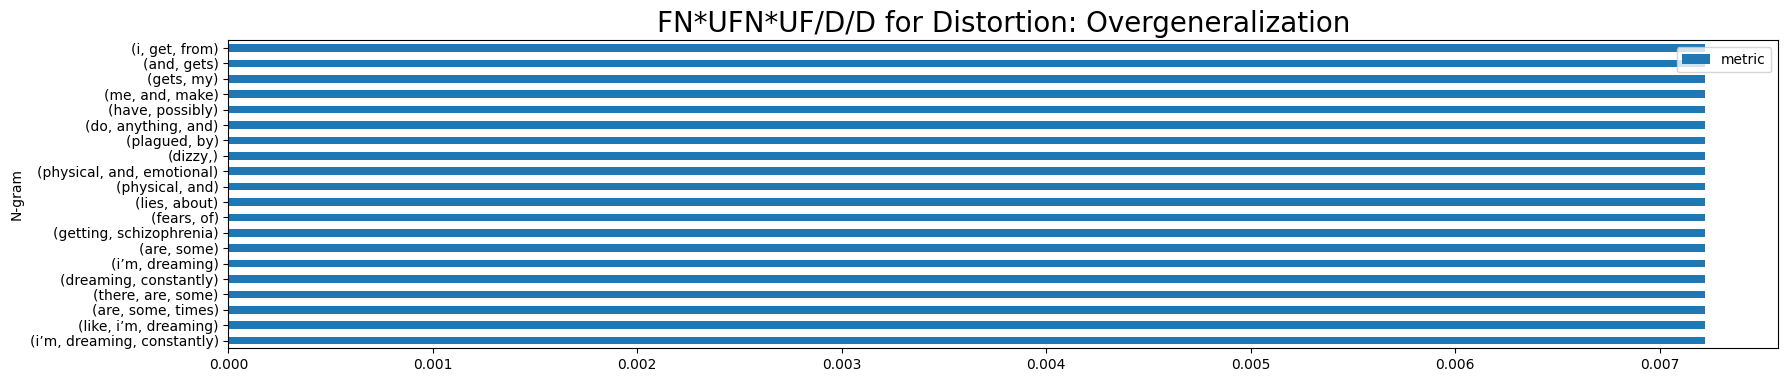

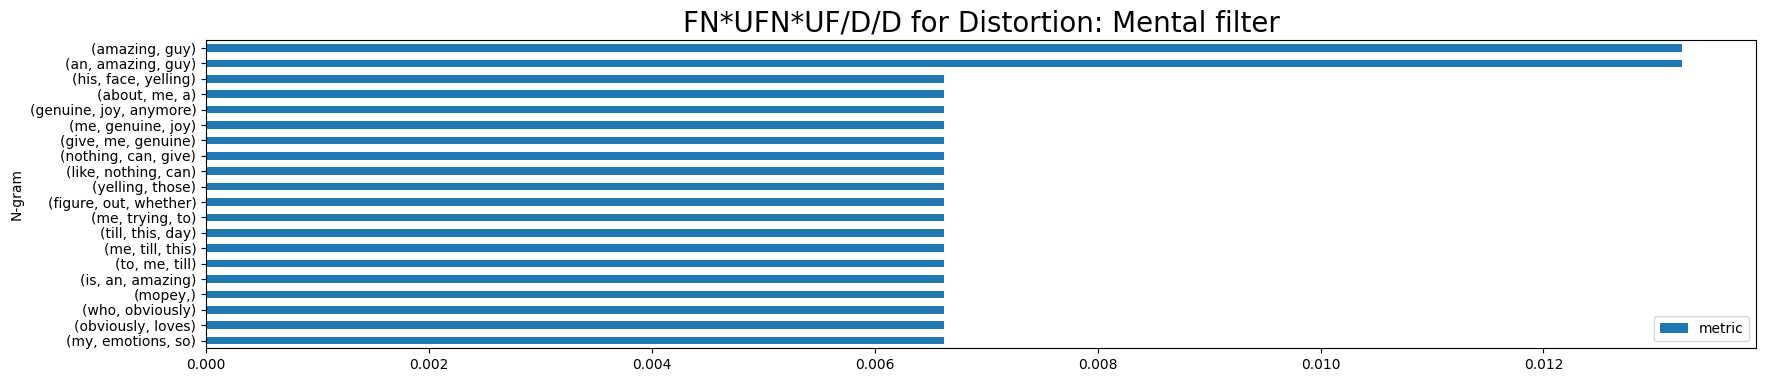

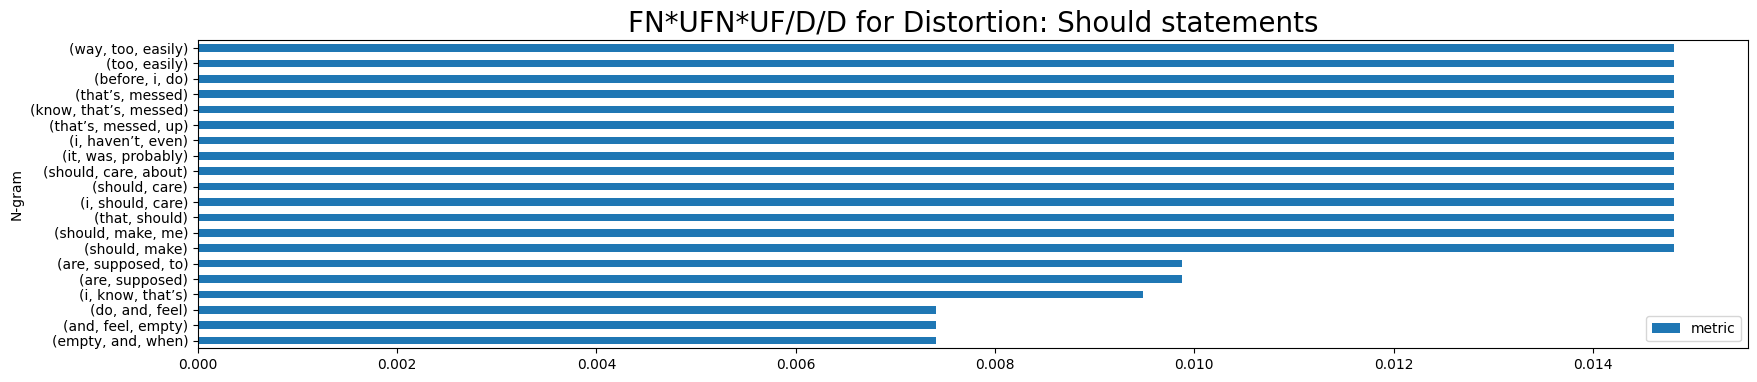

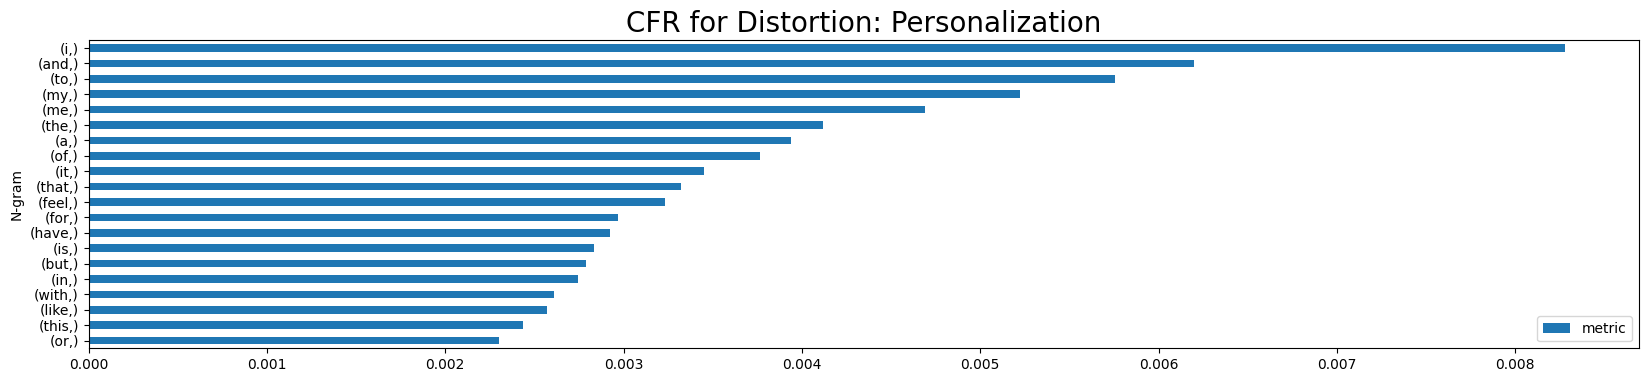

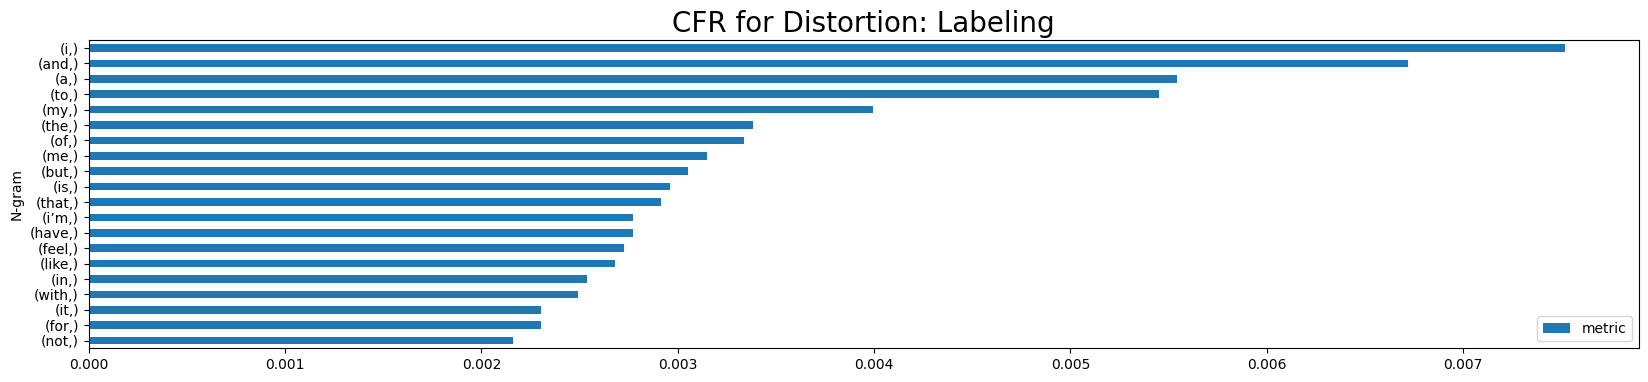

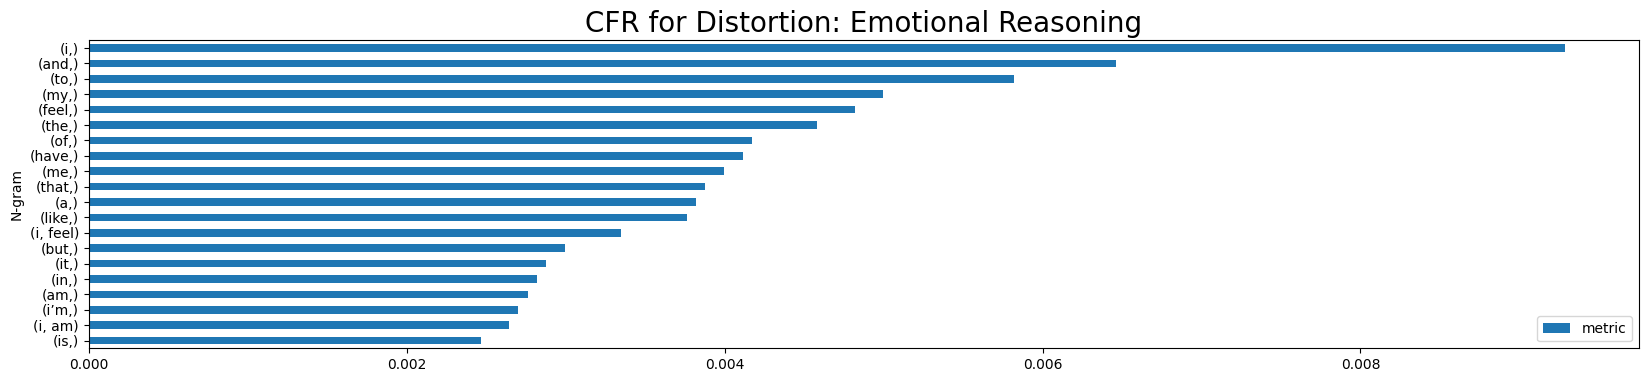

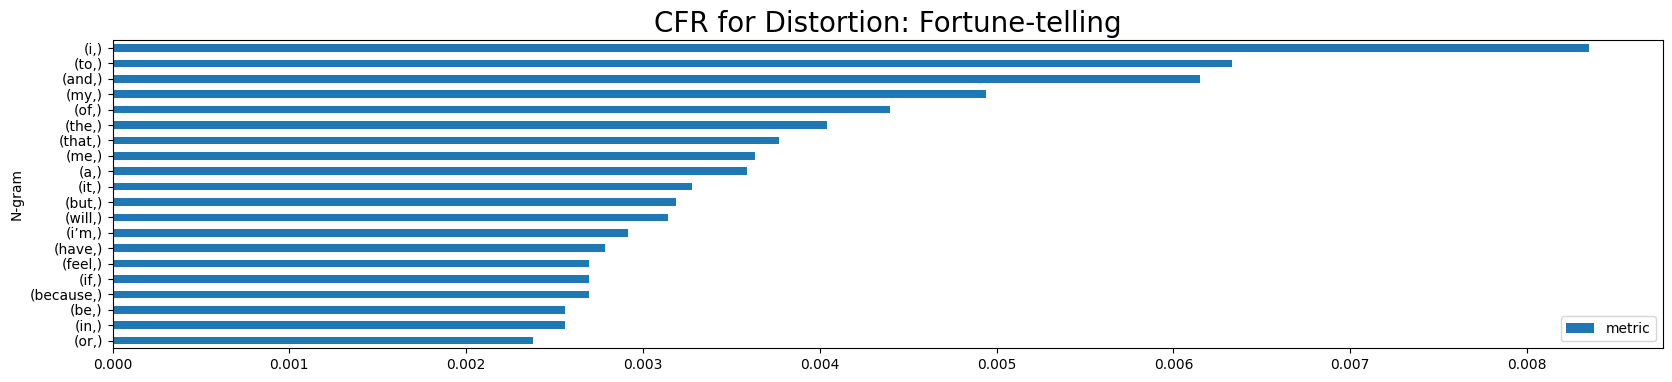

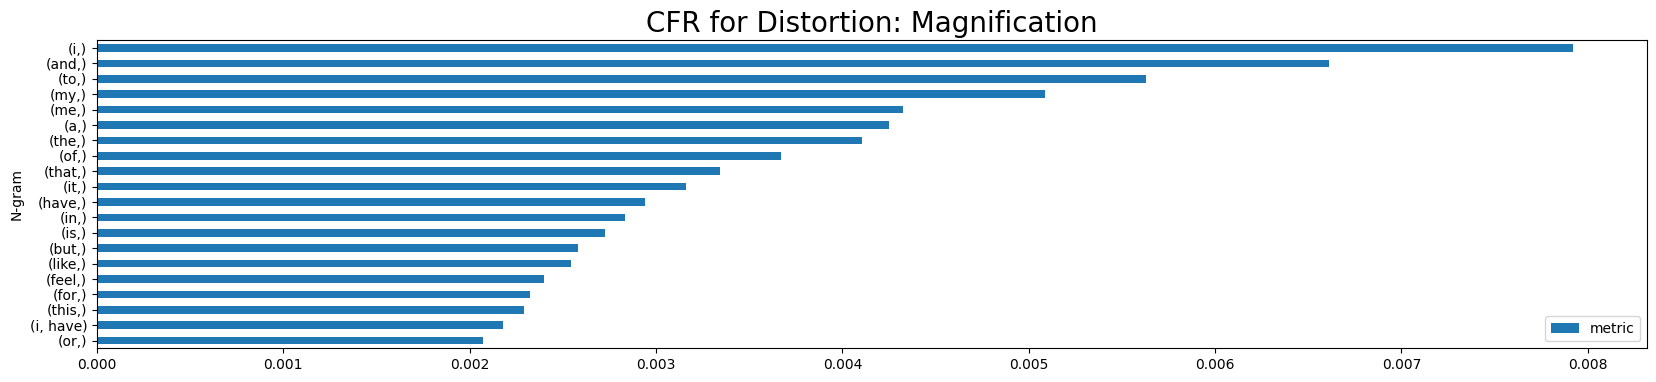

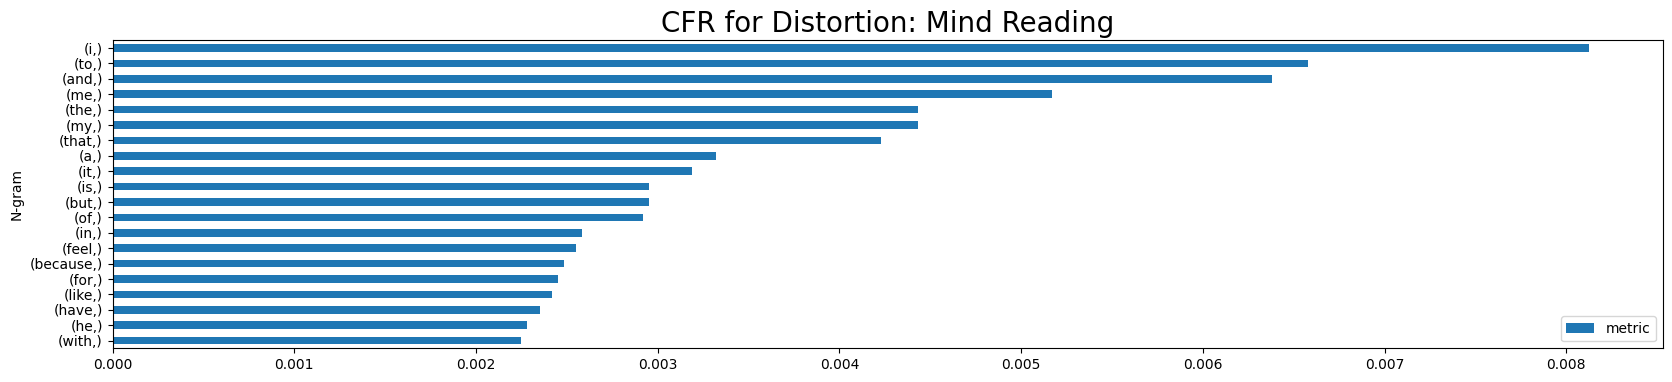

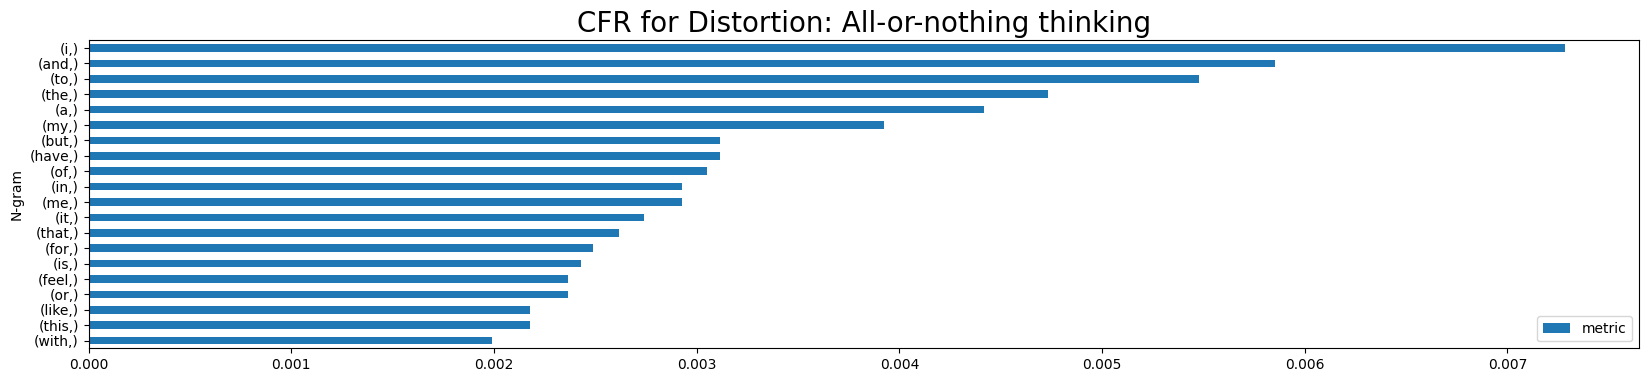

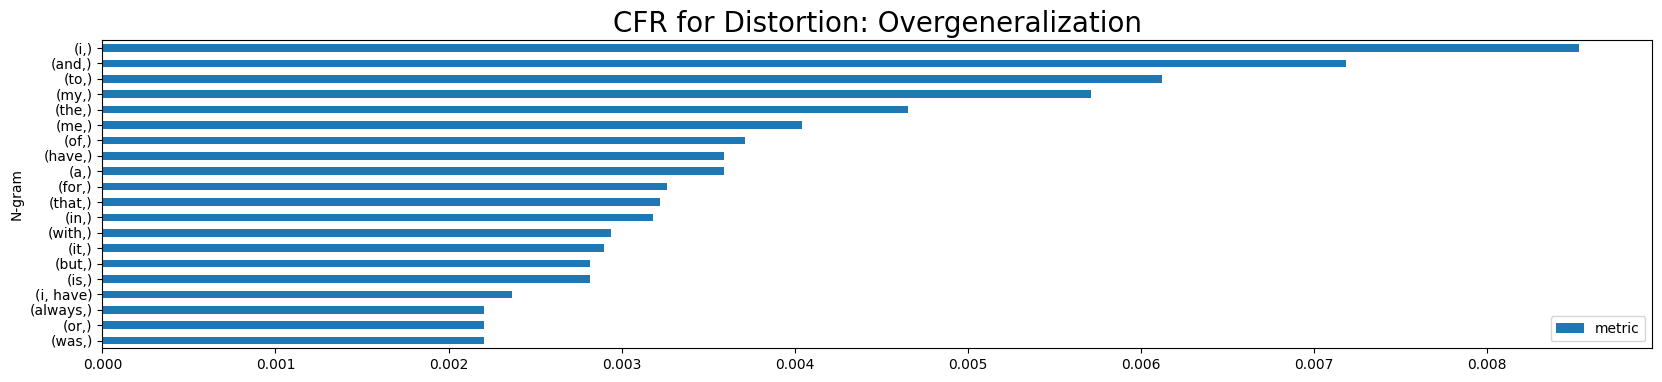

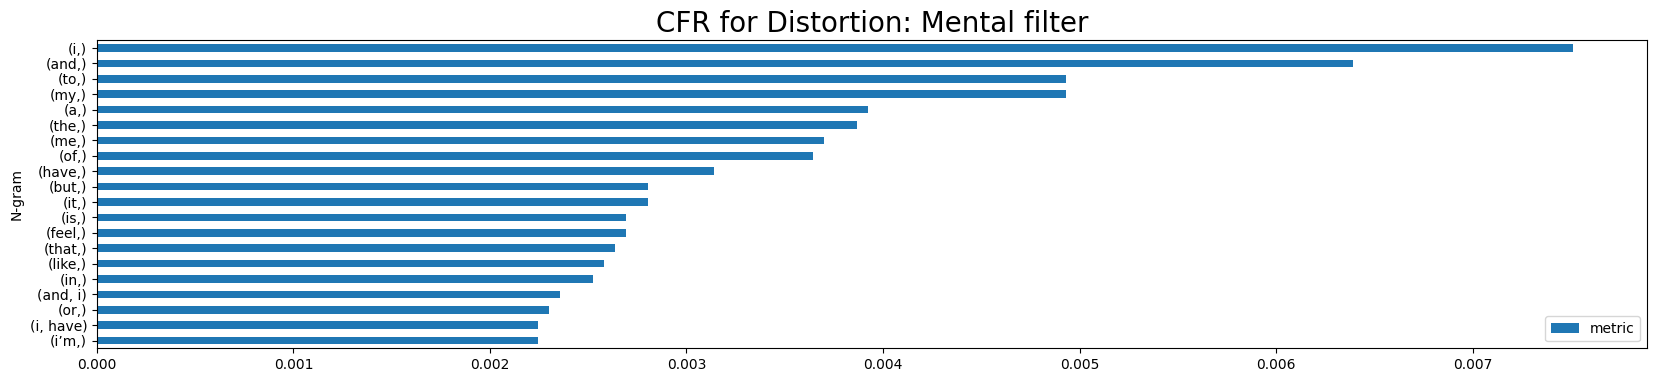

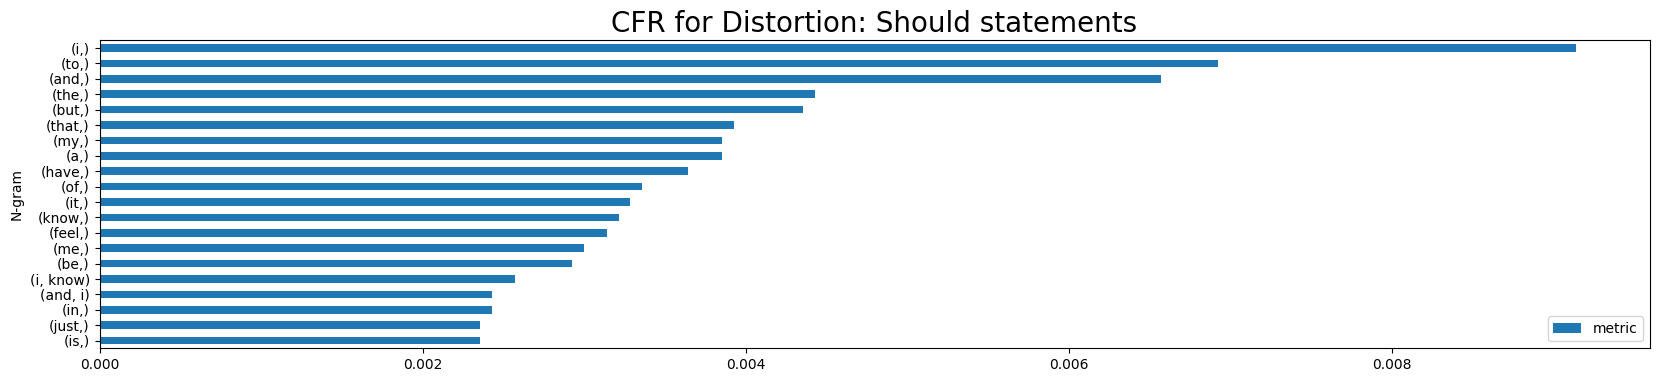

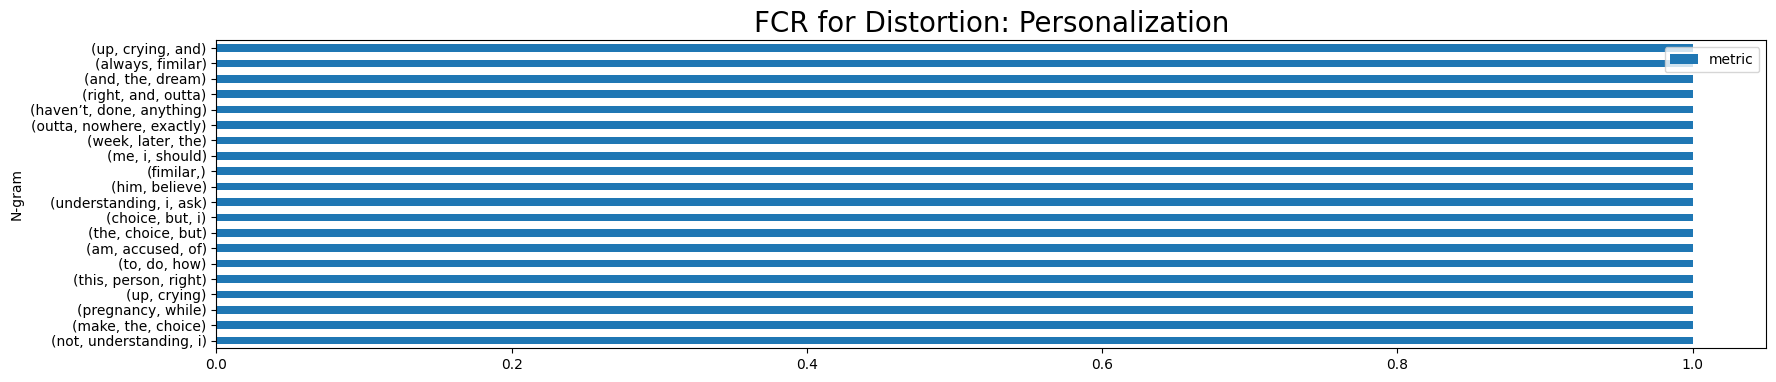

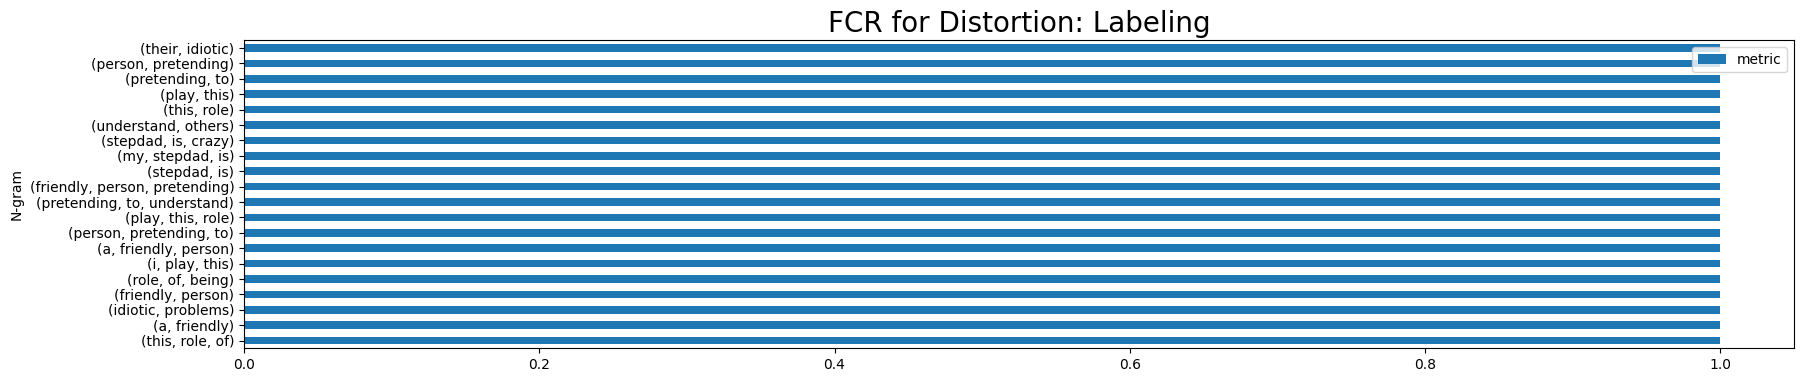

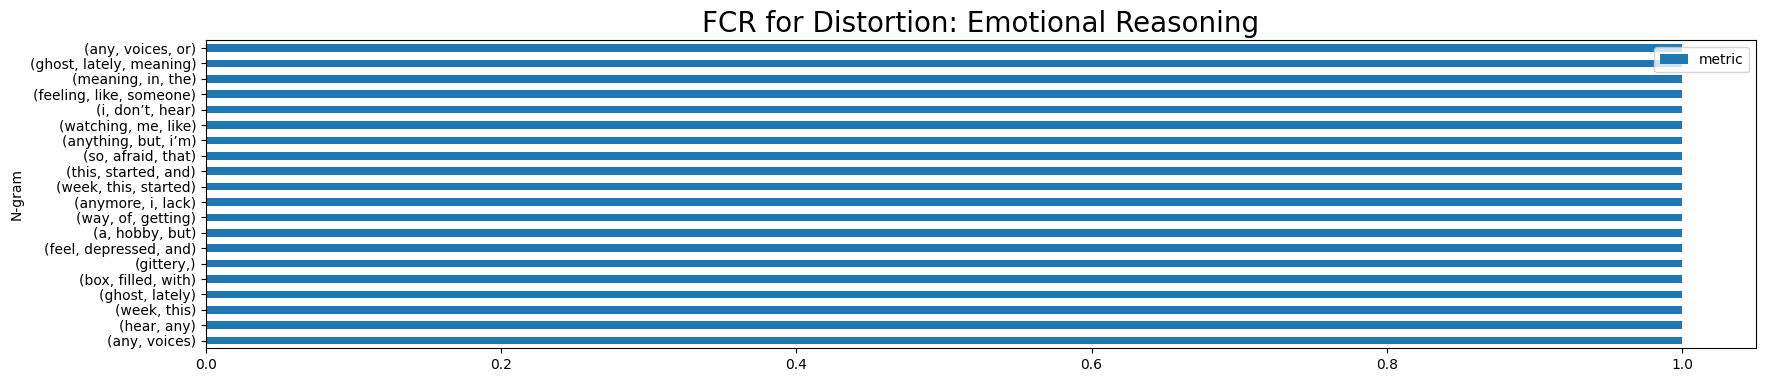

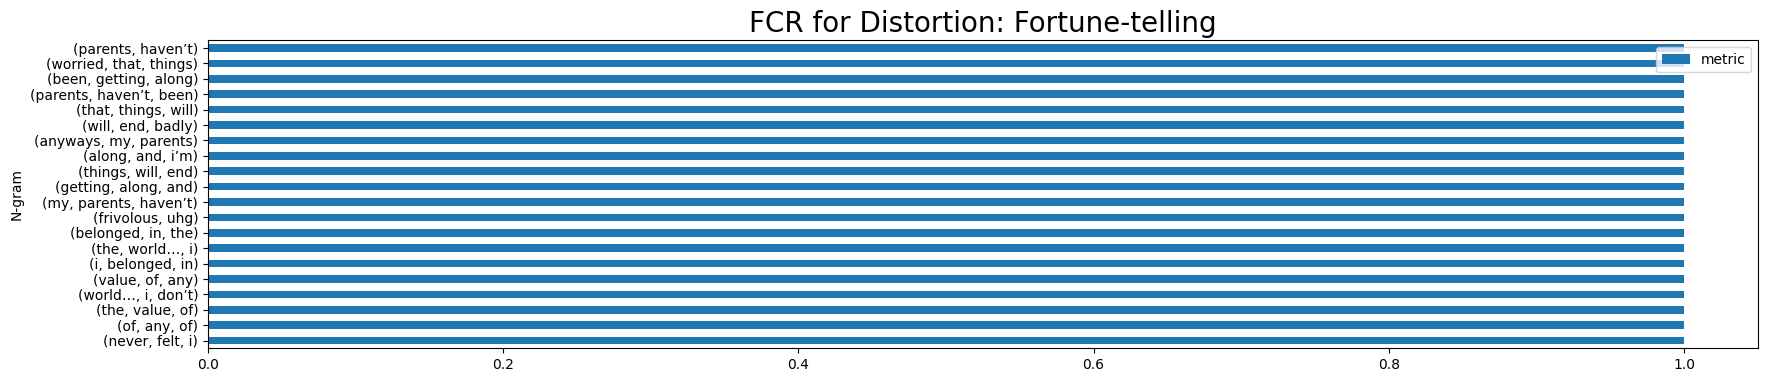

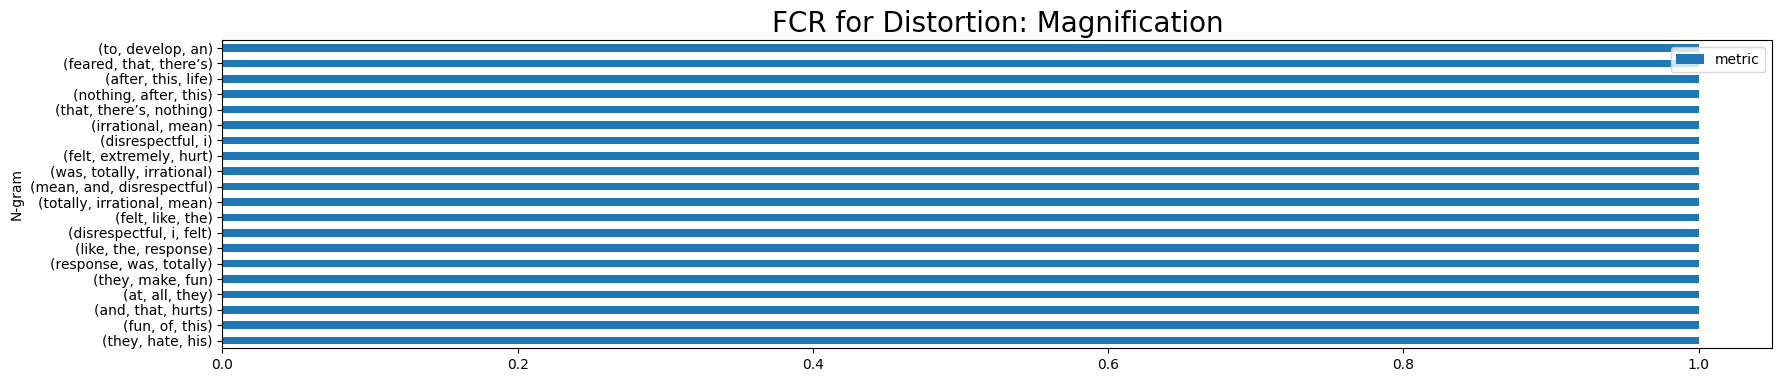

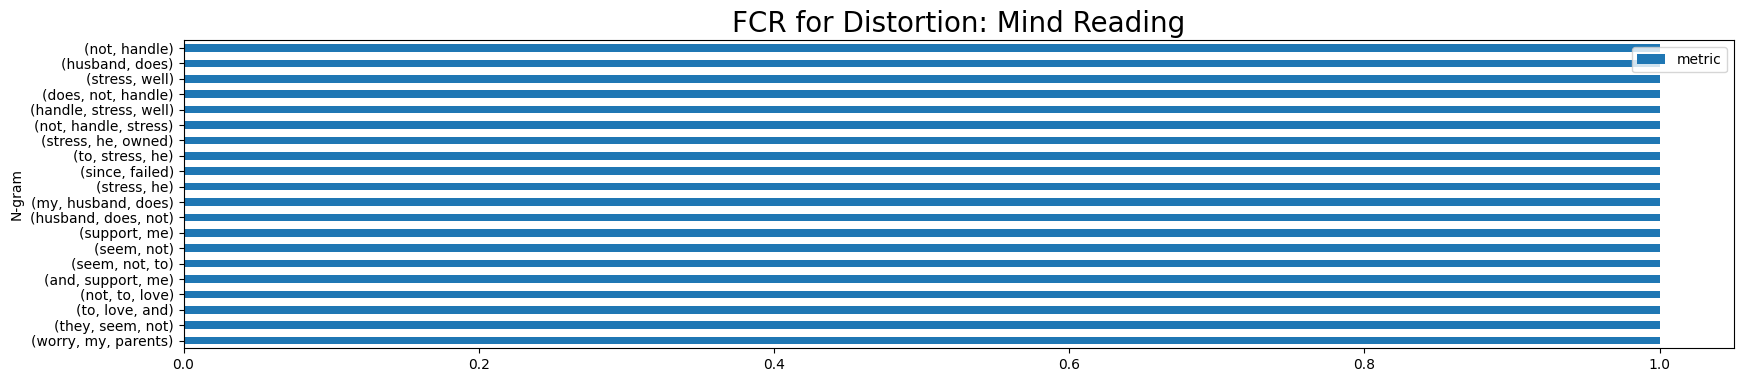

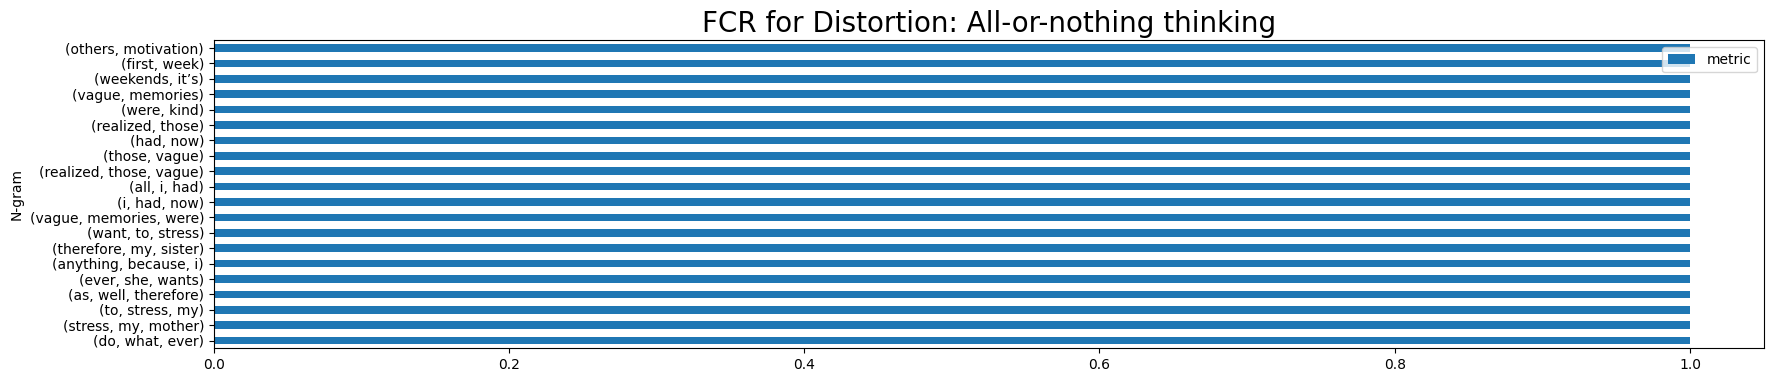

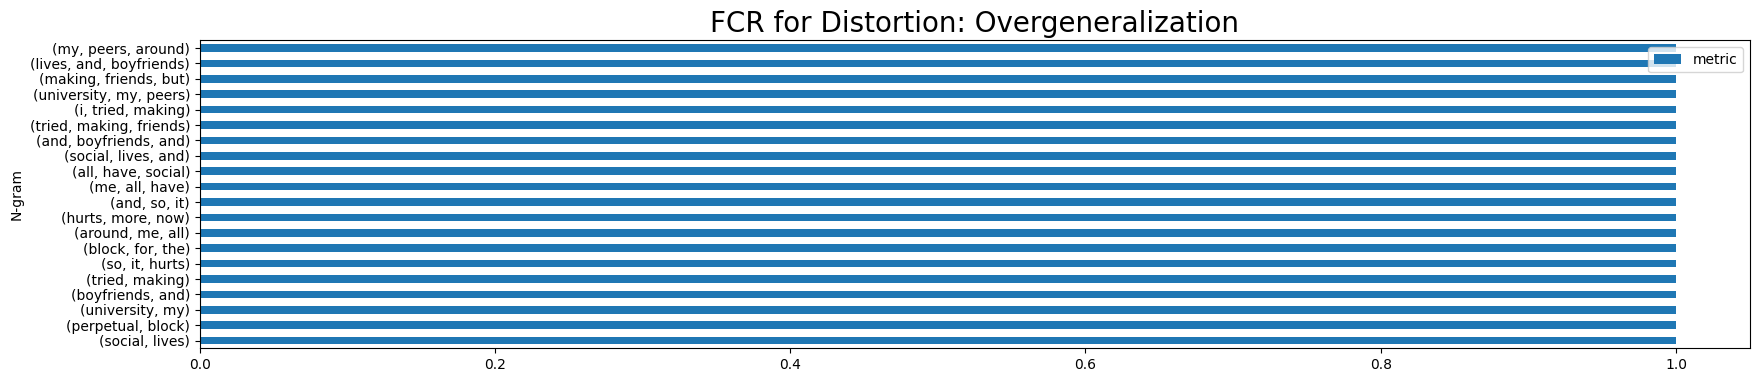

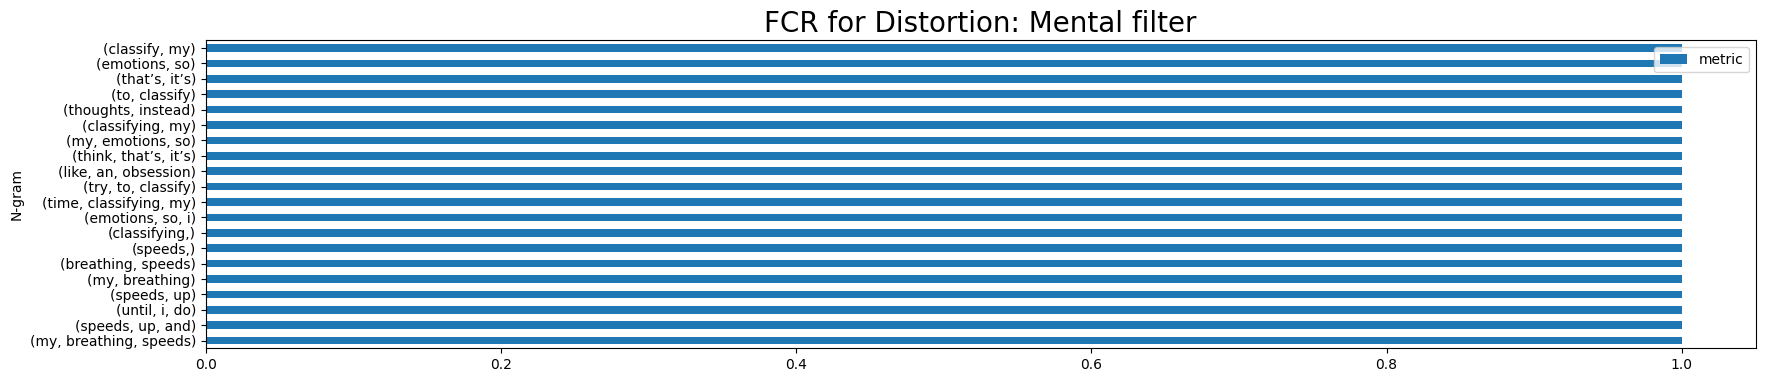

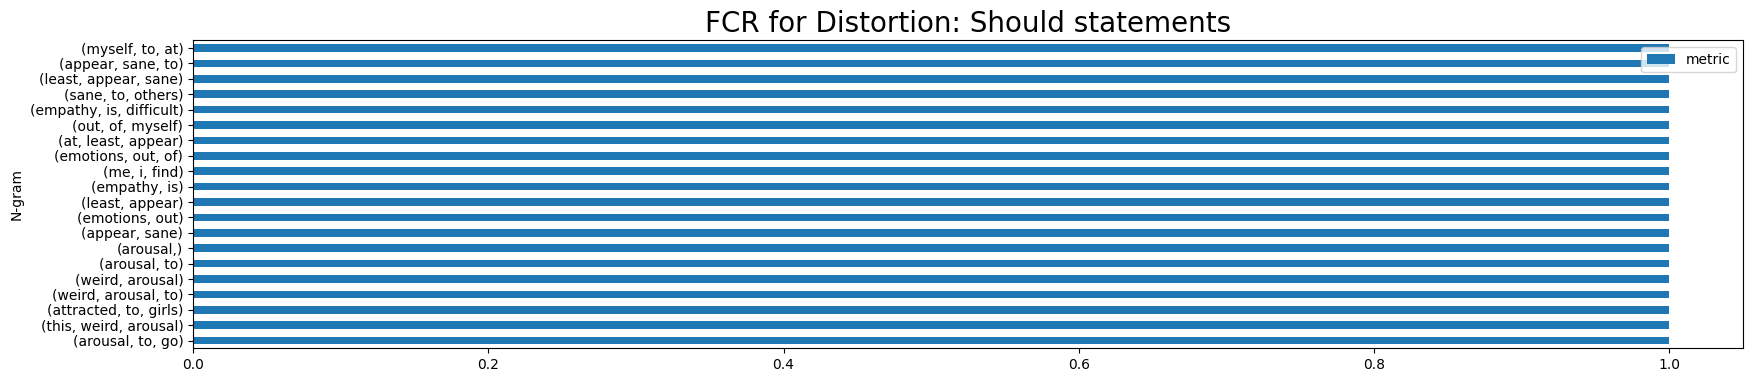

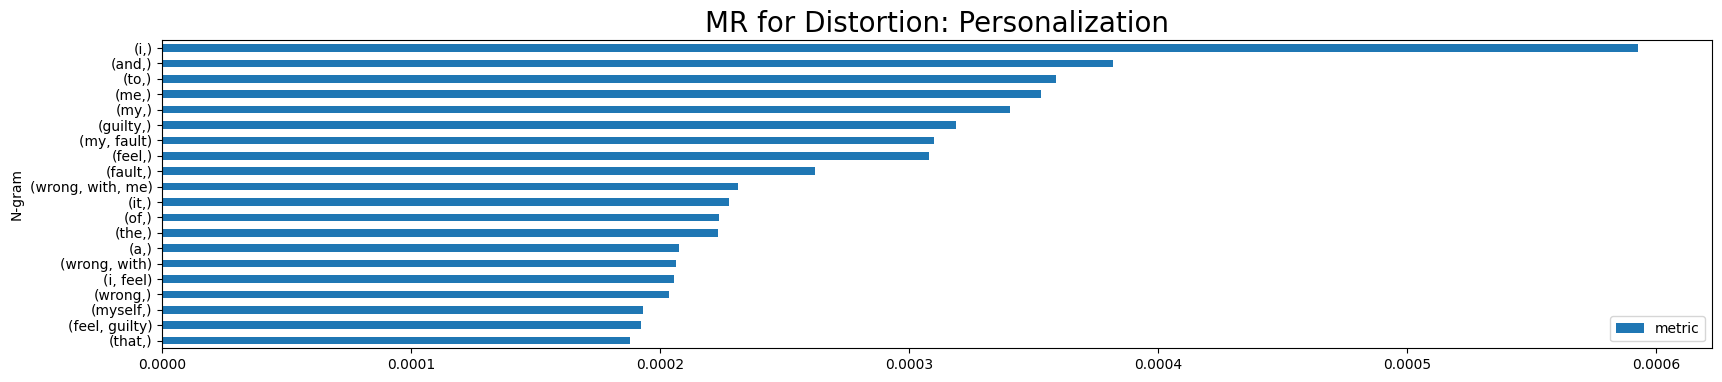

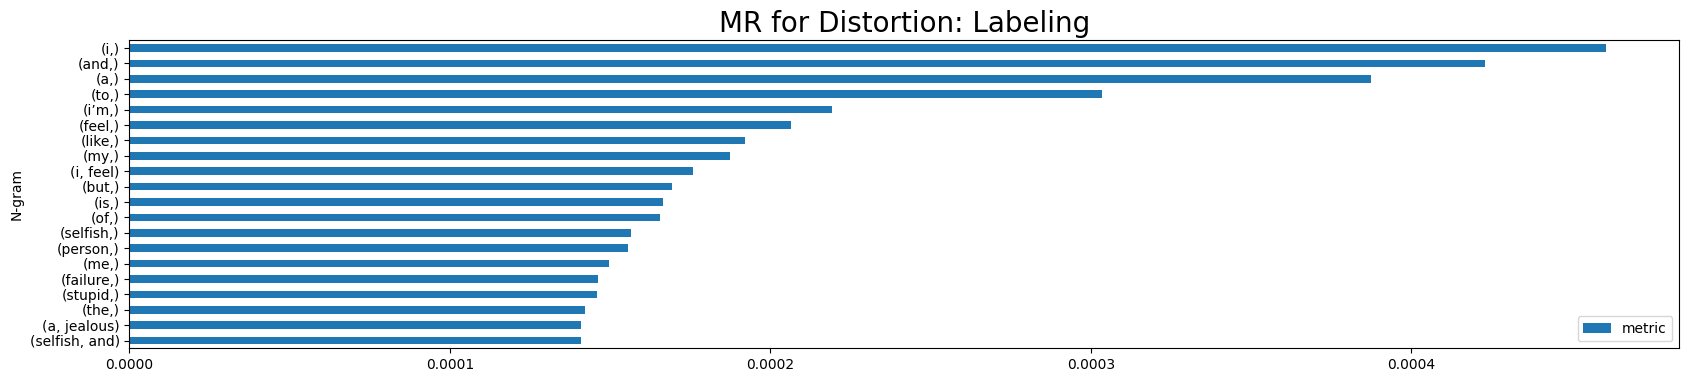

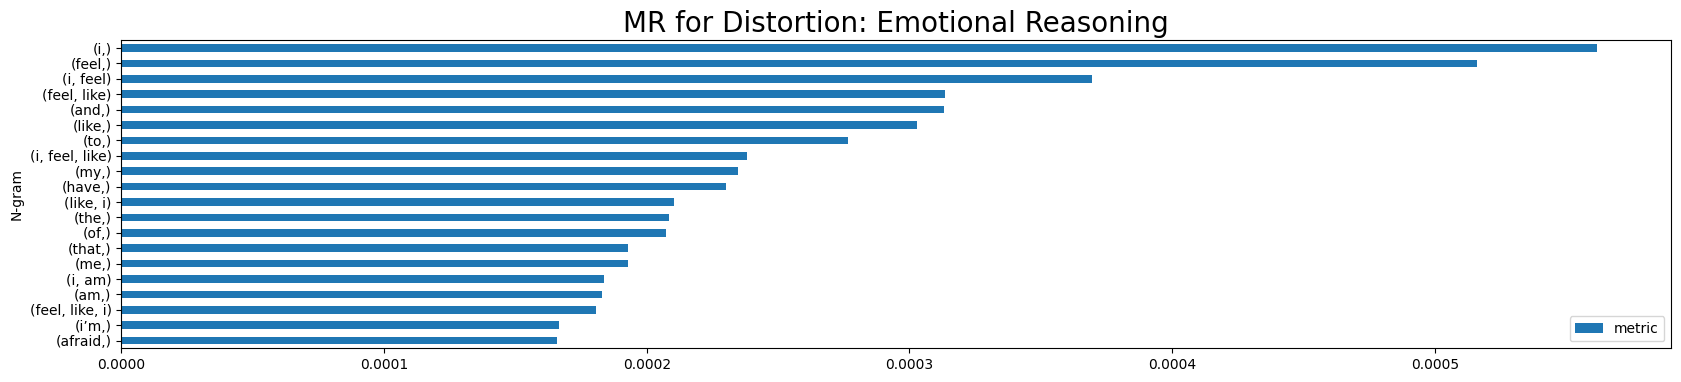

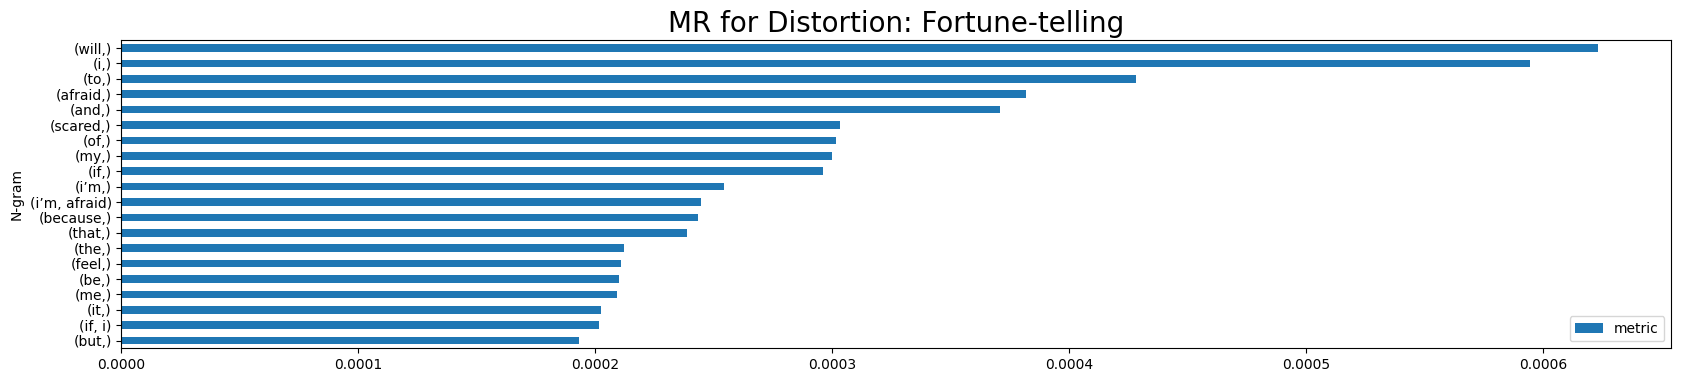

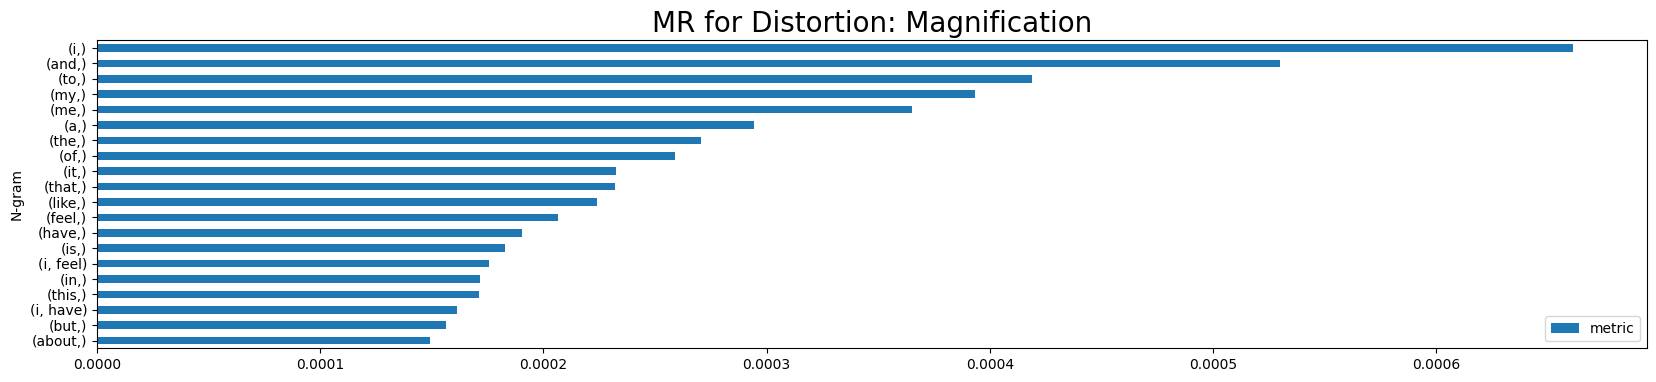

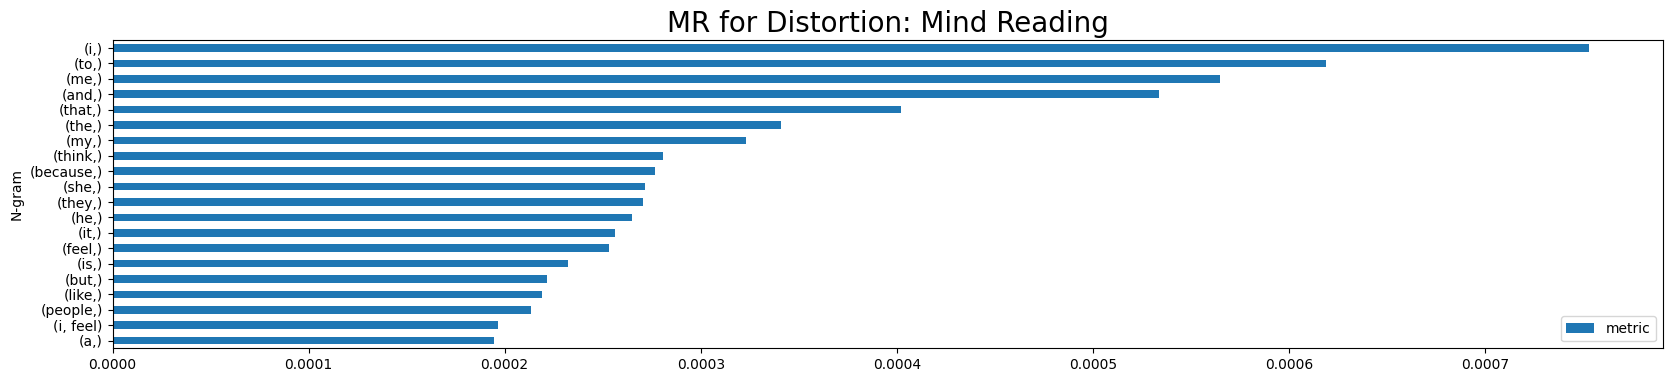

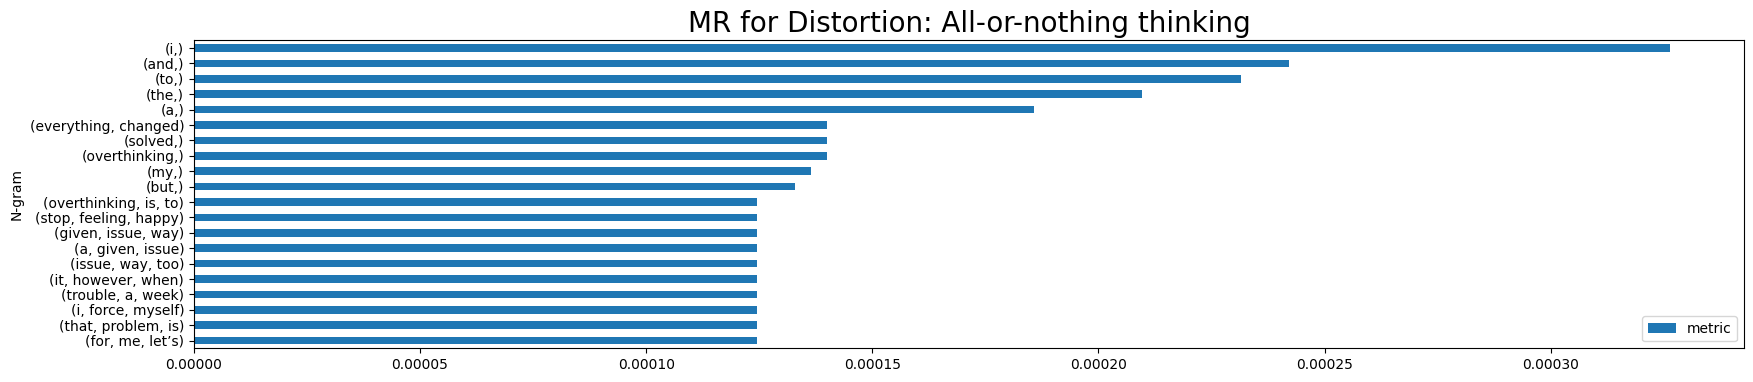

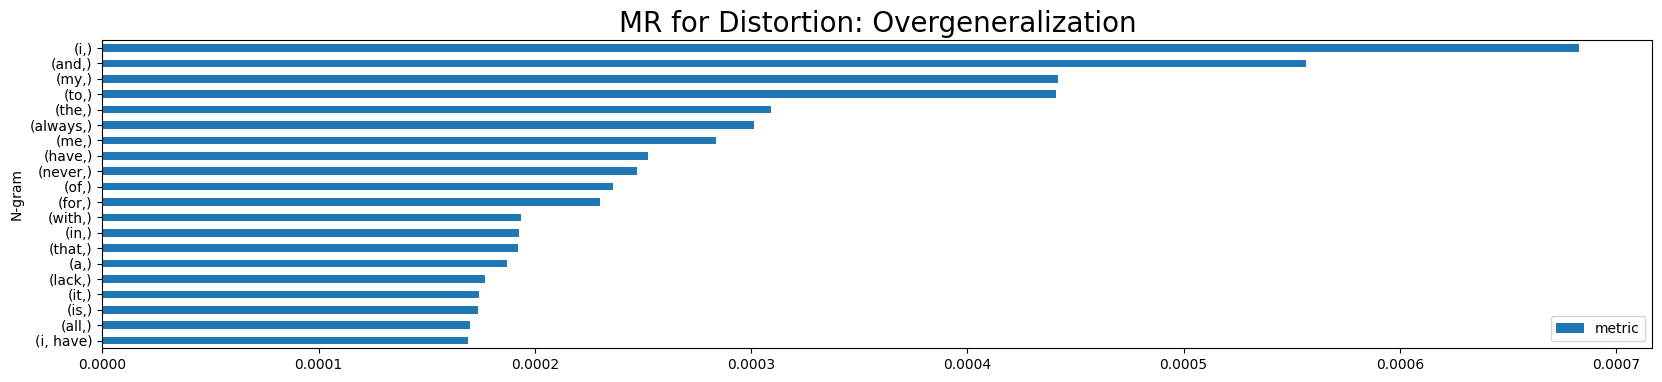

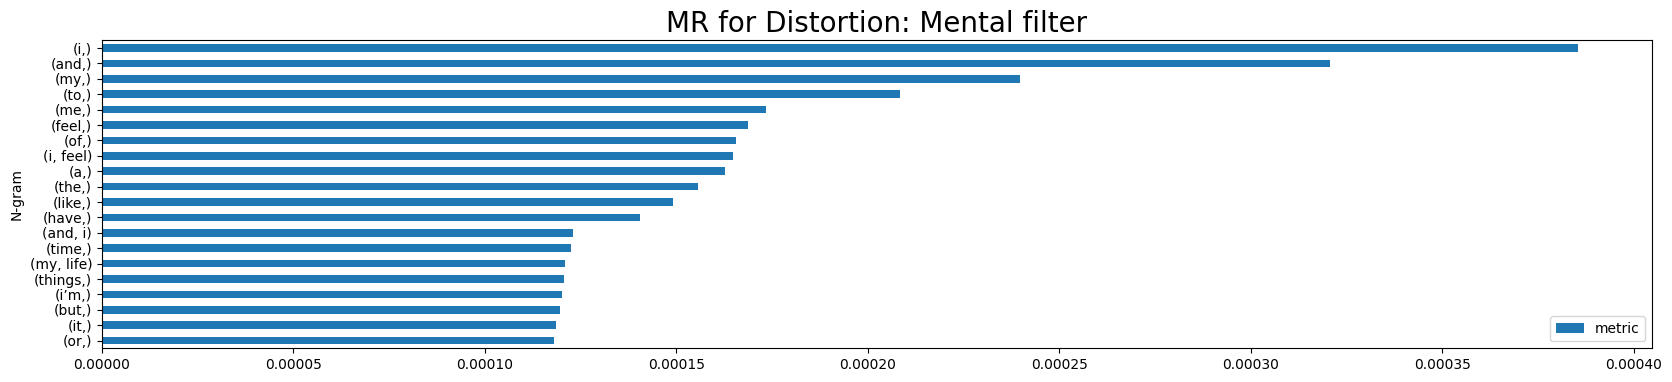

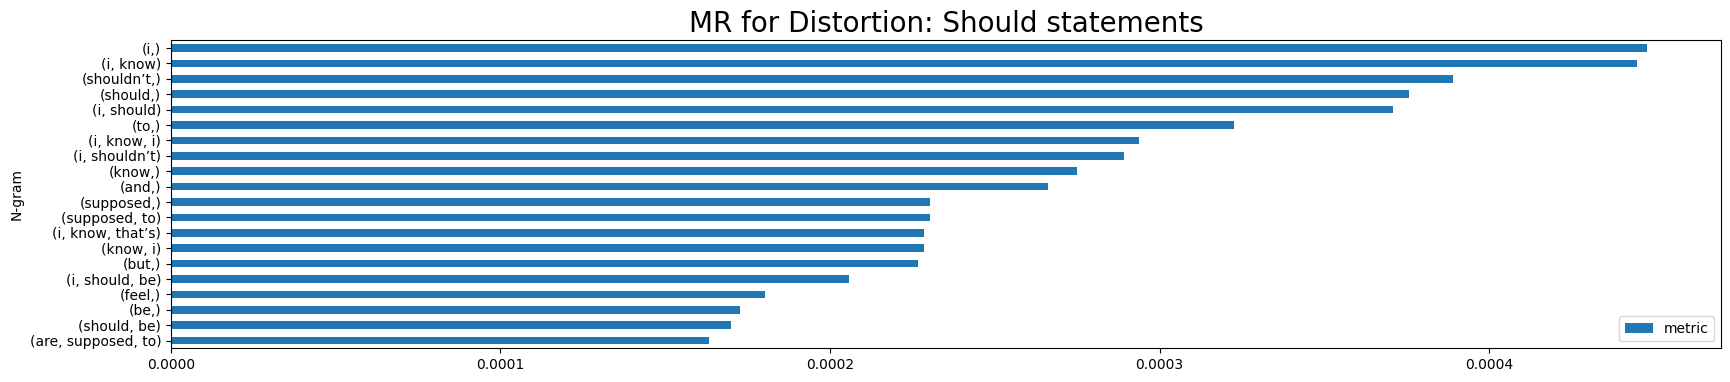

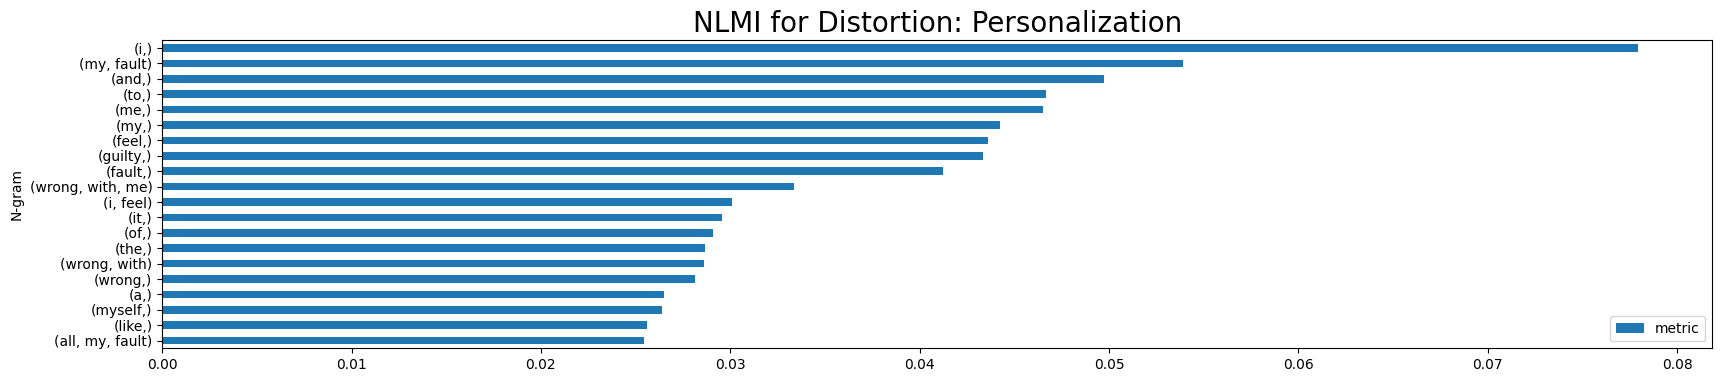

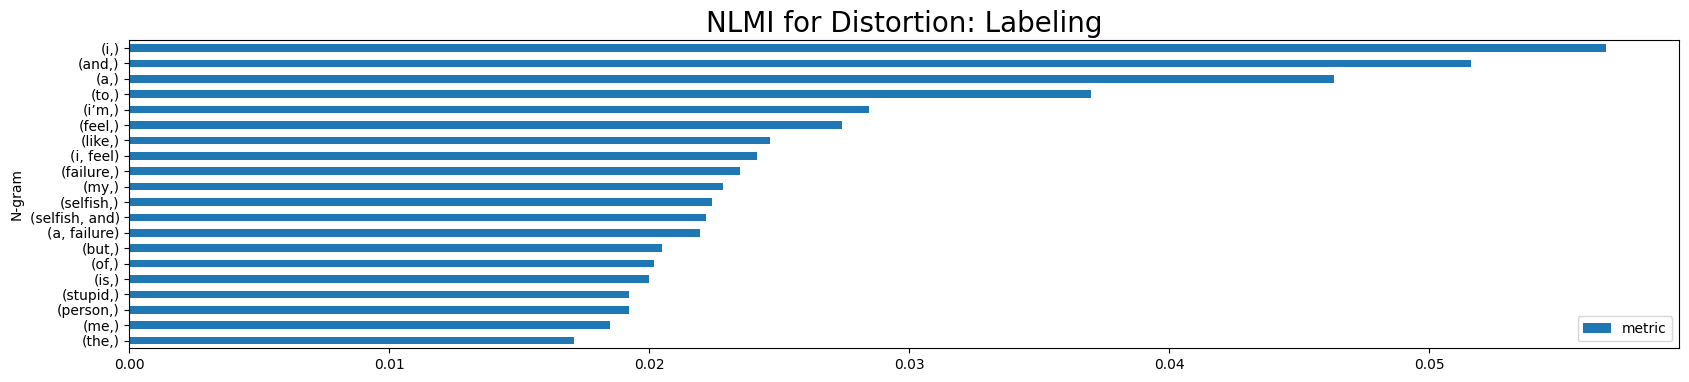

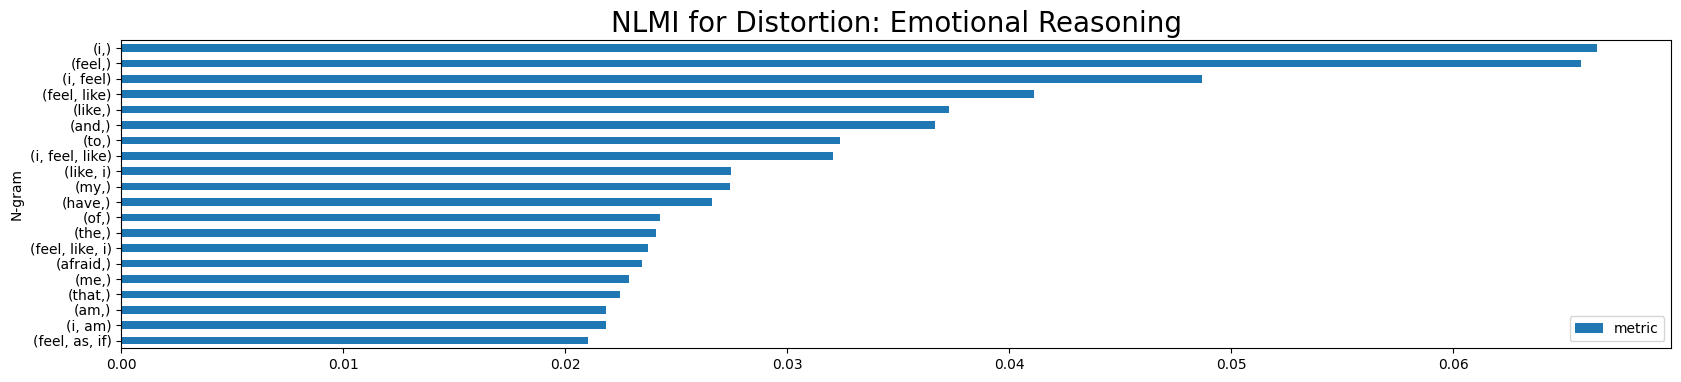

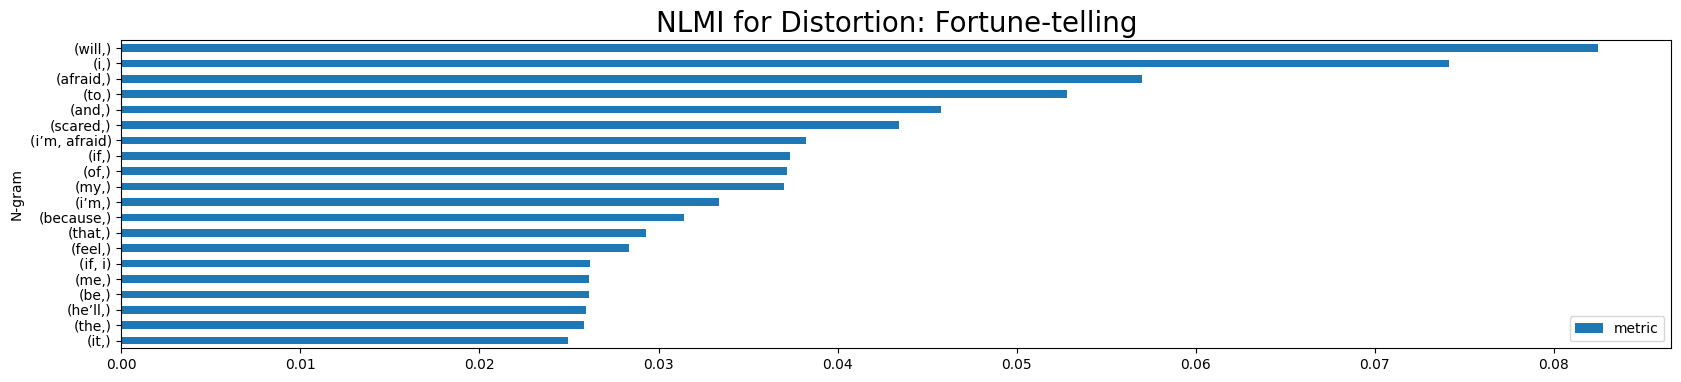

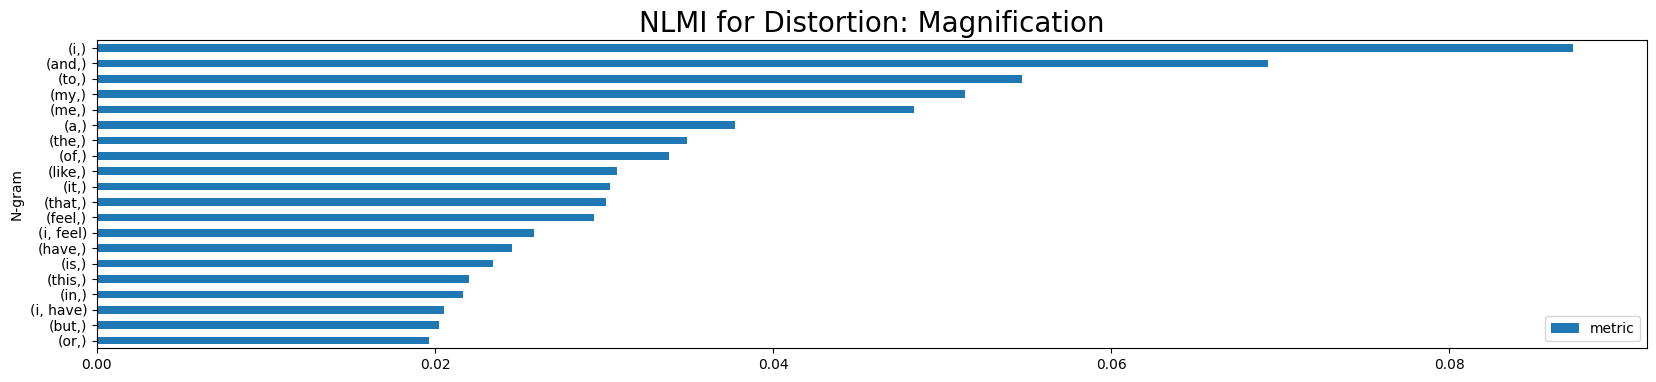

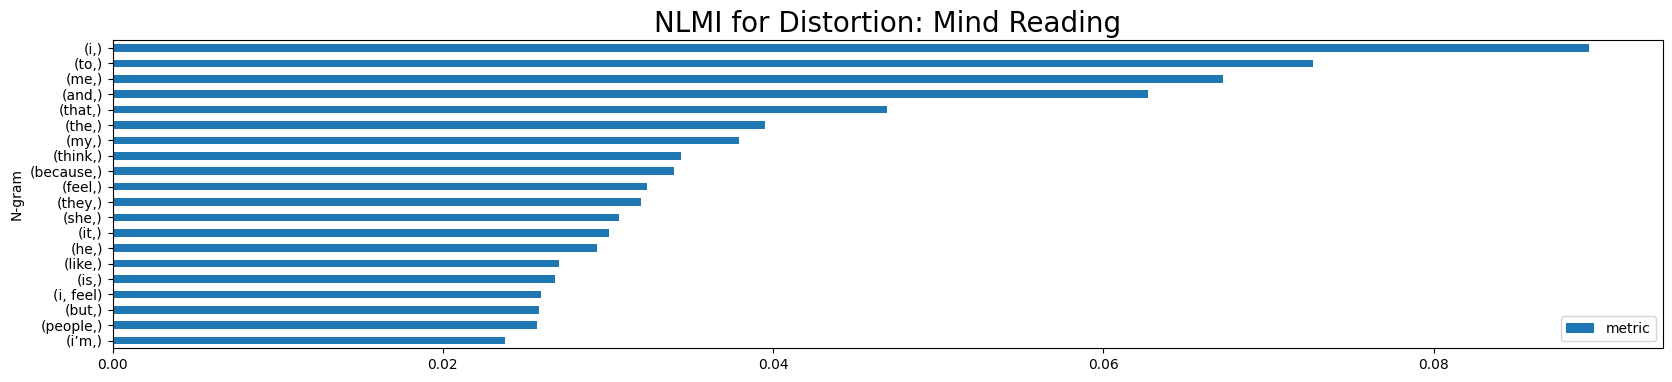

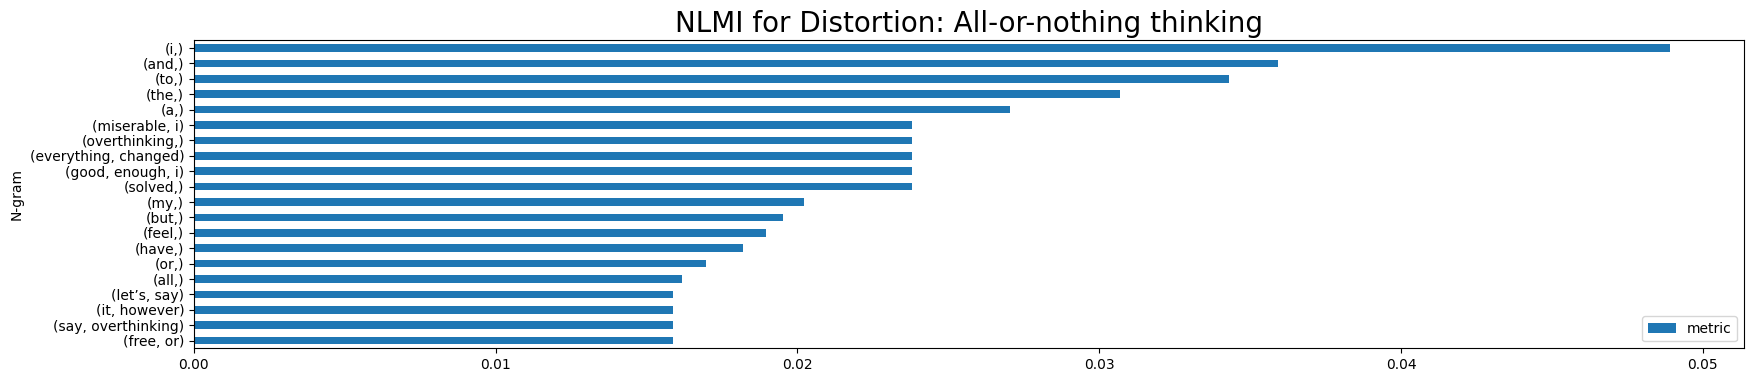

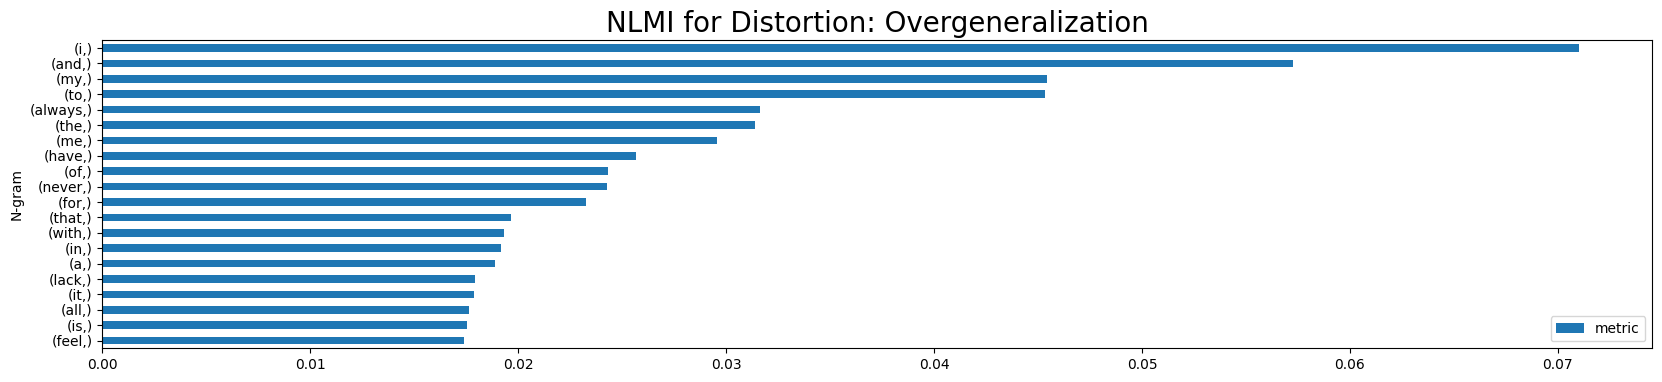

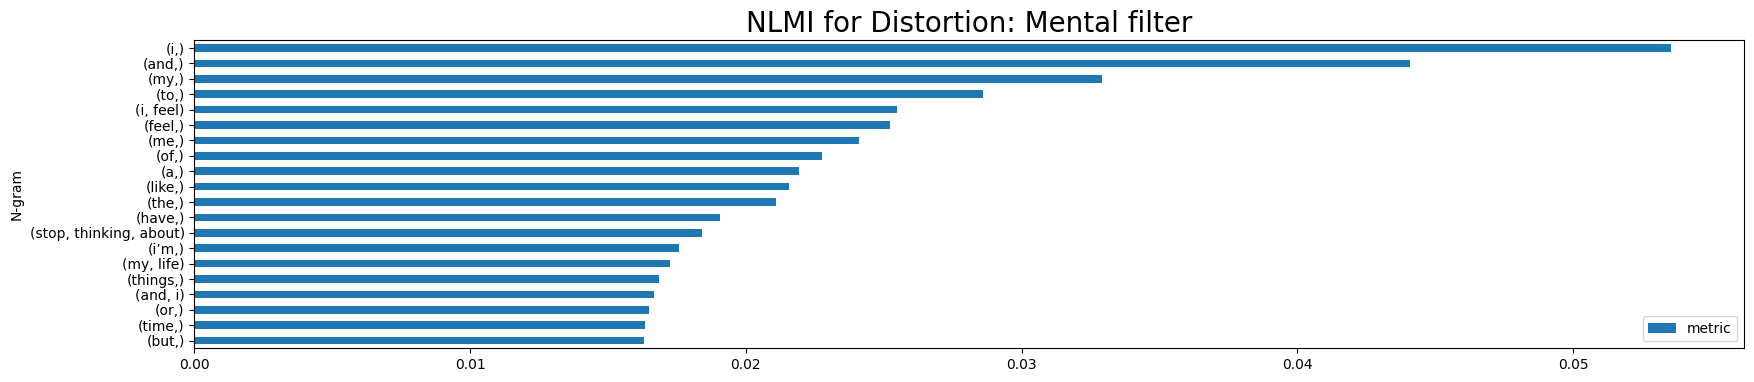

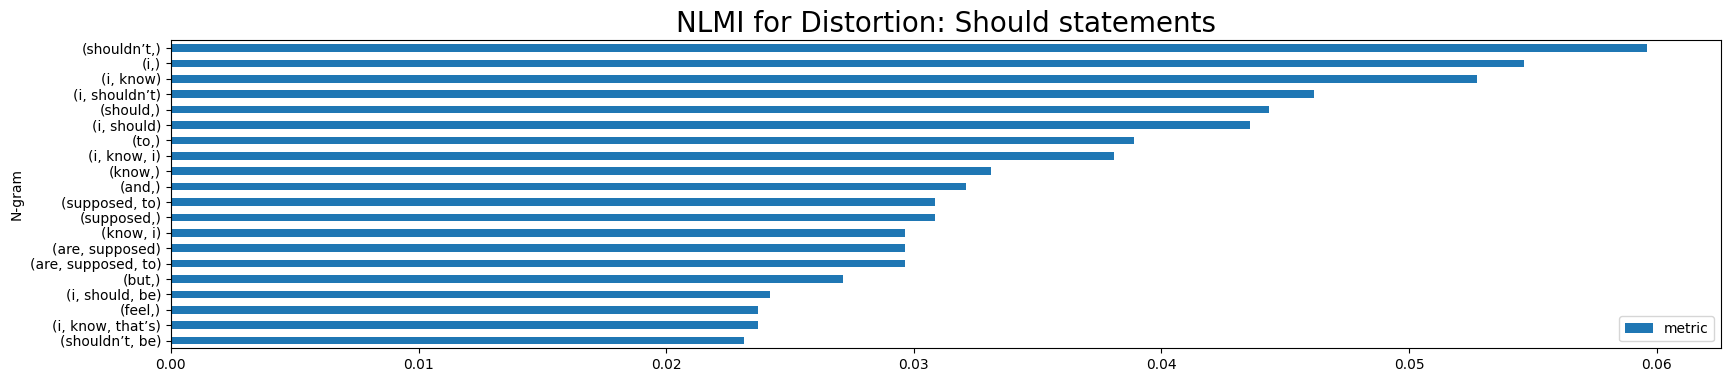

In [30]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1],head = 20)